In [193]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/Clustering/data')

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/bin/bash: line 1: nvidia-smi: command not found
Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [194]:
#!pip install numpy==1.16.0
!pip install scikit-learn-extra
!pip install umap-learn
# !pip install hdbscan
!pip install git+https://github.com/scikit-learn-contrib/hdbscan.git
!pip install tslearn
!pip install geopandas
!pip install -q ipywidgets
!pip3 install ipympl
%load_ext autoreload
%autoreload 2
!pip install folium

  Cloning https://github.com/scikit-learn-contrib/hdbscan.git to /tmp/pip-req-build-z4dy3w36
  Running command git clone --filter=blob:none --quiet https://github.com/scikit-learn-contrib/hdbscan.git /tmp/pip-req-build-z4dy3w36
  Resolved https://github.com/scikit-learn-contrib/hdbscan.git to commit e5e1b8e7a348fc06e99d71d35e72d0e51c066194
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [195]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import correlate
import plotly.graph_objects as go
import statsmodels.api as sm
from scipy import stats
from scipy.stats import iqr
from itertools import combinations
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import DBSCAN
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.manifold import TSNE
from umap import UMAP
import matplotlib.image as mpimg
import hdbscan
from sklearn.cluster import AgglomerativeClustering
from tslearn.metrics import dtw,lcss
import plotly.graph_objects as go
import plotly.express as px
from tslearn.clustering import TimeSeriesKMeans
#from tslearn.clustering import silhouette_score
from sklearn.metrics import silhouette_samples,silhouette_score
import geopandas as gpd
import time
from collections import Counter
import math
from sklearn.manifold import Isomap
import pywt
import pywt.data
import plotly.subplots as sp
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from matplotlib.pyplot import get_cmap
from matplotlib.pyplot import cm
from scipy.spatial import distance
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
from scipy.signal import find_peaks
from statsmodels.tsa.stattools import acf,pacf
import folium

%matplotlib inline
#%matplotlib notebook
"""
extract features and cluster feature vectors from all stations.
use closest actual station to centroid to be the representative station.
Only analyze the representative stations and NOT all.
This is a dimensionality reduction technique.

"""

'\nextract features and cluster feature vectors from all stations.\nuse closest actual station to centroid to be the representative station.\nOnly analyze the representative stations and NOT all.\nThis is a dimensionality reduction technique.\n\n'

In [196]:
num_of_clusters = 66
timeslot_duration = 10
total_timelots = int(1440/timeslot_duration)
os.chdir('/content/drive/MyDrive/Clustering/data')
demand = np.load('A_21.npy',allow_pickle=True).reshape((num_of_clusters, num_of_clusters, total_timelots, timeslot_duration)).sum(axis=3)
demand = demand.sum(axis=1).T
manhat_demand = pd.DataFrame(data=demand,index=pd.date_range(start='2020-01-21 00:00:00', end='2020-01-21 23:50:00', freq='10T'),columns=[ str(i) for i in range(demand.shape[1])])
manhat_demand

0    1    2    3    4    5     6    7     8    9  ...  \
2020-01-21 00:00:00  0.0  0.0  1.0  1.0  1.0  0.0   1.0  0.0   7.0  1.0  ...   
2020-01-21 00:10:00  0.0  0.0  1.0  2.0  3.0  1.0   1.0  1.0   9.0  2.0  ...   
2020-01-21 00:20:00  1.0  0.0  0.0  2.0  0.0  3.0   3.0  0.0  18.0  7.0  ...   
2020-01-21 00:30:00  1.0  0.0  0.0  0.0  3.0  1.0   1.0  0.0   9.0  3.0  ...   
2020-01-21 00:40:00  0.0  0.0  2.0  0.0  1.0  0.0   0.0  0.0  16.0  0.0  ...   
...                  ...  ...  ...  ...  ...  ...   ...  ...   ...  ...  ...   
2020-01-21 23:10:00  1.0  0.0  2.0  4.0  1.0  2.0  11.0  0.0  30.0  7.0  ...   
2020-01-21 23:20:00  2.0  0.0  2.0  0.0  1.0  1.0  13.0  0.0  24.0  3.0  ...   
2020-01-21 23:30:00  2.0  0.0  5.0  0.0  1.0  1.0   6.0  0.0  27.0  3.0  ...   
2020-01-21 23:40:00  1.0  0.0  1.0  2.0  3.0  2.0   3.0  1.0  13.0  2.0  ...   
2020-01-21 23:50:00  0.0  0.0  1.0  1.0  1.0  1.0   1.0  0.0  13.0  0.0  ...   

                       56    57    58   59   60    61    62   63   64    65  
2020-01-21 00:00:00   6.0   0.0   8.0  0.0  1.0   3.0   8.0  0.0  0.0   4.0  
2020-01-21 00:10:00   3.0   7.0   4.0  0.0  1.0   3.0   9.0  1.0  1.0   2.0  
2020-01-21 00:20:00   5.0   4.0   1.0  0.0  0.0   3.0  14.0  0.0  1.0   2.0  
2020-01-21 00:30:00   2.0   1.0   3.0  0.0  0.0   4.0   8.0  0.0  1.0   3.0  
2020-01-21 00:40:00   2.0   2.0   6.0  1.0  0.0   4.0   8.0  1.0  0.0   3.0  
...                   ...   ...   ...  ...  ...   ...   ...  ...  ...   ...  
2020-01-21 23:10:00  14.0   8.0   5.0  0.0  0.0  15.0  26.0  3.0  4.0  11.0  
2020-01-21 23:20:00  17.0  15.0   8.0  0.0  0.0  11.0  15.0  0.0  3.0   8.0  
2020-01-21 23:30:00  14.0   4.0  15.0  0.0  1.0   6.0  17.0  2.0  2.0   5.0  
2020-01-21 23:40:00   8.0   6.0   8.0  0.0  1.0  13.0  10.0  1.0  1.0   7.0  
2020-01-21 23:50:00   3.0   2.0   2.0  0.0  1.0   0.0   3.0  0.0  1.0   3.0  

[144 rows x 66 columns]

In [197]:
"""
Visualize demand on a map
"""

# housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
# s=housing["population"]/100, label="population", figsize=(10,7),
# c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
# )
# plt.legend()

#TODO: Refernce: https://github.com/fmaletski/nyc-taxi-map/tree/master

'\nVisualize demand on a map\n'

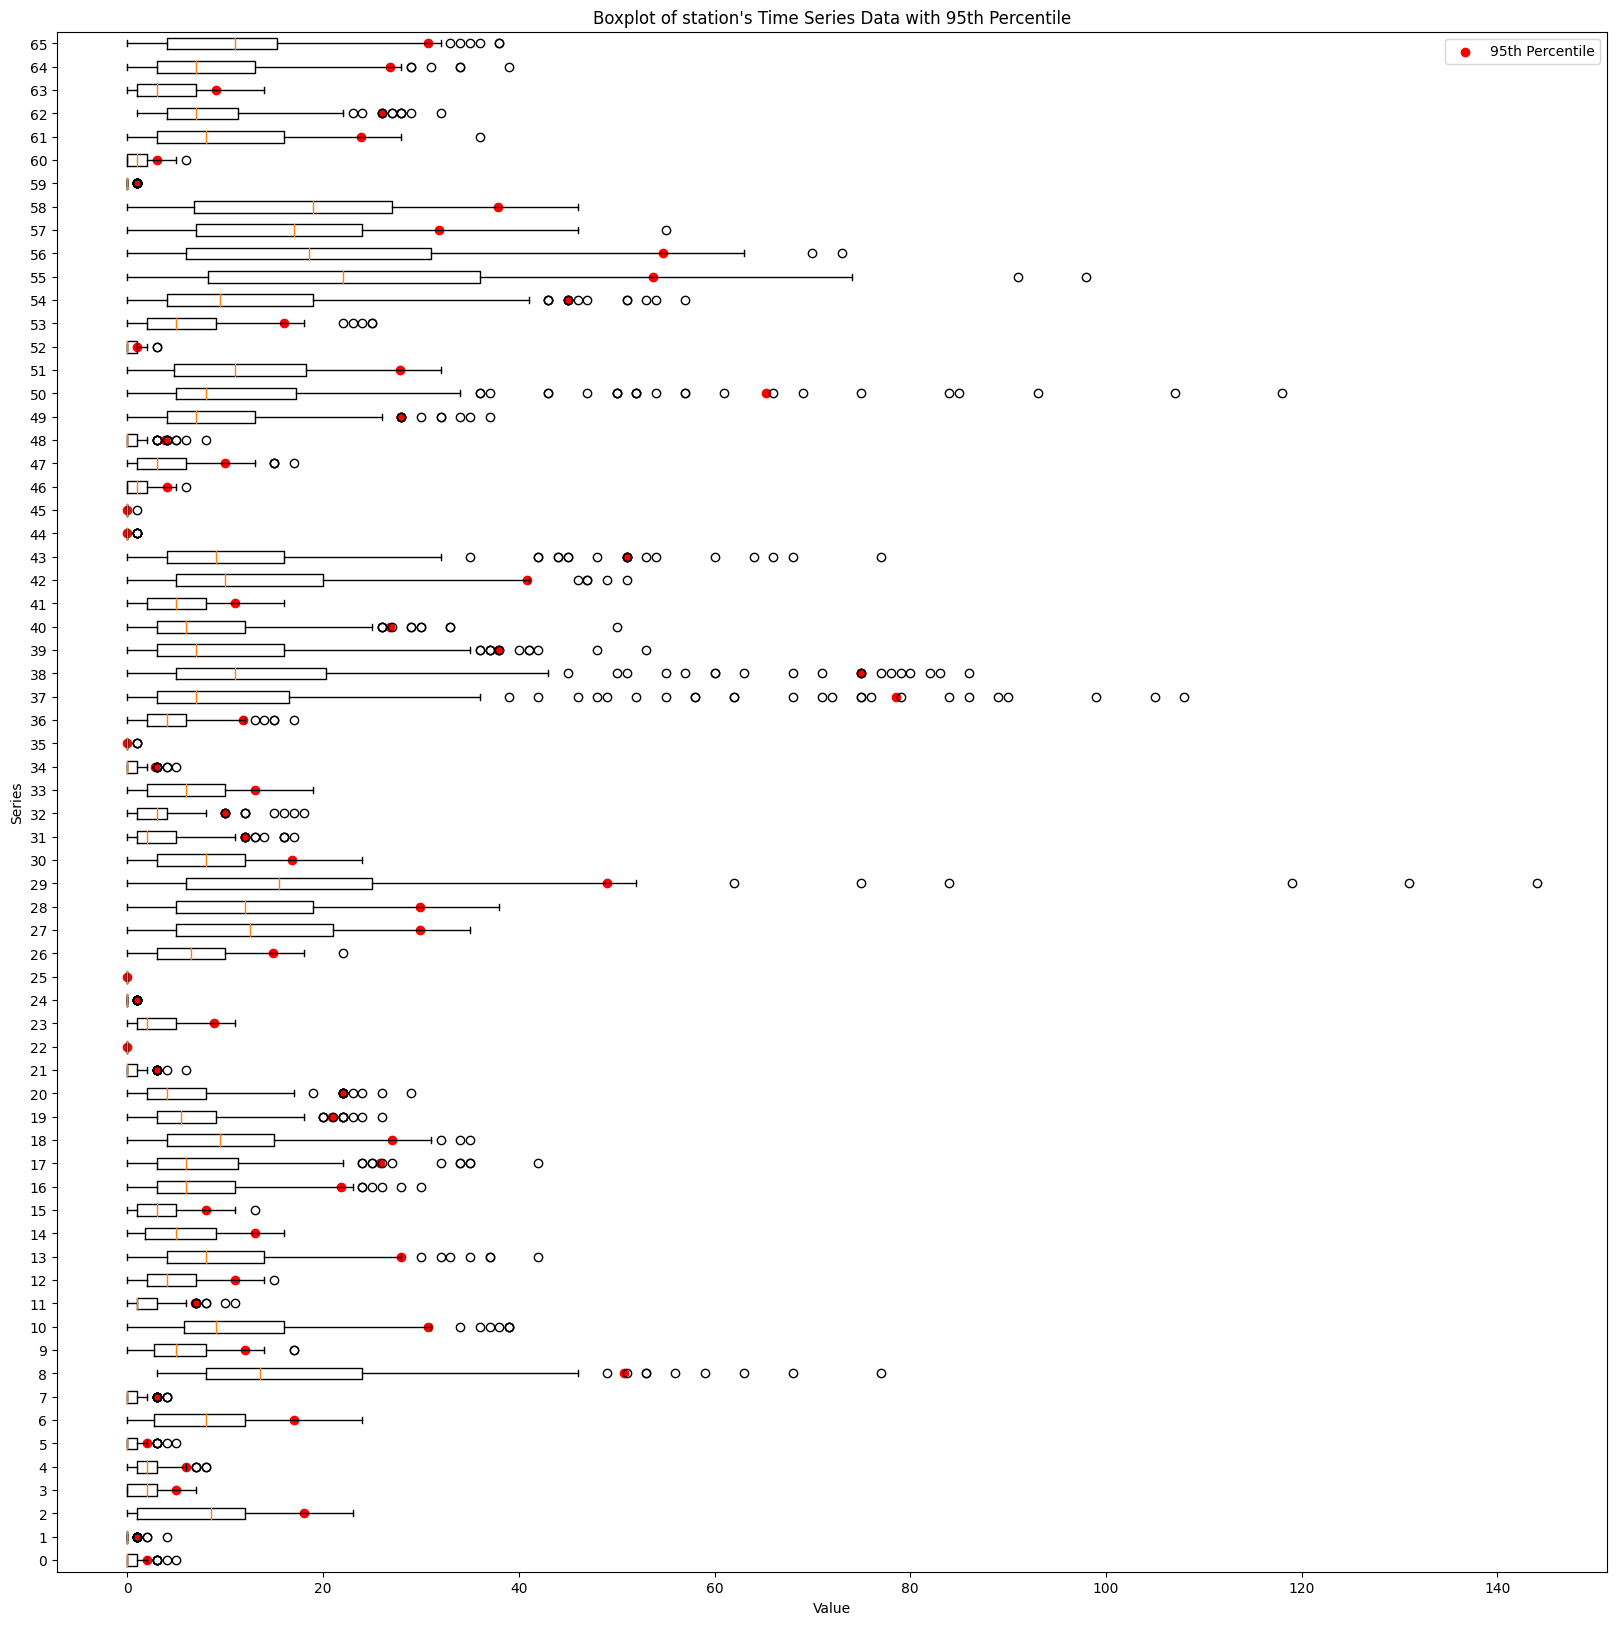

In [198]:
"""
Exploratory data analysis: Check if n95 is different from Max and that it lies within the IQR of most stations.
"""
df = manhat_demand
# df = df.drop(columns=['week','hour','weekday'])
percentiles_95 = df.quantile(0.95)
num_series = len(df.columns)

plt.figure(figsize=(20, 20))
plt.boxplot(df, positions=np.arange(num_series), vert=False)
plt.scatter(percentiles_95, np.arange(num_series), color='red', marker='o', label='95th Percentile')
plt.yticks(np.arange(num_series), df.columns)
plt.xlabel('Value')
plt.ylabel('Series')
plt.title("Boxplot of station's Time Series Data with 95th Percentile")
plt.legend()
plt.show()


In [199]:
manhattan_zones = pd.read_csv('manhattan_zones.csv')

zone_to_gps_dict = {}

for i in manhattan_zones.index:
    lat = manhattan_zones.iloc[i]['lat']
    lng = manhattan_zones.iloc[i]['lng']
    zone_to_gps_dict[i] = (lat,lng)


In [200]:
# def feature_standardization(X_train):
#     # ensure that features of different scale are comparable using euclidean distance
#     X_train_Df = pd.DataFrame(X_train)
#     X_train_normalized =(X_train_Df-X_train_Df.mean())/X_train_Df.std()
#     X_train_normalized = X_train_normalized.fillna(0)
#     return X_train_normalized.to_numpy()

class feat_transformation():
    def __init__(self,):
        return
    def feature_normalization(self,X_train):
        # ensure that features of different scale are comparable using euclidean distance
        self.scaler = MinMaxScaler() #StandardScaler()
        self.scaler.fit(X_train)
        X_train_normalized = self.scaler.transform(X_train)
        return X_train_normalized

    def inv_feature_normalization(self,X_train_normalized):
        # ensure that features of different scale are comparable using euclidean distance
        X_train = self.scaler.inverse_transform(X_train_normalized)
        return X_train


In [201]:
## Visualize the clustered time series


def plot_stations_of_clusters(labels, df,TS_type,X_train,X_train_inv_normalized,plot_type,angular_labels,plot_title,mother_wavelet,limit_level):
    unique_clusters = np.unique(labels)
    num_clusters = len(unique_clusters)
    cluster_to_stations_dict = { l: [] for l in unique_clusters}

    cols = df.columns
    station_to_index_dict = {}
    index=0
    if isinstance(cols[index], tuple): # differentiate between Dim_Red_unmet_60min_outflow_week_df DF and unmet_60min_outflow_df DF
      for stn in cols: # station to index mapping
        station_to_index_dict[stn[0]] = index
        index+=1
    else:
      for stn in cols: # station to index mapping
        station_to_index_dict[stn] = index
        index+=1

    idx=0
    if isinstance(cols[idx], tuple): # differentiate between Dim_Red_unmet_60min_outflow_week_df DF and unmet_60min_outflow_df DF
      for l in labels:
        cluster_to_stations_dict[l].append(cols[idx][0])
        idx+=1
    else:
      for l in labels:
        cluster_to_stations_dict[l].append(cols[idx])
        idx+=1

    #shapefile_data = gpd.read_file('NYC Taxi Zones (1)/taxi_zones.shp',)

    num_features = X_train.shape[1]
    all_cluster_feat_mins = np.array([])
    all_cluster_feat_maxs = np.array([])

    ################## par coords plot ##################
    if(plot_type == 'par_coords'): # parallel coordinates
        for key in cluster_to_stations_dict.keys():

          #fig0, ax0 = plt.subplots()
          #shapefile_data.plot(ax=ax0,edgecolor='black', linewidth=0.9, color='lightblue',figsize=(5,5))

          #fig = go.Figure()
          #fig1 = go.Figure()
          fig2, ax2 = plt.subplots(figsize=(30,5))
          #fig3, ax3 = plt.subplots(figsize=(60,5))
          fig4, ax4 = plt.subplots(figsize=(30,5))

          color_feature = 0  # The feature index to use for colors
          color_map = get_cmap('tab20')  # Choose a colormap

          d = {}

          feat_min_per_cluster = [1000]*num_features
          feat_max_per_cluster = [-1000]*num_features

          cluster_data = []
          cluster_stns_gps_coords = []

          for station in cluster_to_stations_dict[key]:
            #ax0.scatter(zone_to_gps_dict[int(station)][0], zone_to_gps_dict[int(station)][1], color='red', marker='.')

            cluster_stns_gps_coords.append(zone_to_gps_dict[int(station)])

            #y_arr = np.array(df[station].values).reshape(-1)
            # fig = fig.add_trace(go.Scatter(x=np.arange(len(y_arr)), y=y_arr,mode='lines+markers',name=station))
            # fig.update_layout(title='cluster: '+ str(key),xaxis_title="time (Monday 0:00 - Sunday 23:00)",
            # yaxis_title=TS_type,autosize=False,width=1800,height=400, )

            # wave_coeffs = pywt.wavedec( df[station] , mother_wavelet, level=limit_level)
            # rec_wave = pywt.waverec(wave_coeffs, mother_wavelet)
            # ym = np.median(rec_wave)
            # ax3.plot(np.linspace(0, 1., num=len(rec_wave)), rec_wave-ym)
            # #ax3.plot(df[station])

            d['r'] = X_train[station_to_index_dict[station]]
            # d['theta'] = angular_labels
            # fig1.add_trace(go.Scatterpolar(
            #     r=d['r'],
            #     theta=d['theta'],
            #     fill='toself',name=station,
            # ))

            sample = X_train[station_to_index_dict[station]]  # Get the current sample
            color = color_map(sample[color_feature])  # Get the color based on the color feature value
            ax2.plot(range(num_features), sample, color=color, alpha=0.7, label=station)

            #unnormalized features
            sample1 = X_train_inv_normalized[station_to_index_dict[station]]  # Get the current sample
            cluster_data.append(sample1)

            # histogram and kernel density estimate
            sns.histplot(data=df[station].values, kde=False, stat="count", ax=ax4)
            ax5 = ax4.twinx()
            sns.kdeplot(data=df[station].values, ax=ax5)

            for f in range(num_features):
                feat_min_per_cluster[f] = min(feat_min_per_cluster[f],sample[f])
                feat_max_per_cluster[f] = max(feat_max_per_cluster[f],sample[f])

          all_cluster_feat_mins = np.append(all_cluster_feat_mins,np.array(feat_min_per_cluster))
          all_cluster_feat_maxs = np.append(all_cluster_feat_maxs,np.array(feat_max_per_cluster))

          cluster_data = np.array(cluster_data)

          # fig1.update_layout(title='cluster: '+ str(key),
          #     polar=dict(
          #         radialaxis=dict(visible=True,))#range=[-2, 7]))
          #     ,height=800,width=800,
          #     showlegend=True
          # )
          # fig1.show()

          # Create a map centered on the coordinates of interest
          map_center = [40.7831, -73.9712]  # Manhattan coordinates (latitude, longitude)
          map_zoom = 13  # Adjust the zoom level as needed
          my_map = folium.Map(location=map_center, zoom_start=map_zoom,width='40%', height='40%')
          for coord in cluster_stns_gps_coords:
              folium.Marker(location=coord).add_to(my_map)
          # Display the map
          display(my_map)

          # ax0.set_xlabel('Longitude')
          # ax0.set_ylabel('Latitude')
          # ax0.set_title('manhattan zones of cluster: '+ str(key))
          # fig0.show()

          #fig.show()

          ax2.set_xticks(range(num_features))
          ax2.set_xticklabels([i for i in angular_labels])
          ax2.set_ylabel('Normalized Value')
          #ax2.set_ylim(0, 1)  # Modify as needed
          ax2.set_title(plot_title+', cluster: '+str(key)+' has '+str(len(cluster_to_stations_dict[key]))+' stations')
          ax2.grid(True, linestyle='--')
          #fig2.tight_layout()
          fig2.show()

          # #ax3.set_xticklabels([i for i in unmet_60min_outflow_df.index])
          # plt.xticks(rotation=90)
          # ax3.set_ylabel('Low frequency, '+'level: '+ str(limit_level) + ', '+ mother_wavelet +' Wavelet reconstruction')
          # #ax3.set_ylim(0, 1)  # Modify as needed
          # ax3.set_title(plot_title+', cluster: '+str(key)+' has '+str(len(cluster_to_stations_dict[key]))+' stations')
          # #ax3.legend()
          # ax3.grid(True, linestyle='--')
          # #fig3.tight_layout()
          # fig3.show()


          cluster_df = pd.DataFrame(cluster_data, columns=angular_labels)
          cluster_df['sample'] = range(len(cluster_df))
          fig6 = px.parallel_coordinates(cluster_df,color='sample',color_continuous_scale="picnic",dimensions=cluster_df.columns[:-1],)
          fig6.update_layout(
              plot_bgcolor='black',  # Set the background color to black
              paper_bgcolor='black',  # Set the plot area background color to black
              font_color='white',  # Set the font color to white for better visibility
              title='unnormalized features of cluster: '+str(key) )
          fig6.show()

          # fig7 = go.Figure(go.Parcoords(
          #     line=dict(color=cluster_data[:, 0], showscale=True),
          #     dimensions=[dict(range=[min(cluster_data[:, i]), max(cluster_data[:, i])], label=l, values=cluster_data[:, i]) for i,l in zip( range(len(angular_labels)),angular_labels)],
          # ))
          # fig7.update_layout(title='unnormalized stats features', coloraxis_colorbar=dict(title='Color'))
          # fig7.show()

          ax4.set_xlabel('Demand value')
          ax4.set_ylabel('Density/Frequency')
          ax4.set_title('station''s Kernel Density Plots of cluster: '+str(key))
          ax4.legend()
          fig4.show()

          print('Number of stations in cluster '+ str(key)+' : ', len(cluster_to_stations_dict[key]))
          print('Stations in cluster: ',cluster_to_stations_dict[key])
    ################## par coords plot ##################


    ################## polar plot ##################

    elif(plot_type == 'polar'):
        angular_labels = [ str(l) for l in range( X_train.shape[1] )]
        for key in cluster_to_stations_dict.keys():
          fig0, ax = plt.subplots(figsize=(10,5))
          shapefile_data.plot(ax=ax,edgecolor='black', linewidth=0.9, color='lightblue',figsize=(5,5))

          #fig = go.Figure()
          fig1 = go.Figure()

          d = {}

          feat_min_per_cluster = [1000]*num_features
          feat_max_per_cluster = [-1000]*num_features

          for station in cluster_to_stations_dict[key]:
            ax.scatter(zone_to_gps_dict[int(station)][0], zone_to_gps_dict[int(station)][1], color='red', marker='.')

            y_arr = np.array(df[station].values).reshape(-1)
            # fig = fig.add_trace(go.Scatter(x=np.arange(len(y_arr)), y=y_arr,mode='lines+markers',name=station))
            # fig.update_layout(title='cluster: '+ str(key),xaxis_title="time (Monday 0:00 - Sunday 23:00)",
            # yaxis_title=TS_type,autosize=False,width=1800,height=400, )

            d['r'] = X_train[station_to_index_dict[station]]
            d['theta'] = angular_labels
            fig1.add_trace(go.Scatterpolar(
                r=d['r'],
                theta=d['theta'],
                fill='toself',name=station,
            ))

            sample = X_train[station_to_index_dict[station]]  # Get the current sample
            for f in range(num_features):
                feat_min_per_cluster[f] = min(feat_min_per_cluster[f],sample[f])
                feat_max_per_cluster[f] = max(feat_max_per_cluster[f],sample[f])

          all_cluster_feat_mins = np.append(all_cluster_feat_mins,np.array(feat_min_per_cluster))
          all_cluster_feat_maxs = np.append(all_cluster_feat_maxs,np.array(feat_max_per_cluster))

          fig1.update_layout(title='cluster: '+ str(key),
              polar=dict(
                  radialaxis=dict(visible=True,))#range=[-2, 7]))
              ,height=1000,width=1000,
              showlegend=True
          )

          ax.set_xlabel('Longitude')
          ax.set_ylabel('Latitude')
          ax.set_title('Singapore Stations of cluster '+ str(key))
          fig0.show()
          #fig.show()
          fig1.show()

          print('Number of stations in cluster '+ str(key)+' : ', len(cluster_to_stations_dict[key]))
          print('Stations in cluster: ',cluster_to_stations_dict[key])
    ################## polar plot ##################
    else:
        raise ValueError('only par_coords or are polar allowed')

    all_cluster_feat_mins = np.hstack(all_cluster_feat_mins)
    all_cluster_feat_maxs = np.hstack(all_cluster_feat_maxs)
    print(all_cluster_feat_mins)
    return cluster_to_stations_dict,all_cluster_feat_mins,all_cluster_feat_maxs

#plot_stations_of_clusters(km.labels_, Dim_Red_unmet_60min_outflow_week_df,'outflow')

def plot_silhouette_scores(X_train,labels,metric,linkage,clustering_type):
    unique_clusters = np.unique(labels)
    num_clusters = len(unique_clusters)
    sample_silhouette_values = silhouette_samples(X=X_train, labels=labels,metric=metric)
    silhouette_avg = silhouette_score(X=X_train, labels=labels,metric=metric)
    fig, ax1 = plt.subplots()
    y_lower = 10
    mean_num_zones_dev_in_clusters = []

    mean_num_zones_in_clusters = X_train.shape[0] /num_clusters

    for i in range(num_clusters): # exclude the
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / num_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
        mean_num_zones_dev_in_clusters.append(abs(mean_num_zones_in_clusters - np.sum(labels == i) ))

    ax1.set_title("metric: "+metric+", linkage: "+linkage+", silhouette_avg: "+str(silhouette_avg)+", num_clusters: "+str(num_clusters)+", Cluster_type : "+clustering_type )
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    num_neg_silhouette_scores = np.sum(sample_silhouette_values < 0 )
    min_silhouette_score = min(sample_silhouette_values)
    dev_from_mean_num_zone = np.sum(np.array(mean_num_zones_dev_in_clusters))
    return silhouette_avg, num_neg_silhouette_scores, min_silhouette_score,dev_from_mean_num_zone


def plot_cluster_representatives(X_train,all_cluster_feat_mins,all_cluster_feat_maxs,plot_type,angular_labels):
    num_features = X_train.shape[1]
    low_list =  all_cluster_feat_mins[num_features:] ## remove outlier cluster
    high_list = all_cluster_feat_maxs[num_features:] ## remove outlier cluster
    num_clusters = int(len(all_cluster_feat_mins[num_features:] )/num_features) ## remove outlier cluster
    color = cm.rainbow(np.linspace(0, 1, num_clusters))

    low = {}
    high = {}
    c = 0
    idx=0
    low[0] = []
    high[0] = []
    for l,h in zip(low_list,high_list):
        low[c].append(l)
        high[c].append(h)
        idx+=1
        if idx%num_features==0:
            c+=1
            low[c] = []
            high[c] = []


    if(plot_type == 'par_coords'): # parallel coordinates
        plt.close('all')

        #fig,ax = plt.subplots(figsize=(20,7))

        cluster_rep_arr = np.empty((num_clusters,num_features))
        adj=0
        for c in range(num_clusters):
            for f in range(num_features):
              cluster_rep_arr[c,f] = np.average([low[c][f],high[c][f]])
              #ax.plot([f+adj]*2,[low[c][f],high[c][f]],c=color[c],marker='*',label=str(c))
            adj += 0.05

        # ax.set_xticks(range(num_features))
        # ax.set_xticklabels([i for i in angular_labels])
        # ax.set_title('Representative points from each cluster for '+str(num_clusters) + ' clusters '+ 'excluding outlier cluster')
        # ax.set_xlabel('TS stats features')
        # ax.set_ylabel('Normalized value')
        # ax.grid(True, linestyle='--')
        # ax.legend()
        # fig.show()


        # ####### TREND statistical Features #######
        # cluster_rep_arr[:,4] = 1- cluster_rep_arr[:,4] # invert
        # cluster_rep_arr[:,5] = 1- cluster_rep_arr[:,5] # invert
        # cluster_rep_arr[:,6] = 1- cluster_rep_arr[:,6] # invert
        # angular_labels[4] = '(1 - norm zero counts)'
        # angular_labels[5] = '(1 - norm kurtosis)'
        # angular_labels[6] = '(1 - norm skewness)'
        # ####### TREND statistical Features #######


        df = pd.DataFrame(cluster_rep_arr, columns=angular_labels)
        df['sample'] = range(len(df))
        fig2 = px.parallel_coordinates(df,color='sample',color_continuous_scale="picnic",dimensions=df.columns[:-1],)
        fig2.update_layout(
            plot_bgcolor='black',
            paper_bgcolor='black',
            font_color='white',
            title='Representative points from each cluster. (excluding outlier cluster)'
        )
        fig2.show()


    elif(plot_type == 'polar'): # polar plot
        plt.close('all')
        angular_labels = [ str(l) for l in range( X_train.shape[1] )]

        cmap = cm.get_cmap('tab20c')
        colors = [mcolors.rgb2hex(cmap(i)[:3]) for i in range(num_clusters)]

        d = {}
        fig1 = go.Figure()

        for c in range(num_clusters):
            color = colors[c % num_clusters]
            d['r'] = low[c]
            d['theta'] = angular_labels
            fig1.add_trace(go.Scatterpolar(
                r=d['r'],
                theta=d['theta'],
                fill='toself',name=str(c)+'_low',
                line=dict(color=color),
            ))
            d['r'] = high[c]
            d['theta'] = angular_labels
            fig1.add_trace(go.Scatterpolar(
                r=d['r'],
                theta=d['theta'],
                fill='toself',name=str(c)+'_high',
                line=dict(color=color),
            ))

        fig1.update_layout(title='Representative DWT points from each cluster. (excluding outlier cluster)',
            polar=dict(
                radialaxis=dict(visible=True,))#range=[-2, 7]))
            ,height=1000,width=1000,
            showlegend=True,
        )
        fig1.show()
    return

def rank_clusterings(all_cluster_feat_mins,all_cluster_feat_maxs,num_clusters,num_features):

  all_cluster_feat_mins = all_cluster_feat_mins.reshape(num_clusters,num_features)
  all_cluster_feat_maxs = all_cluster_feat_maxs.reshape(num_clusters,num_features)

  mean_arr = np.empty((num_clusters,num_features))
  deviation_arr = np.empty((num_clusters,num_features))

  for c in range(num_clusters):
    for f in range(num_features):
      mean = np.mean((all_cluster_feat_mins[c,f],all_cluster_feat_maxs[c,f])) #ignore outlier cluster
      deviation = (all_cluster_feat_maxs[c,f] - all_cluster_feat_mins[c,f])/2
      mean_arr[c,f] = mean
      deviation_arr[c,f] = deviation

  deviation_arr = 1 - deviation_arr
  weights_arr = (deviation_arr.T / deviation_arr.sum(axis=1)).T
  mean_arr = mean_arr*weights_arr

  cluster_magnitudes = np.linalg.norm(mean_arr,2,axis=1)
  ranked_clusters = np.argsort(cluster_magnitudes)
  ranked_clusters = { i:r for i,r in enumerate(ranked_clusters)}
  return ranked_clusters



In [202]:

def compute_mahalanobis_dist_mat(X):
    # Calculate the covariance matrix
    cov_matrix = np.cov(X.T)
    reg_param = 0.01  # Regularization parameter
    # Calculate the inverse of the covariance matrix
    inv_cov_matrix = np.linalg.inv(cov_matrix + reg_param * np.eye(cov_matrix.shape[0]))
    #inv_cov_matrix = np.linalg.inv(cov_matrix)
    # Calculate the Mahalanobis distance matrix
    mahalanobis_dist_mat = distance.cdist(X, X, metric='mahalanobis', VI=inv_cov_matrix)
    return mahalanobis_dist_mat

In [203]:
class plot_all():
    def __init__(self,print_msg,X_train):
        self.print_msg = print_msg
        self.X_train = X_train
        return

    def plot_tSNE_2d(self,X_train,print_msg,ax,col):
        ## t-SNE
        plot_kwds = {'alpha' : 0.25, 's' : 10, 'linewidths':0}
        projection = TSNE(n_components=2).fit_transform(X_train)
        ax[col].scatter(*projection.T, **plot_kwds)
        ax[col].set_title('t-SNE, '+ print_msg)
        #plt.show()
        return ax

    def plot_UMAP_2d(self,X_train,print_msg):
        umap_2d = UMAP(n_components=2, init='random', random_state=0)
        proj_2d = umap_2d.fit_transform(X_train)
        fig = go.Scatter(
            x=proj_2d[:, 0],  # X-axis values
            y=proj_2d[:, 1],  # Y-axis values
            mode='markers',
            marker=dict(
                size=5,
                color=np.arange(len(X_train)),  # Color points based on a range of values (e.g., sample index)
                colorscale='Viridis',  # Choose a colorscale
                showscale=True  # Show the colorbar
            ), name=print_msg
        )
        #fig.update_layout(title=print, scene=dict(xaxis_title='Dimension 1', yaxis_title='Dimension 2', zaxis_title='Dimension 3'))
        return fig


    def plot_UMAP_3d(self,X_train,n_neighbors,min_dist,metric):
        umap_3d = UMAP(n_components=3,n_neighbors=n_neighbors,min_dist=min_dist,metric=metric, init='random', random_state=0)
        proj_3d = umap_3d.fit_transform(X_train)
        fig = go.Scatter3d(
            x=proj_3d[:, 0],  # X-axis values from the low-dimensional representation
            y=proj_3d[:, 1],  # Y-axis values from the low-dimensional representation
            z=proj_3d[:, 2],  # Z-axis values from the low-dimensional representation
            mode='markers',
            marker=dict(
                size=5,
                color=np.arange(len(X_train)),  # Color points based on a range of values (e.g., sample index)
                colorscale='Viridis',  # Choose a colorscale
                showscale=True  # Show the colorbar
            ),name=self.print_msg
        )
        #fig.show()
        return fig

    def plot_UMAP_interactive(self,n_neighbors,min_dist,metric):
        umap_3d = UMAP(n_components=3,n_neighbors=n_neighbors,min_dist=min_dist,metric=metric, init='random', random_state=0)
        proj_3d = umap_3d.fit_transform(self.X_train )
        x=proj_3d[:,0]
        y=proj_3d[:,1]
        z=proj_3d[:,2]
        # Create the figure and subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

        # Plot 1 - 2D Plot
        ax1.scatter(x, y,c=np.arange(len(self.X_train )))
        ax1.set_xlabel('X')
        ax1.set_ylabel('Y')
        ax1.set_title(self.print_msg)

        # Plot 2 - 3D Plot
        ax2 = fig.add_subplot(122, projection='3d')
        ax2.scatter(x, y, z, c=np.arange(len(self.X_train )))
        ax2.set_xlabel('X')
        ax2.set_ylabel('Y')
        ax2.set_zlabel('Z')
        ax2.set_title(self.print_msg)

        # Adjust the spacing between subplots
        plt.subplots_adjust(wspace=0.5)

        # Display the plot
        plt.show()
        return


    def plot_ISOMAP_2d(self,X_train,print_msg,n_neighbors=5):
        ## isomap
        # Create an instance of the Isomap class and specify the desired parameters
        n_components = 2  # Number of dimensions in the low-dimensional representation
        # Number of nearest neighbors used in constructing the neighborhood graph
        isomap = Isomap(n_components=n_components, n_neighbors=n_neighbors)
        # Fit the Isomap model to your data
        isomap_embedding = isomap.fit_transform(X_train)
        # Access the low-dimensional representation
        low_dim_data = isomap_embedding
        fig = go.Scatter(
            x=low_dim_data[:, 0],  # X-axis values
            y=low_dim_data[:, 1],  # Y-axis values
            mode='markers',
            marker=dict(
                size=5,
                color=np.arange(len(X_train)),  # Color points based on a range of values (e.g., sample index)
                colorscale='Viridis',  # Choose a colorscale
                showscale=True  # Show the colorbar
            ), name=print_msg
        )
        #fig.update_layout(title=print, scene=dict(xaxis_title='Dimension 1', yaxis_title='Dimension 2', zaxis_title='Dimension 3'))
        #fig.show()
        return fig

    def plot_ISOMAP_3d(self,X_train,print_msg,n_neighbors=5):
        ## isomap
        # Create an instance of the Isomap class and specify the desired parameters
        n_components = 3  # Number of dimensions in the low-dimensional representation
        n_neighbors = 5  # Number of nearest neighbors used in constructing the neighborhood graph
        isomap = Isomap(n_components=n_components, n_neighbors=n_neighbors)
        # Fit the Isomap model to your data
        isomap_embedding = isomap.fit_transform(X_train)
        # Access the low-dimensional representation
        low_dim_data = isomap_embedding
        # Create a 3D scatter plot using Plotly
        fig = go.Scatter3d(
            x=low_dim_data[:, 0],  # X-axis values from the low-dimensional representation
            y=low_dim_data[:, 1],  # Y-axis values from the low-dimensional representation
            z=low_dim_data[:, 2],  # Z-axis values from the low-dimensional representation
            mode='markers',
            marker=dict(
                size=5,
                color=np.arange(len(X_train)),  # Color points based on a range of values (e.g., sample index)
                colorscale='Viridis',  # Choose a colorscale
                showscale=True  # Show the colorbar
            ),name=print_msg
        )
        #fig.show()
        return fig

    def plot_hist_n_corr(self,X_train):
        X_train_df = pd.DataFrame(X_train)
        ######### histogram plot #########
        # check to see if any features are all zeros
        print(self.print_msg+' individual feature Histogram')
        X_train_df.hist(figsize=(10,10))
        plt.show()
        # ######### plot correlation #########
        # # perform dimensionality reduction by removing highly correlated features.
        X_train_df_corr = X_train_df.corr()
        X_train_corr = X_train_df_corr.to_numpy()
        fig, ax = plt.subplots(figsize=(15,15))
        cax = ax.matshow(X_train_corr, cmap='coolwarm')
        cbar = fig.colorbar(cax)
        # Loop over the data and add text annotations
        for i in range(X_train_corr.shape[0]):
            for j in range(X_train_corr.shape[1]):
                text = ax.text(j, i, f'{X_train_corr[i, j]:.3f}', ha='center', va='center')
        ax.set_title(self.print_msg+' features correlation matrix')
        plt.show()
        corr_threshold = 0.95 ## Warn multicollinearity
        if ((X_train_corr.any() >= corr_threshold) and (X_train_corr.shape[0] > 1) and (X_train_corr.any() <= 0.9999) ):
            warnings.warn("Warning: some correlation is higher than "+str(corr_threshold))
        h = np.histogram(X_train_df.dropna())
        if  ( ( (  np.count_nonzero(h[0]) ) / h[0].shape[0]) < (1/3)):
            warnings.warn("Warning: highly skewed feature, (provies no information!) ")
        return

In [204]:
h = np.histogram(np.array([2,5,4,6,4,7,1,2,3]))



In [205]:
"""                                                                     FEATURE Extraction
Feature extracted: Interpretable Time series statistical features

1) High/Low average demand for each day of 7 days


"""

def select_days_in_dataframe(df,days_type='all_days'):
    if days_type == 'all_days':
        return df
    elif days_type == 'week_days':
        df = df[ (df['weekday'] == 'Monday' ) | (df['weekday'] == 'Tuesday' ) | (df['weekday'] == 'Wednesday' ) | (df['weekday'] == 'Thursday' ) ]
        return df
    elif days_type == 'week_ends':
        df = df[ (df['weekday'] == 'Friday' ) | (df['weekday'] == 'Saturday' ) | (df['weekday'] == 'Sunday' ) ]
        return df
    else:
      raise ValueError('Must be one of the 3: ""all_days"" or ""week_days"" or ""week_ends""')


#######################################################################################################################
""" TREND STATISTICAL FEATURES functions"""
def calculate_mean_crossings(list_values):
    mean_crossing_indices = np.nonzero(np.diff(np.array(list_values) >= np.nanmean(list_values)))[0]
    no_mean_crossings = len(mean_crossing_indices)
    return no_mean_crossings

def calculate_max_deviation_from_n95(list_values):
    return np.max(list_values) - np.percentile(list_values,0.95)

def calculate_zero_demands(list_values):
    return np.where(list_values==0)[0].size

def median_of_lists(list_of_lists):
    combined_lists  = np.array([sublist for sublist in list_of_lists])
    medians = np.median(combined_lists,axis=0)
    return medians

def no_mean_crossing_demand(df):
    return df.apply(calculate_mean_crossings,axis=0)

def average_demand(df):
    #use this method instead of sample mean over all sundays. because as sample increases mean goes to zero
    return df.mean(axis=0)

def peak_n95_demand(df):
    return df.quantile(q=0.95,axis=0)

def max_demand(df):
    return df.max(axis=0)

def outlier_demands(df):
    return df.apply(calculate_max_deviation_from_n95,axis=0)

def count_zero_demands(df):
    return df.apply(calculate_zero_demands,axis=0)

def kurt_of_demands(df):
    return df.apply(stats.kurtosis,axis=0)

def skew_of_demands(df):
    return df.skew(axis=0)

def total_demands(df):
    return df.sum(axis=0)

## all are zero ##
# def mode_demands(df):
#     df = df.drop(columns=['week','hour','weekday'])
#     print(df.mode(axis=0))
#     return df.mode(axis=0)

def range_demands(df):
    return df.max(axis=0) - df.min(axis=0)
""" TREND STATISTICAL FEATURES functions"""
#######################################################################################################################



#######################################################################################################################
""" SEASONALITY STATISTICAL FEATURES functions"""

def std_demand(df):
    return df.std(axis=0)

def calculate_entropy(list_values):
    counter_values = Counter(list_values).most_common()
    probabilities = [elem[1]/len(list_values) for elem in counter_values]
    entropy= stats.entropy(probabilities)
    return entropy

def entropy_demands(df):
    return df.apply(calculate_entropy,axis=0)

def calculate_positive_peak_autocorrelation_of_demand(list_values):
    view_lags = len(list_values)
    feat_len = 5
    acf1 = acf(list_values, nlags=view_lags)
    peak_idx_high = np.array((find_peaks(acf1,height=(-0.7,0.7))[0]),dtype=int)
    x = list(range(0,len(acf1)))
    signific_high_idx = np.where(acf1[peak_idx_high] > 1.96/np.sqrt(len(x)))
    positive_autocorr_lags = peak_idx_high[signific_high_idx][:feat_len]
    positive_autocorr_lags = np.concatenate((positive_autocorr_lags,np.zeros(feat_len-len(positive_autocorr_lags))))
    return list(positive_autocorr_lags)

def calculate_negative_peak_autocorrelation_of_demand(list_values):
    view_lags = len(list_values)
    feat_len = 5
    acf1 = acf(list_values, nlags=view_lags)
    peak_idx_low = np.array((find_peaks(-1*acf1,height=(-0.7,0.7))[0]),dtype=int)
    x = list(range(0,len(acf1)))
    signific_low_idx = np.where(acf1[peak_idx_low] < (-1*1.96)/np.sqrt(len(x)))
    negative_autocorr_lags = peak_idx_low[signific_low_idx][:feat_len]
    negative_autocorr_lags = np.concatenate((negative_autocorr_lags,np.zeros(feat_len-len(negative_autocorr_lags))))
    return list(negative_autocorr_lags)

# def calculate_positive_peak_partial_autocorrelation_of_demand(list_values):
#     view_lags = int(len(list_values)/2) - 1
#     feat_len = 10
#     pacf1 = pacf(list_values, nlags=view_lags)
#     peak_idx_high = np.array((find_peaks(pacf1,height=(-0.7,0.7))[0]),dtype=int)
#     x = list(range(0,len(pacf1)))
#     signific_high_idx = np.where(pacf1[peak_idx_high] > 1.96/np.sqrt(len(x)))
#     positive_partial_autocorr_lags = peak_idx_high[signific_high_idx][:feat_len]
#     positive_partial_autocorr_lags = np.concatenate((positive_partial_autocorr_lags,np.zeros(feat_len-len(positive_partial_autocorr_lags))))
#     return list(positive_partial_autocorr_lags)

# def calculate_negative_peak_partial_autocorrelation_of_demand(list_values):
#     view_lags = int(len(list_values)/2) - 1
#     feat_len = 10
#     pacf1 = pacf(list_values, nlags=view_lags)
#     peak_idx_low = np.array((find_peaks(-1*pacf1,height=(-0.7,0.7))[0]),dtype=int)
#     x = list(range(0,len(pacf1)))
#     signific_low_idx = np.where(pacf1[peak_idx_low] < (-1*1.96)/np.sqrt(len(x)))
#     negative_partial_autocorr_lags = peak_idx_low[signific_low_idx][:feat_len]
#     negative_partial_autocorr_lags = np.concatenate((negative_partial_autocorr_lags,np.zeros(feat_len-len(negative_partial_autocorr_lags))))
#     return list(negative_partial_autocorr_lags)

def demands_positive_autocorr_lags(df):
    #df['Date'] = df.index
    daily_pos_autocorr_lags = df.apply(calculate_positive_peak_autocorrelation_of_demand, axis=0)
    return daily_pos_autocorr_lags.values.T

def demands_negative_autocorr_lags(df):
    #df['Date'] = df.index
    daily_neg_autocorr_lags = df.apply(calculate_negative_peak_autocorrelation_of_demand, axis=0)
    return daily_neg_autocorr_lags.values.T

# def demands_positive_partial_autocorr_lags(df):
#     #df['Date'] = df.index
#     daily_pos_partial_autocorr_lags = df.apply(calculate_positive_peak_partial_autocorrelation_of_demand, axis=0)
#     return daily_pos_partial_autocorr_lags.values.T

# def demands_negative_partial_autocorr_lags(df):
#     #df['Date'] = df.index
#     daily_neg_partial_autocorr_lags = df.apply(calculate_negative_peak_partial_autocorrelation_of_demand, axis=0)
#     return daily_neg_partial_autocorr_lags.values.T

def fft_of_demand(df):
    stations = df.columns
    num_common_freq=180
    top_x_frequencies = 11
    freq_rounding_num = 6
    common_freq_set = set()
    X_train = np.empty(shape=(0,top_x_frequencies-1)) # removed dc

    for station in stations:
        # Perform the FFT on the data
        fft_result = np.fft.fft(df[station].values)
        # Compute the magnitudes of the FFT result
        fft_magnitudes = np.abs(fft_result)
        # Generate the corresponding frequency axis
        sampling_rate = 1.0  # Assuming a sampling rate of 1.0 (change as needed)
        frequency_axis = np.fft.fftfreq(len(fft_result), 1 / sampling_rate)
        positive_freq_indices = np.where(frequency_axis >= 0)

        """ TOP periods/frequencies in the time series"""
        # Sort the magnitudes and frequencies in descending order
        sorted_indices = np.argsort(fft_magnitudes[positive_freq_indices])[::-1]
        sorted_magnitudes = fft_magnitudes[positive_freq_indices][sorted_indices]
        sorted_frequencies = frequency_axis[positive_freq_indices][sorted_indices]
        # Select the top periods

        top_freq = sorted_frequencies[2:top_x_frequencies+1] # REMOVE dc/mean component
        top_periods = 1/top_freq
        top_periods = [round(p) for p in top_periods]
        #print(f'Top FFT periods in demand are : {top_periods}')
        X_train = np.vstack((X_train,top_periods))
    return X_train
""" SEASONALITY STATISTICAL FEATURES functions"""
#######################################################################################################################



' SEASONALITY STATISTICAL FEATURES functions'

avg_dem individual feature Histogram


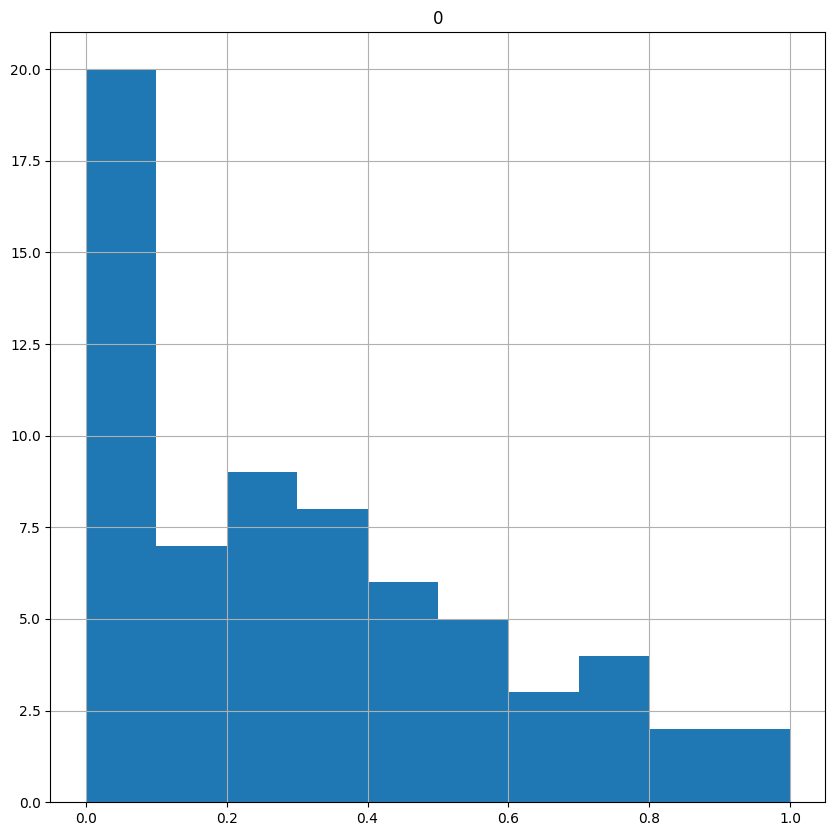

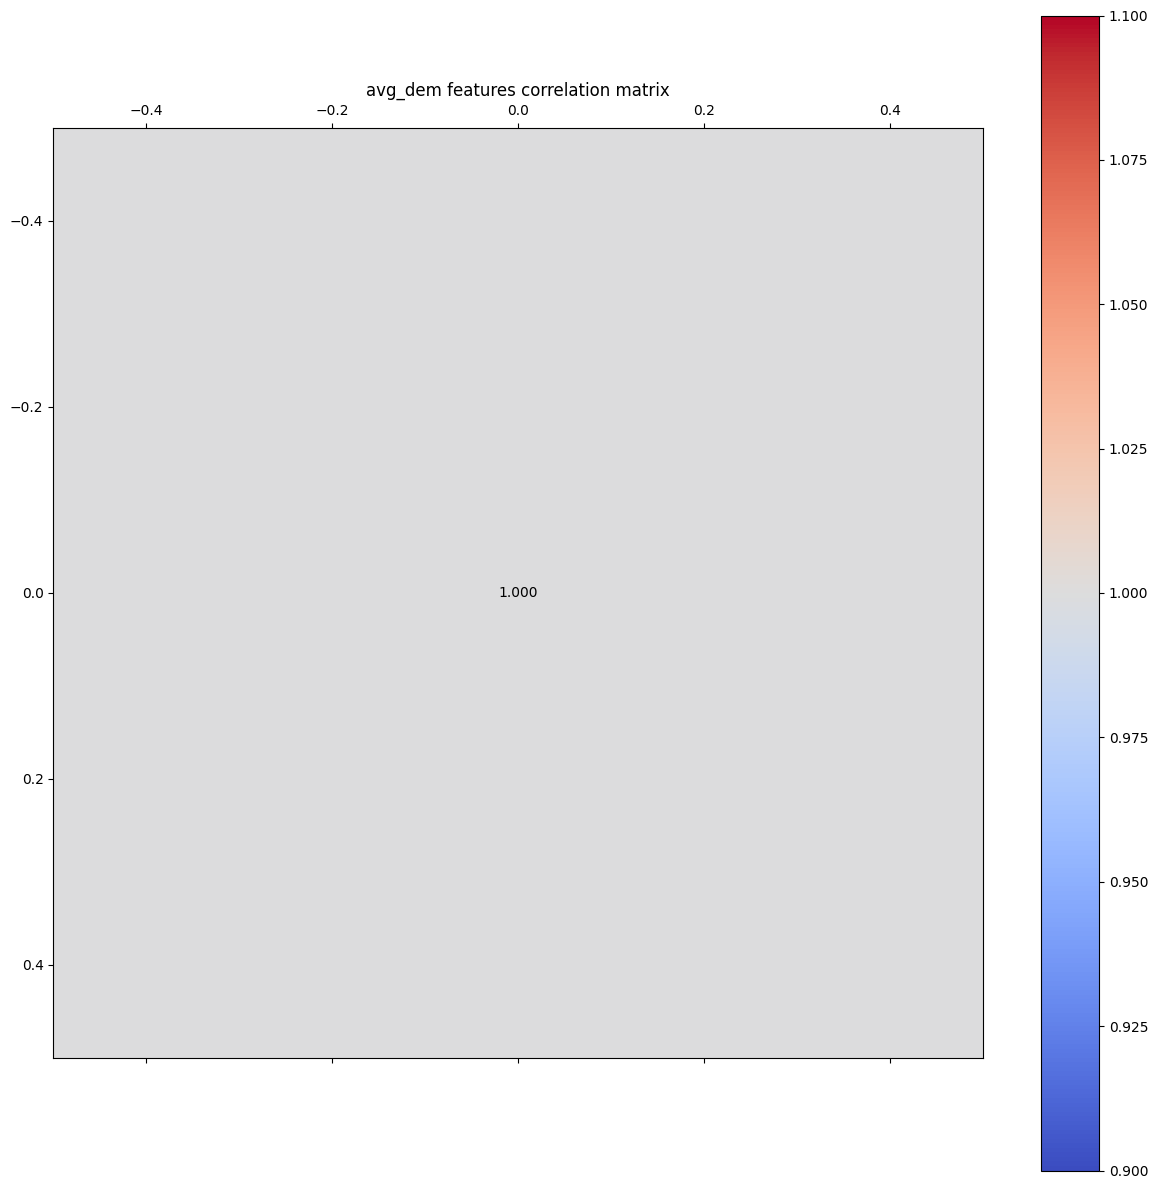

no_mean_crossing_dem individual feature Histogram


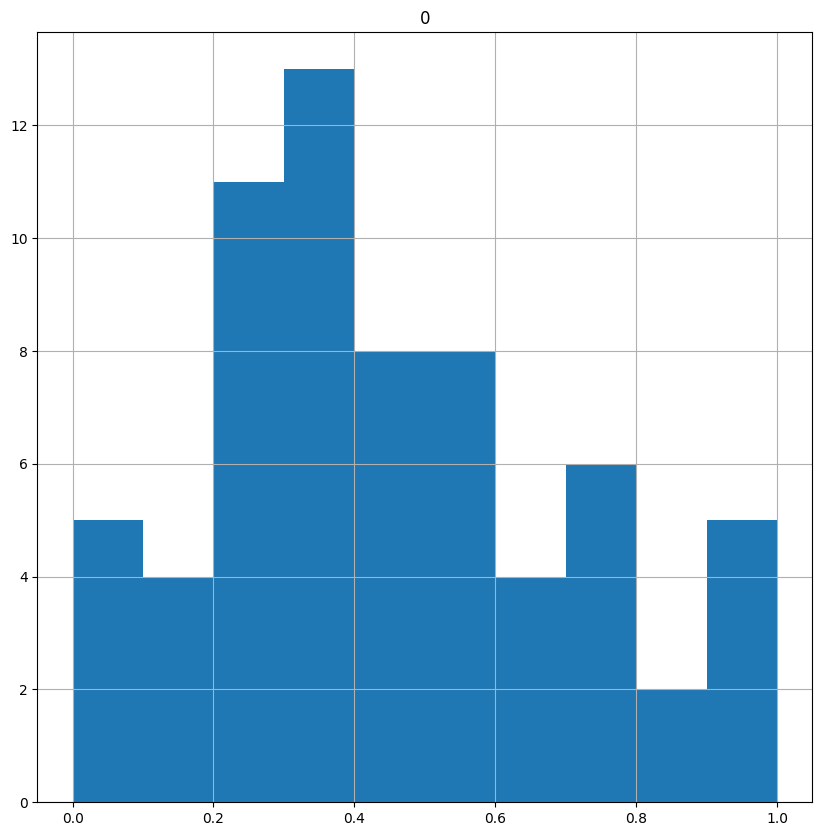

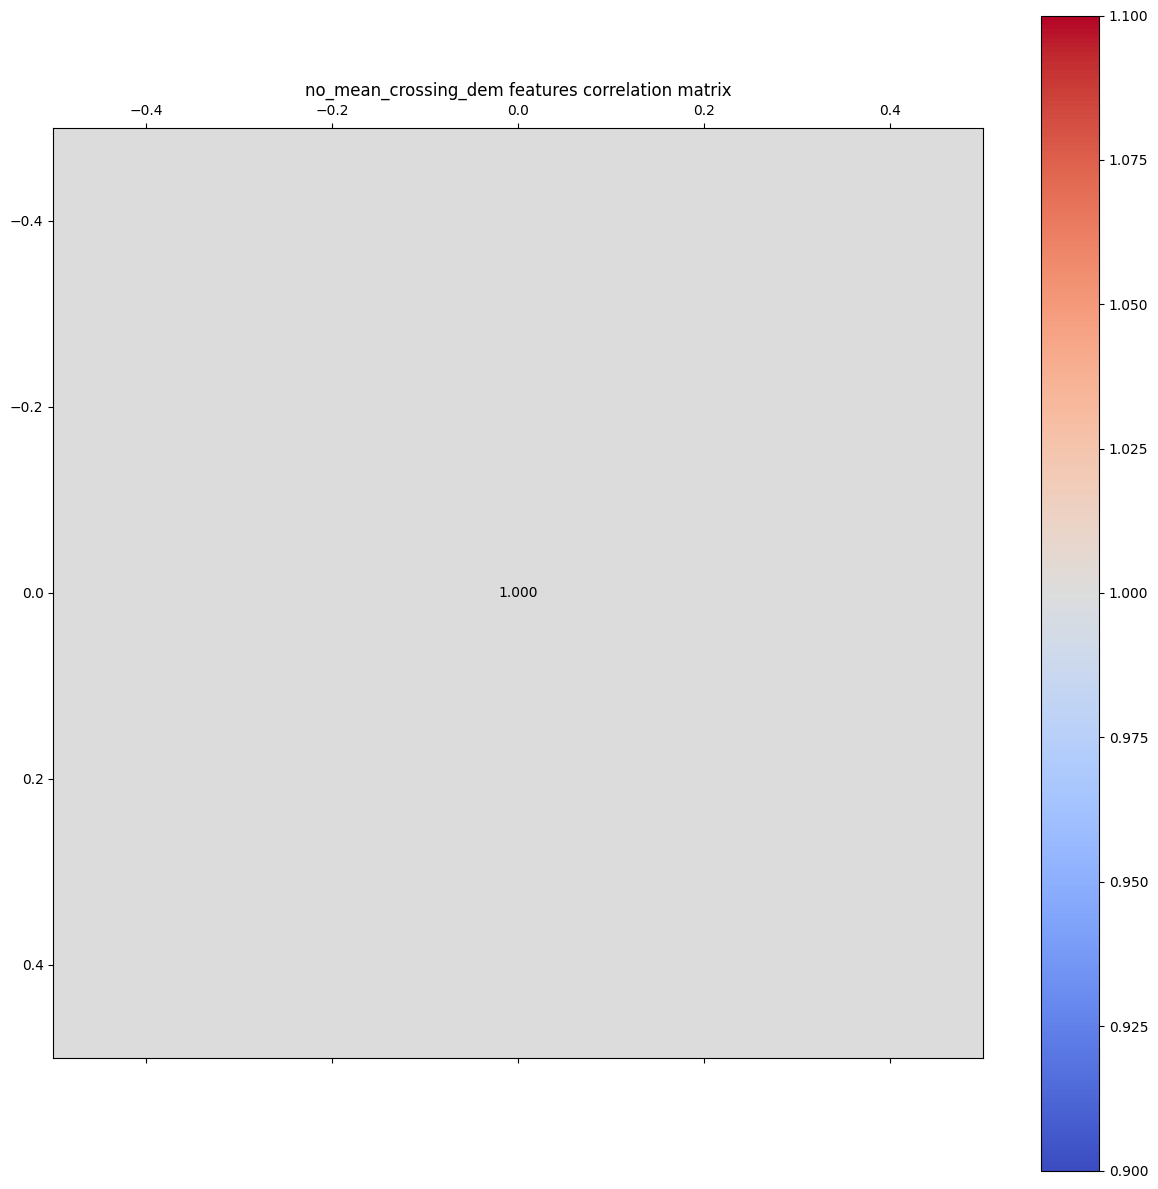

n95_dem individual feature Histogram


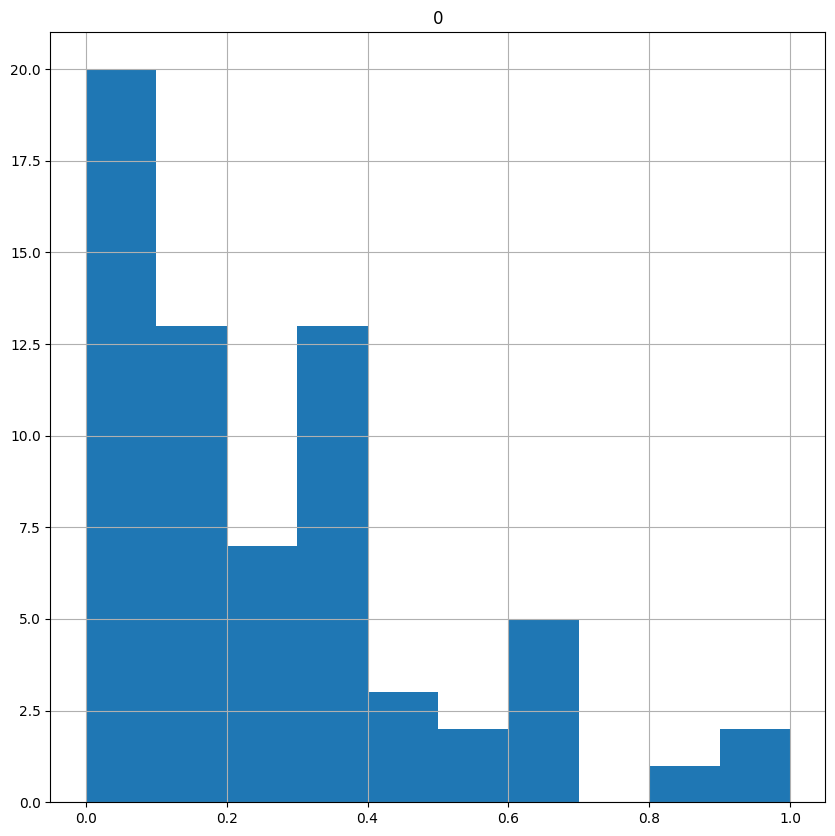

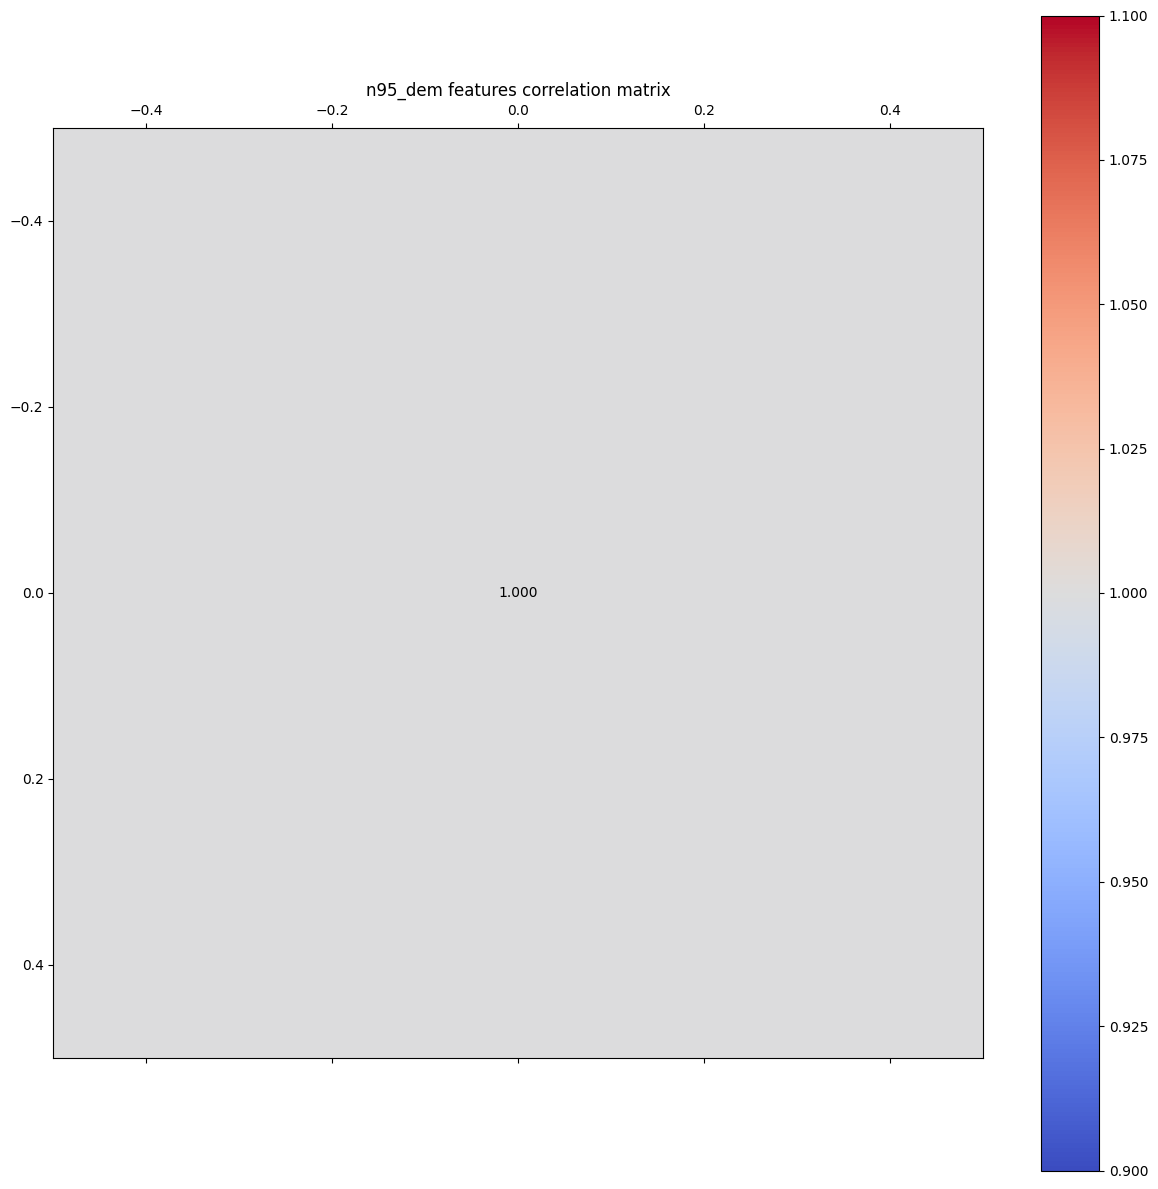

max_dem individual feature Histogram


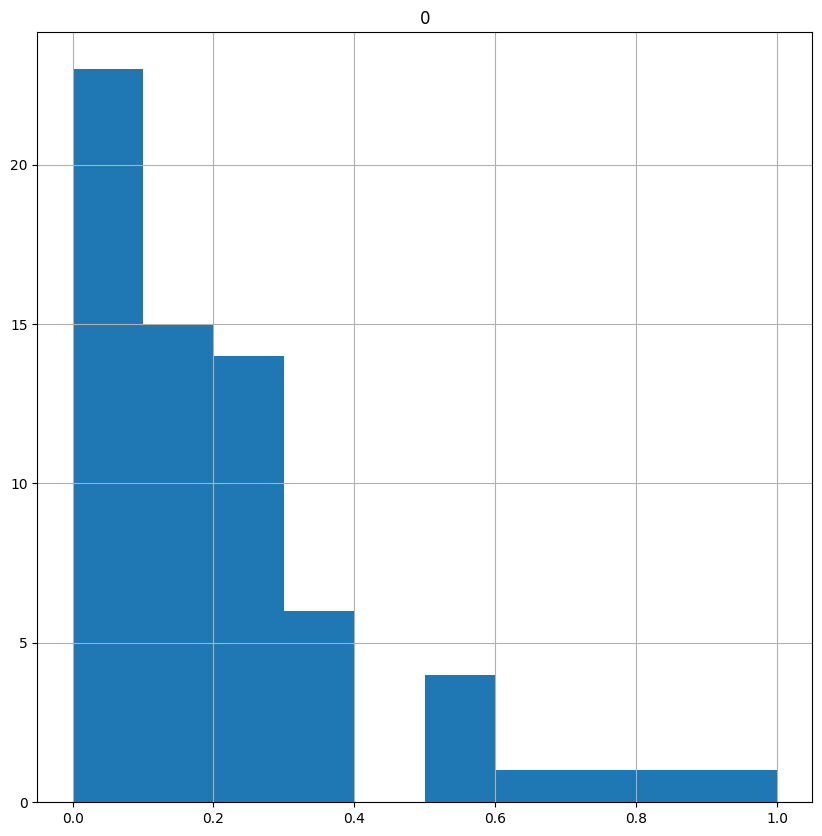

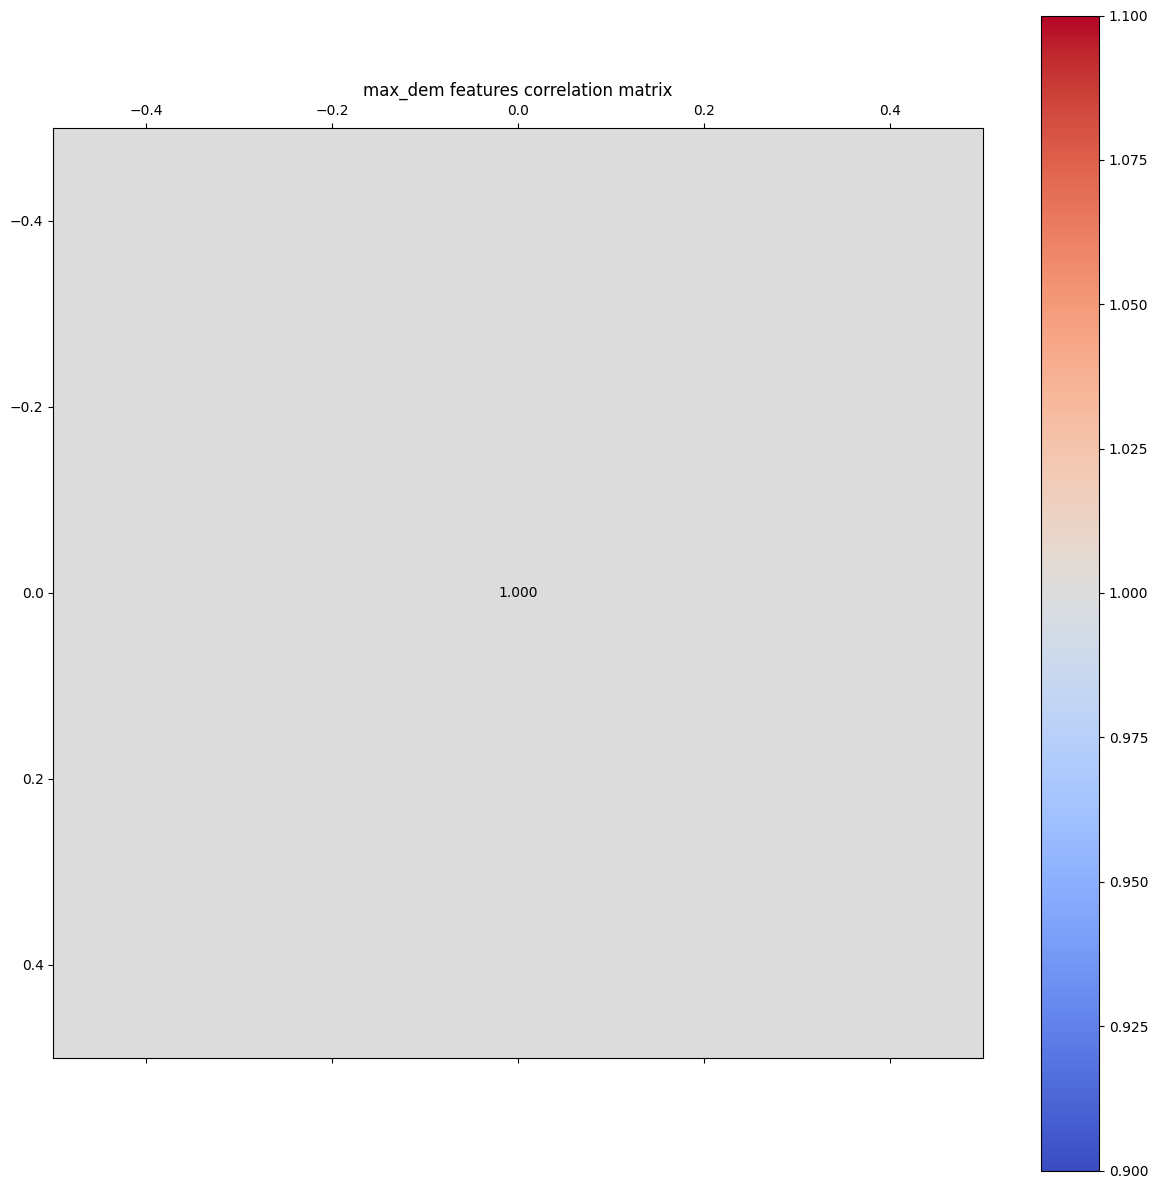

max_dev_from_n95_dem individual feature Histogram


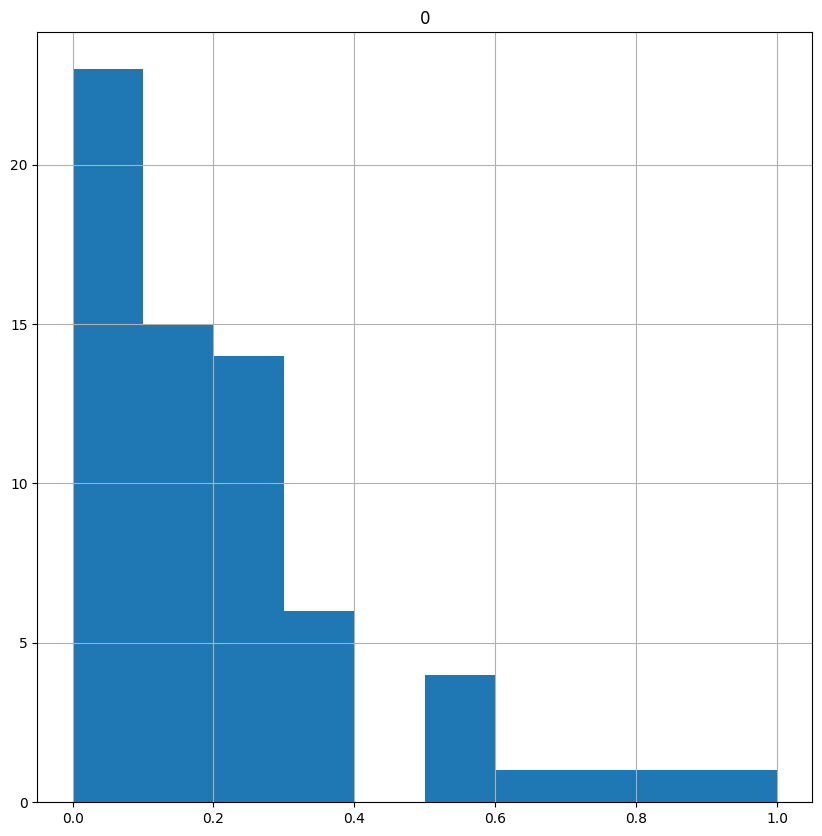

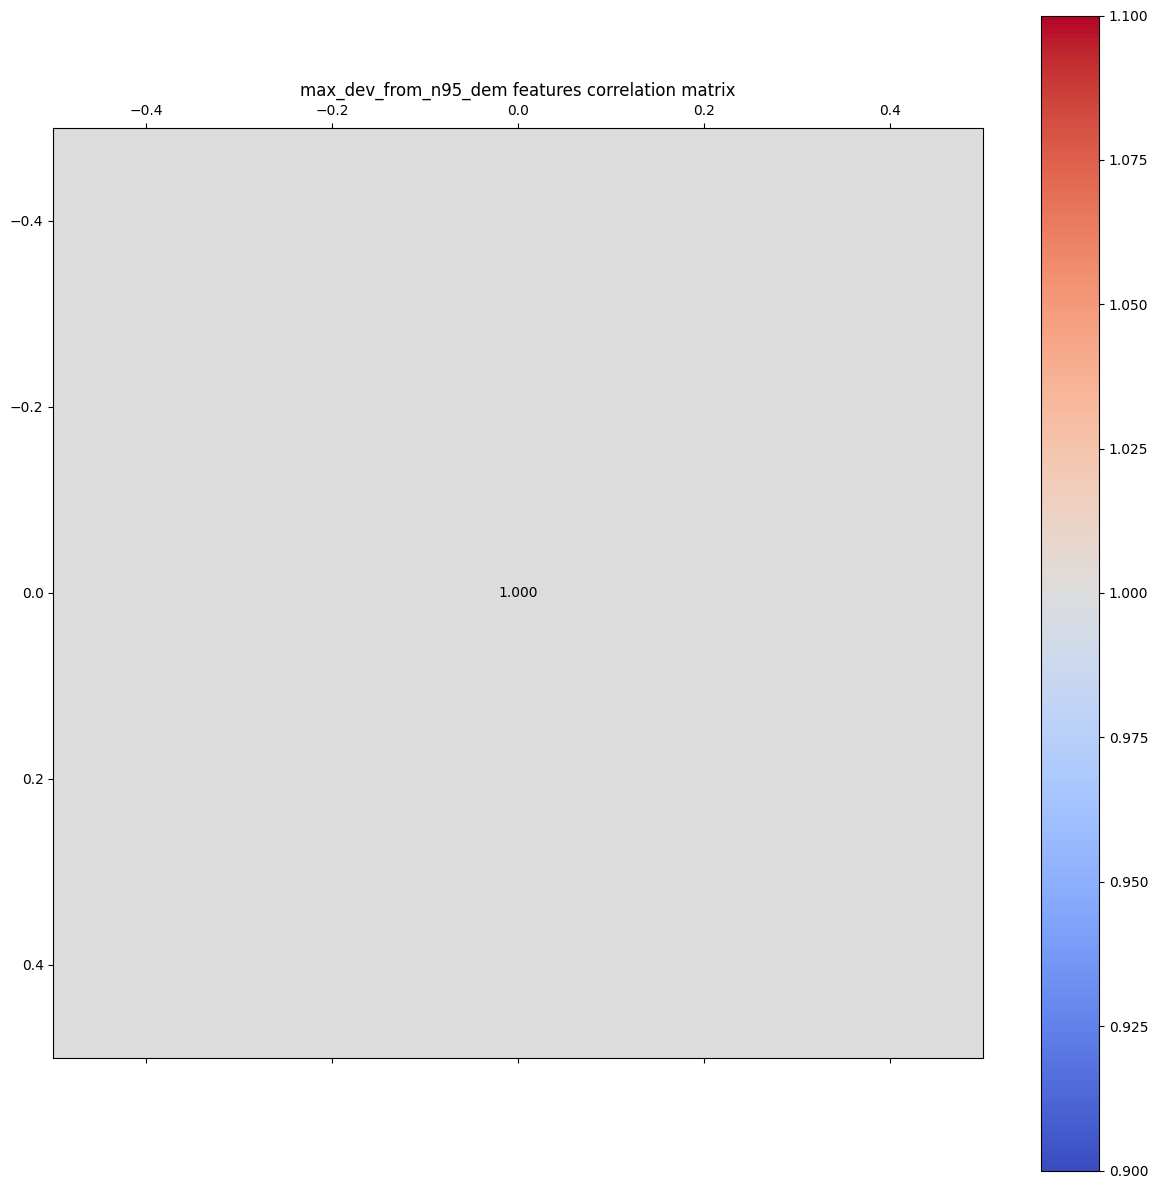

zero_dem individual feature Histogram


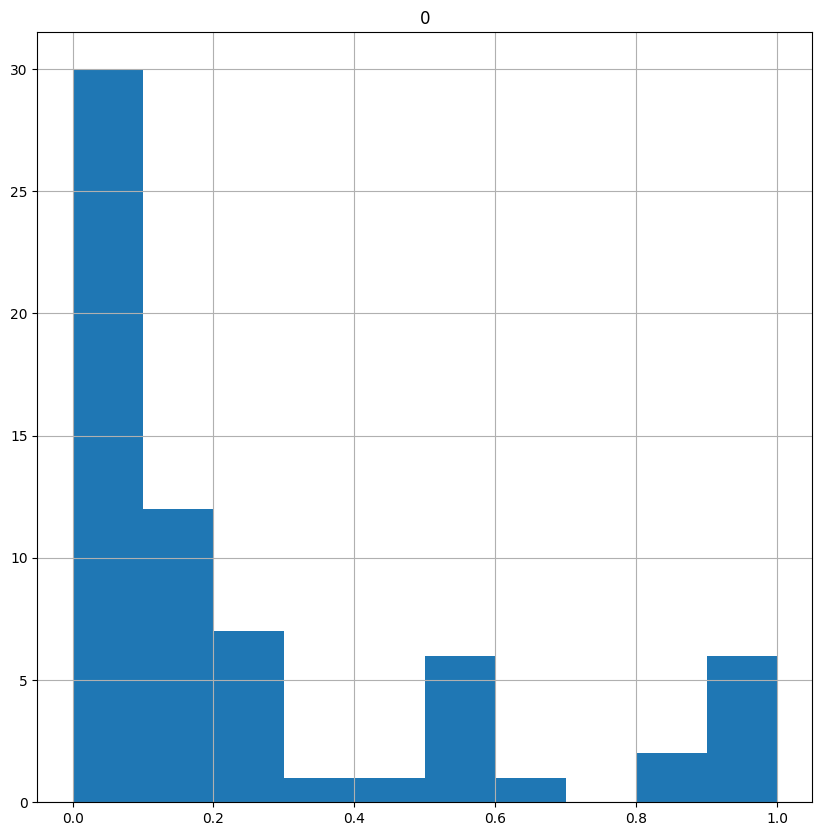

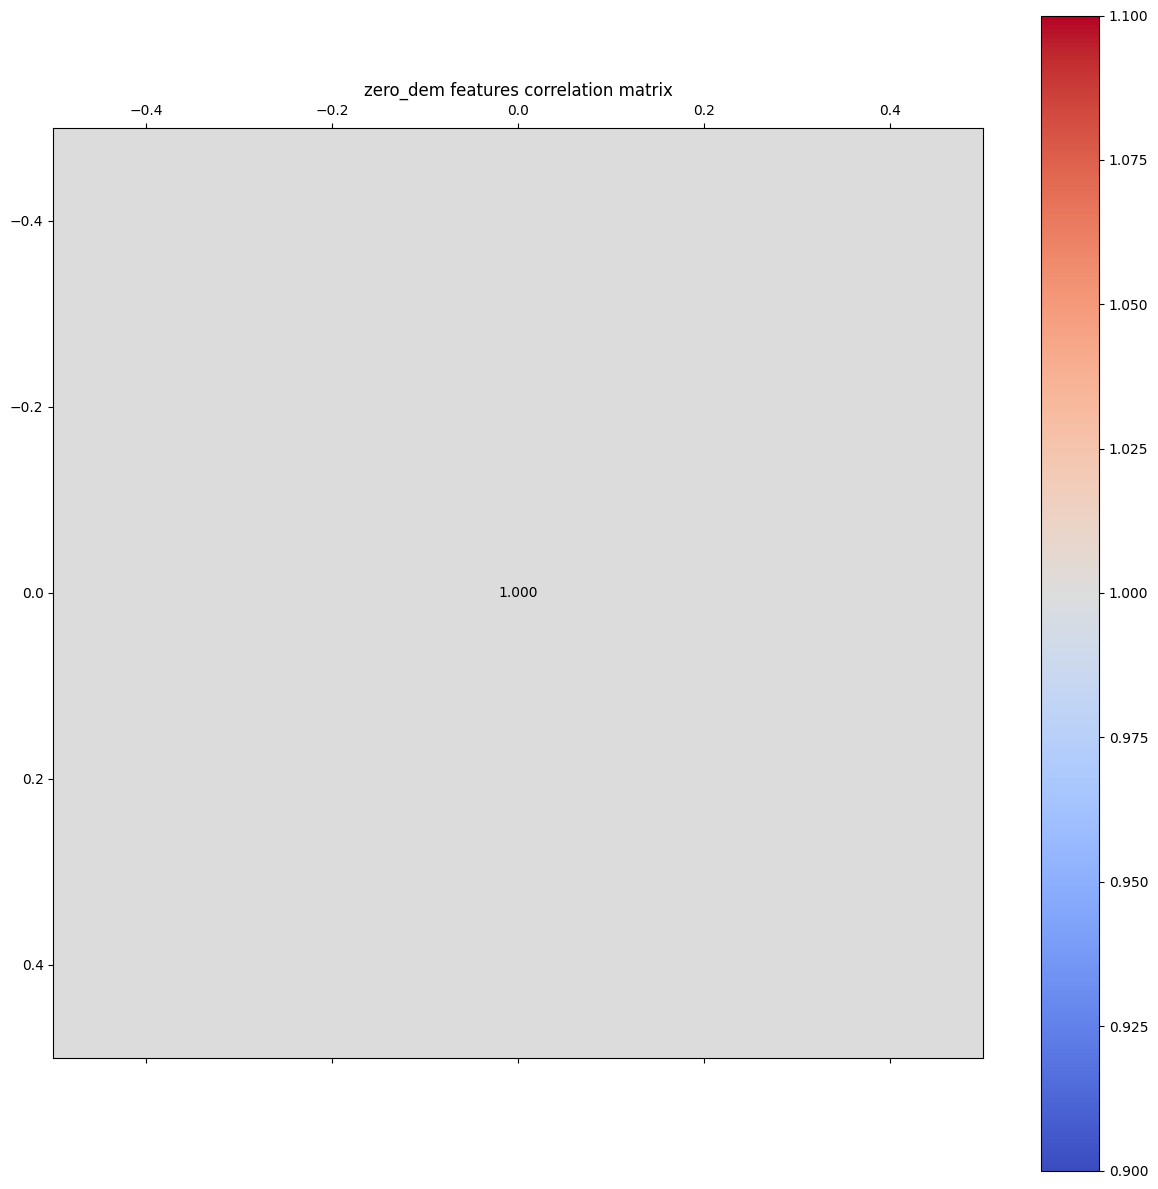

kurt_dem individual feature Histogram


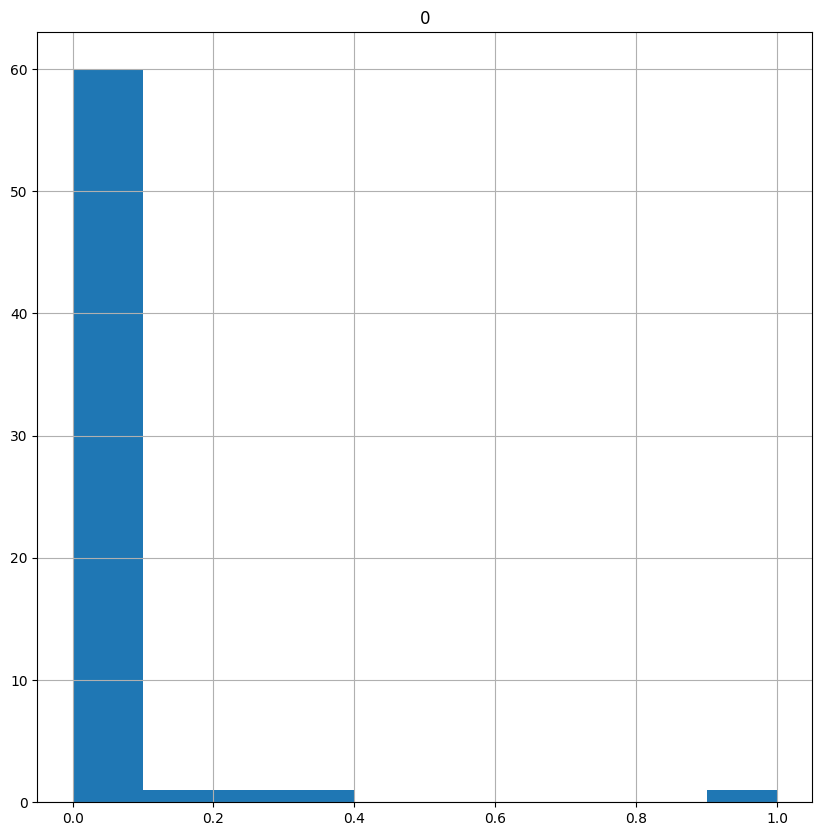

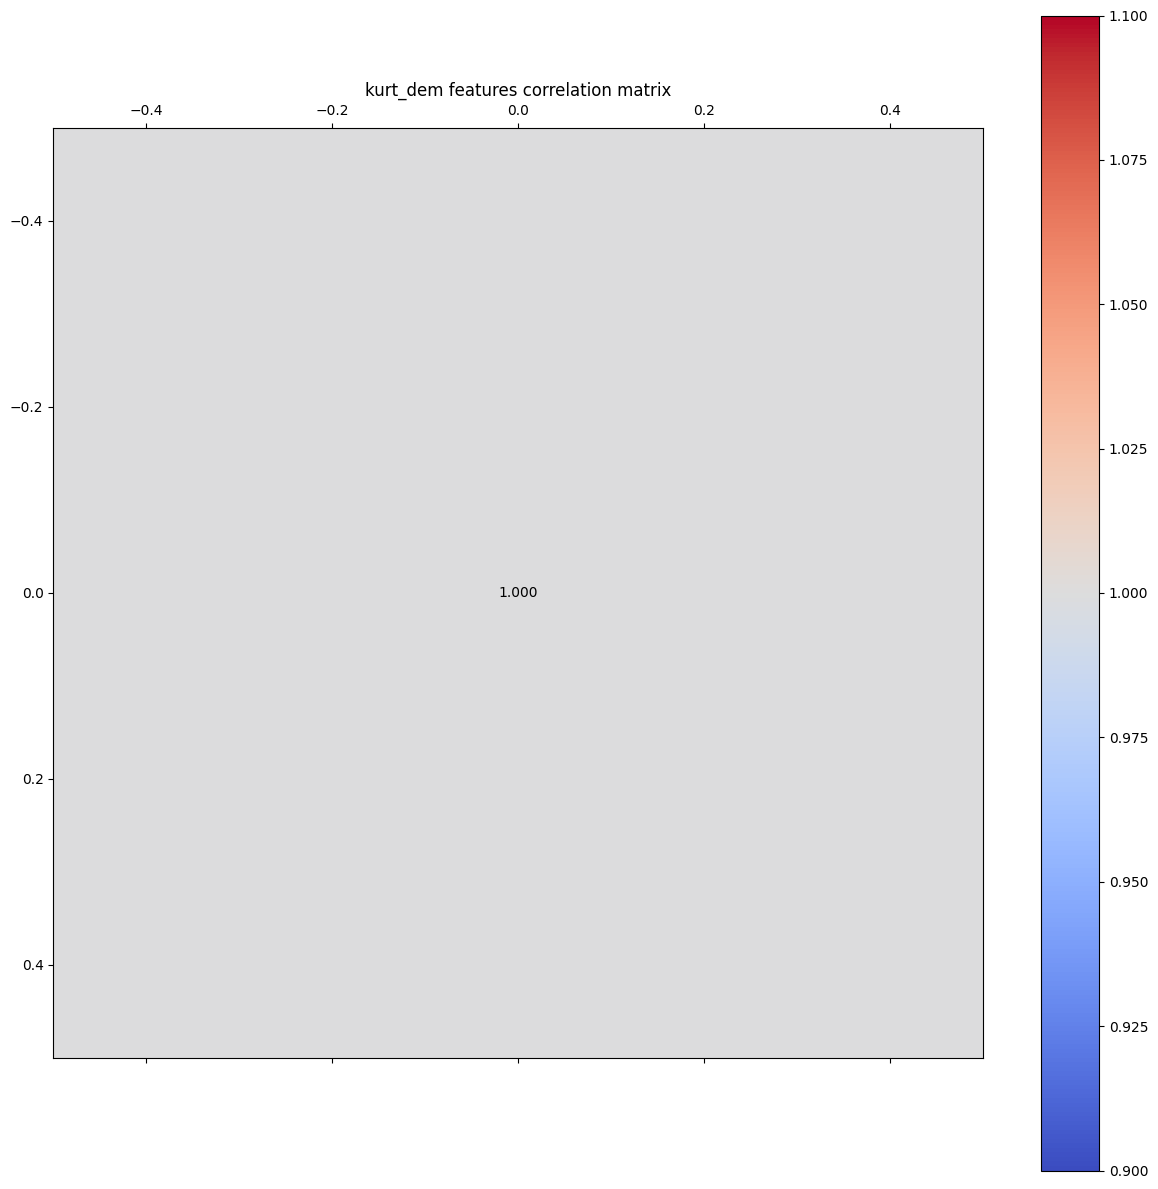

skew_dem individual feature Histogram


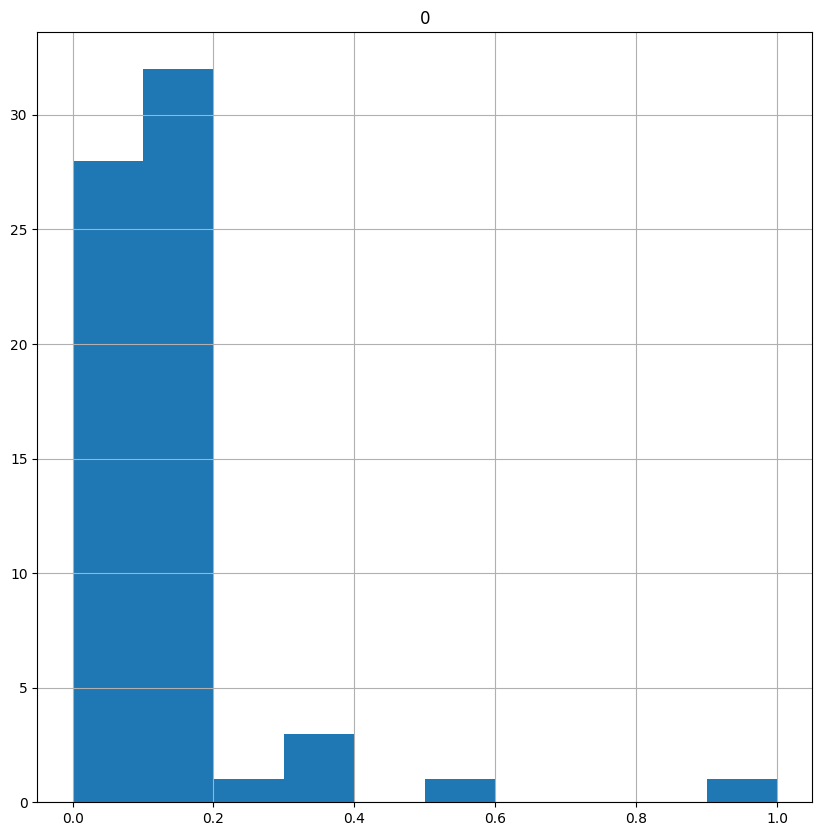

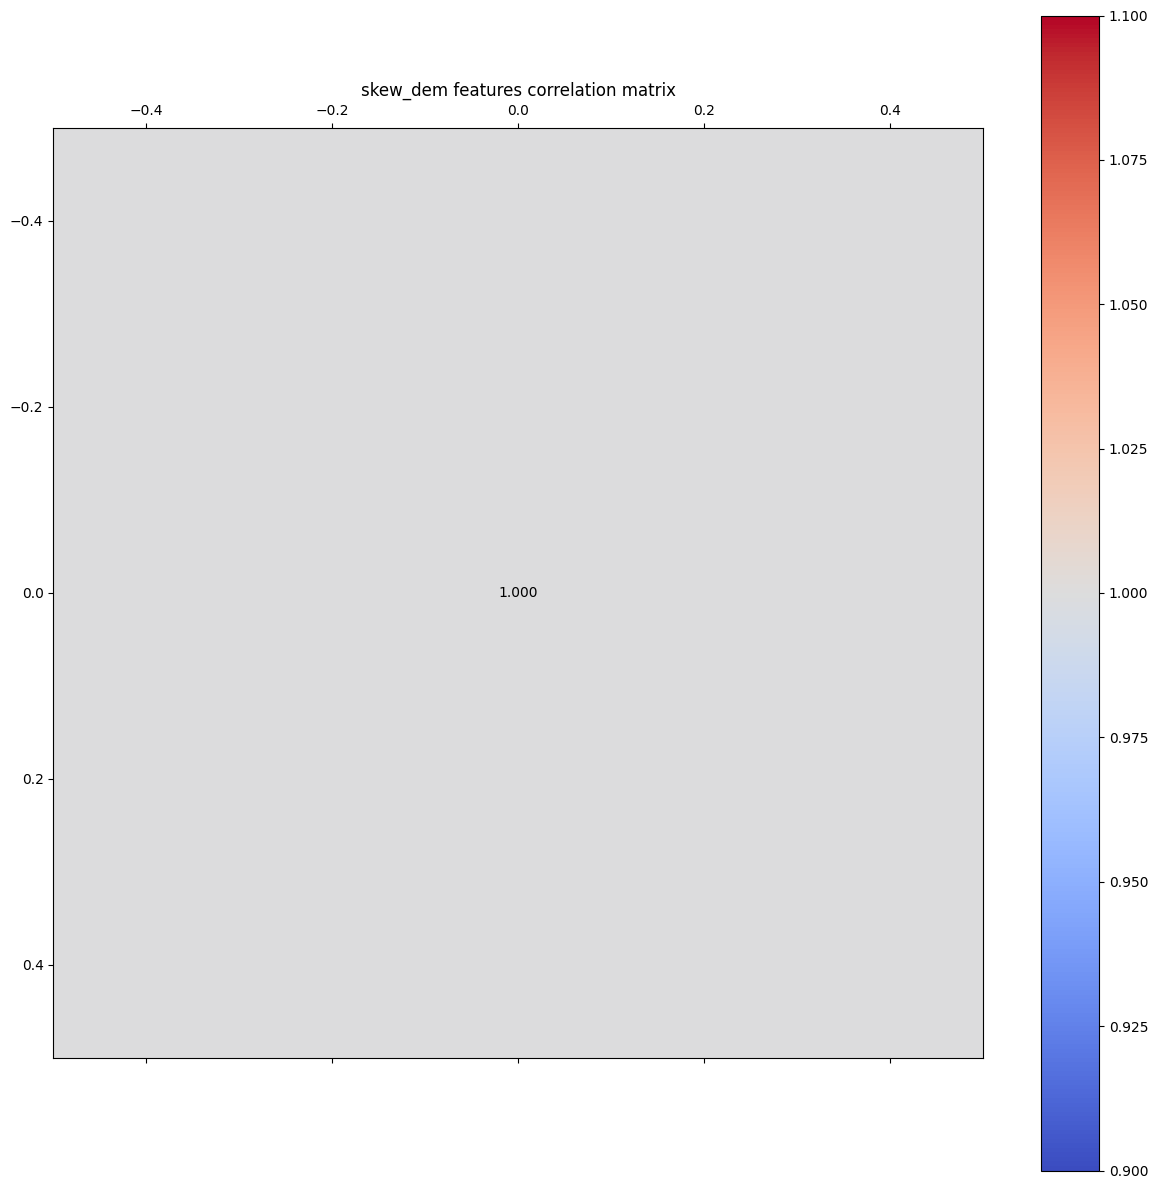

tot_dem individual feature Histogram


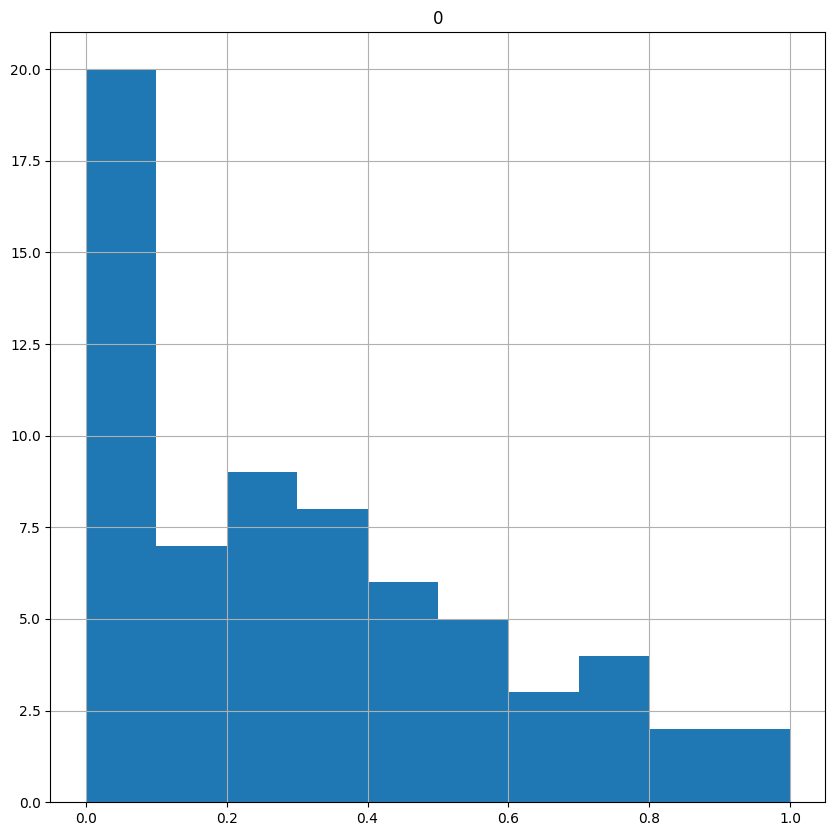

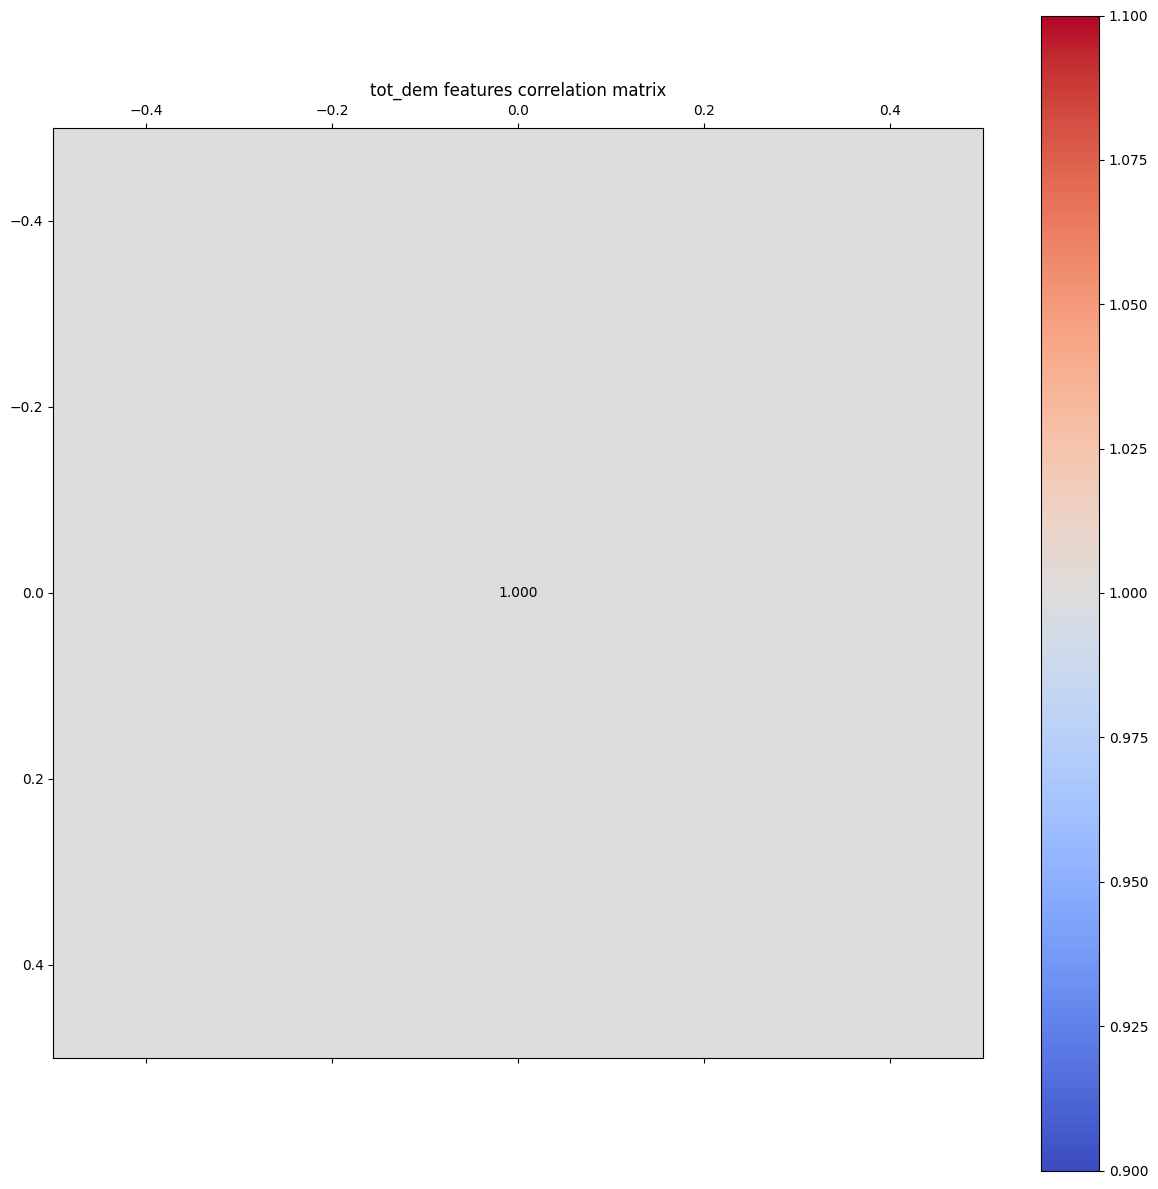

range_dem individual feature Histogram


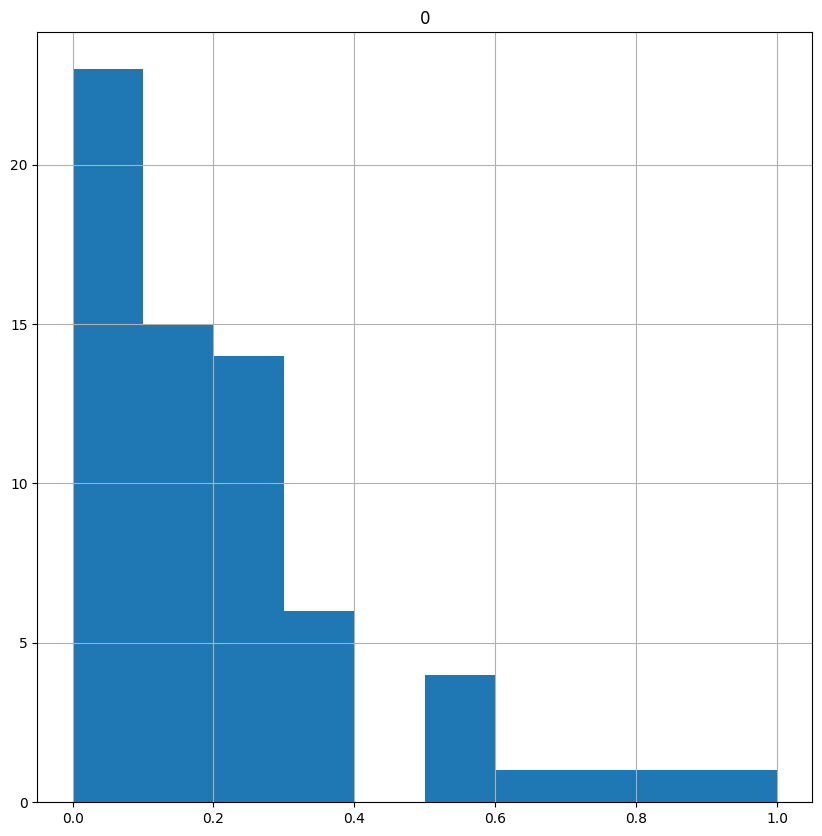

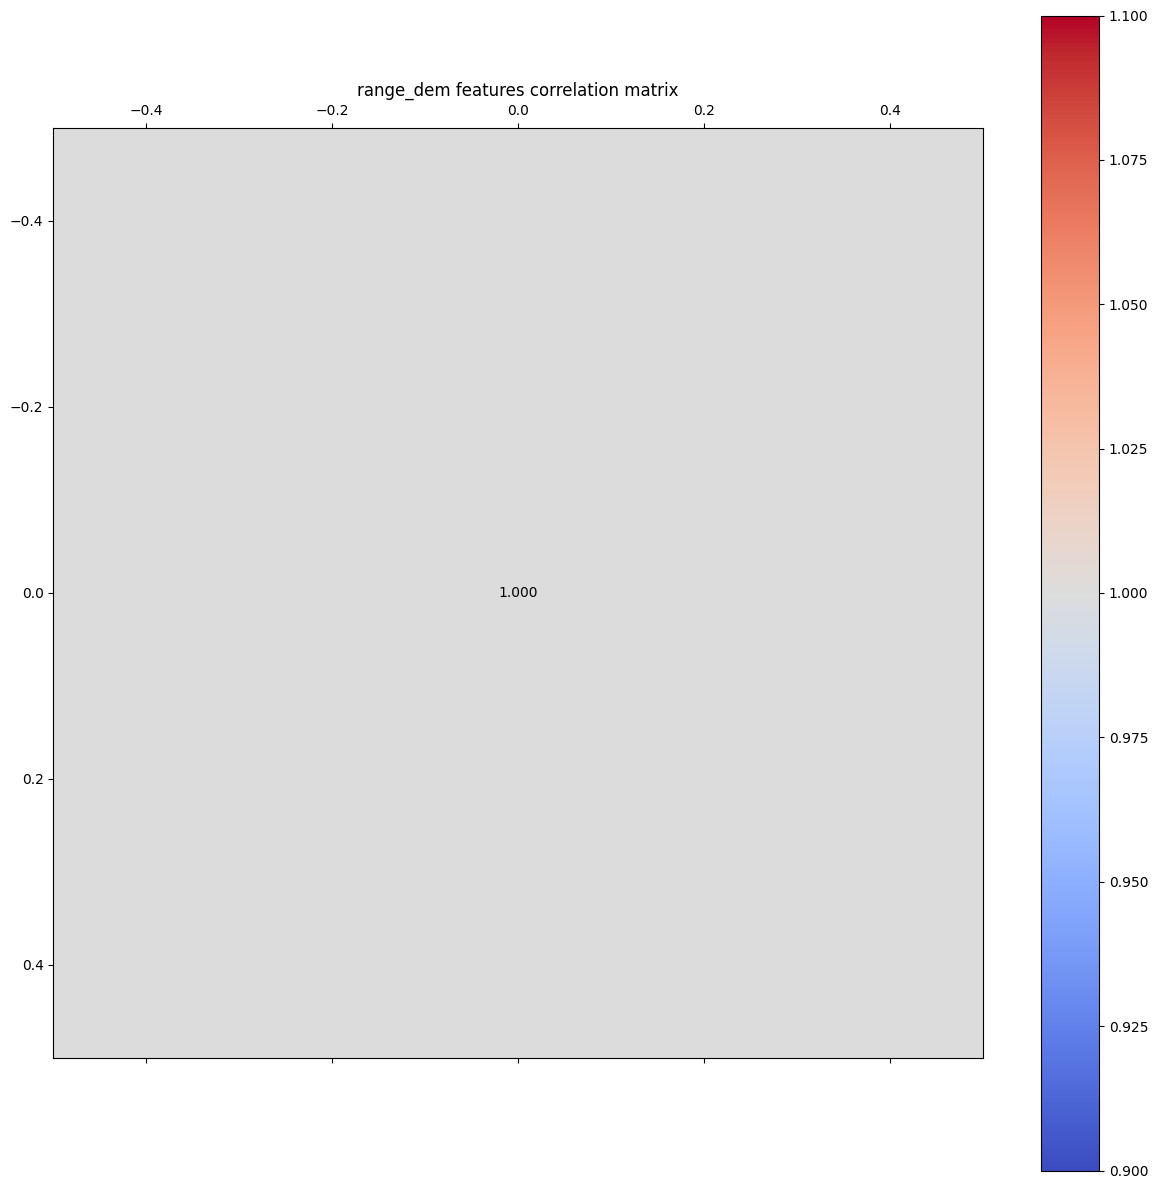

all_trend_statistics features individual feature Histogram


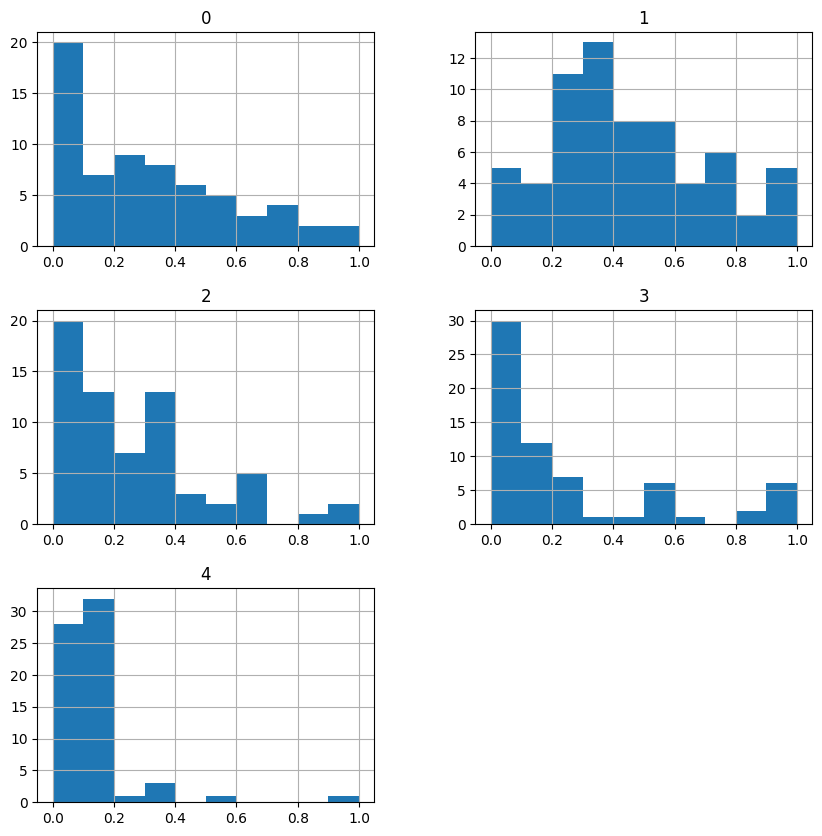

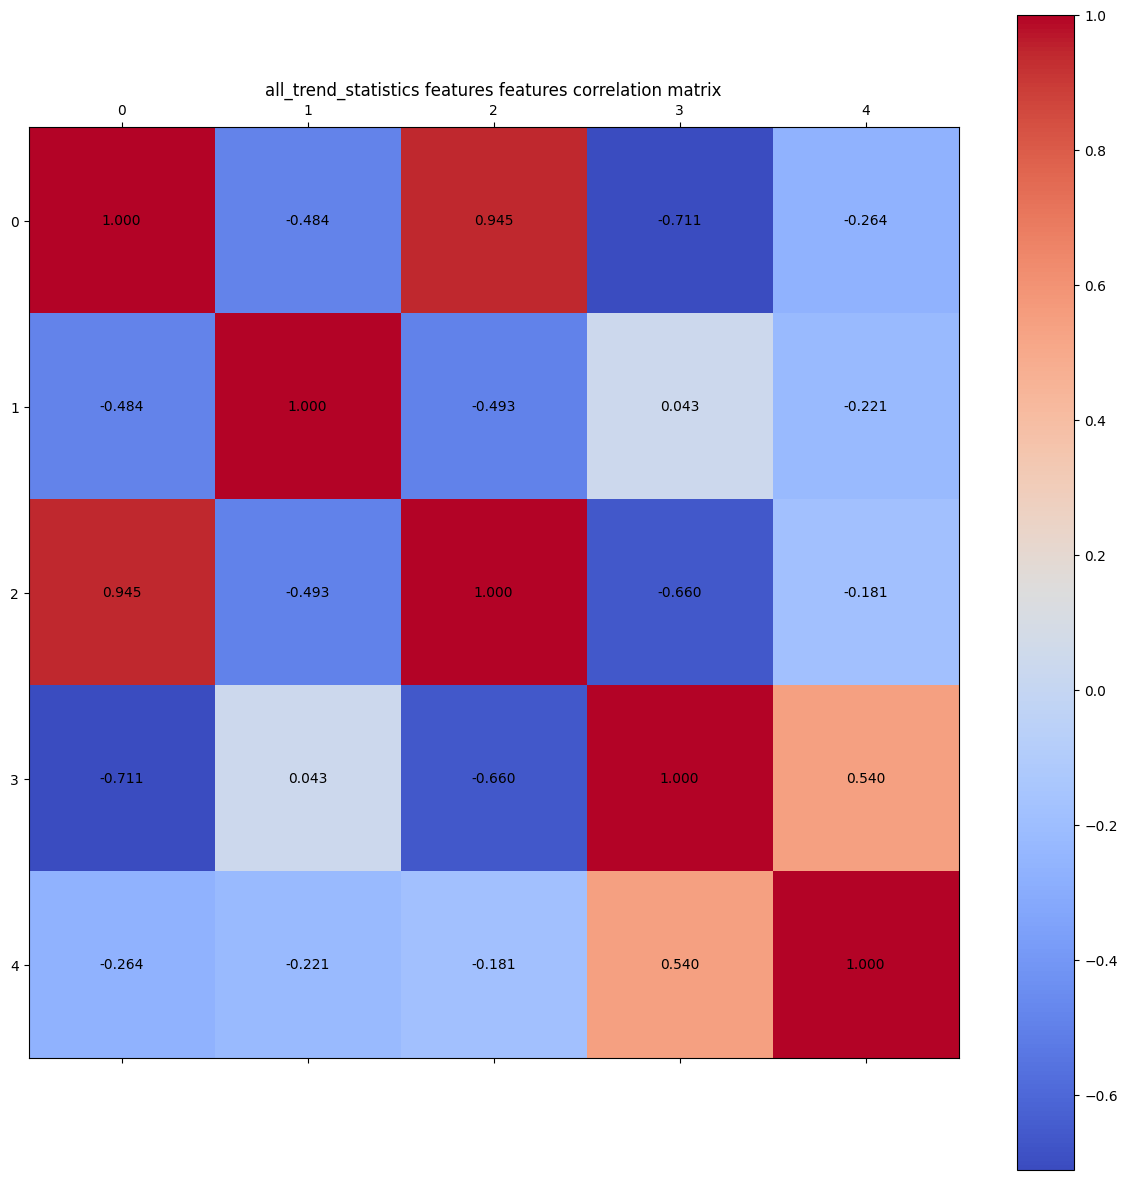

' TREND STATISTICAL FEATURES calculation'

In [206]:
"""                                                                     FEATURE Extraction
Feature extracted: Interpretable Time series statistical features

1) High/Low average demand for each day of 7 days


"""

################## Select one of ""all_days"" or ""week_days" (Mon,Tue,Wed,Thur) or "week_ends" (Fri,Sat,Sun) to generate trend/seasonality statistical features ##################
""" Select DAYS of the Dataframe to use"""
zone_met_10m_outflow_df = select_days_in_dataframe(manhat_demand,days_type='all_days')
################## Select one of ""all_days"" or ""week_days" (Mon,Tue,Wed,Thur) or "week_ends" (Fri,Sat,Sun) to generate trend/seasonality statistical features ##################



######################################################################################################################
""" TREND STATISTICAL FEATURES calculation"""

avg_dem = average_demand(zone_met_10m_outflow_df)
avg_dem_ts_stats_feat_transform = feat_transformation()
X_train_normalized_avg_dem = avg_dem_ts_stats_feat_transform.feature_normalization(  np.array([avg_dem.to_numpy()]).T  )
print_msg = 'avg_dem'
plot_all(print_msg,X_train_normalized_avg_dem).plot_hist_n_corr(X_train_normalized_avg_dem)
X_train_inv_normalized_avg_dem = avg_dem_ts_stats_feat_transform.inv_feature_normalization(X_train_normalized_avg_dem)
# print_msg = 'every_days_avg_dem_non_normalized'
# plot_all(print_msg,X_train_inv_normalized_avg_dem).plot_hist_n_corr(X_train_inv_normalized_avg_dem)

no_mean_cross_dem = no_mean_crossing_demand(zone_met_10m_outflow_df)
num_mean_cross_ts_stats_feat_transform = feat_transformation()
X_train_normalized_mean_cross = num_mean_cross_ts_stats_feat_transform.feature_normalization(  np.array([no_mean_cross_dem.to_numpy()]).T  )
print_msg = 'no_mean_crossing_dem'
plot_all(print_msg,X_train_normalized_mean_cross).plot_hist_n_corr(X_train_normalized_mean_cross)
X_train_inv_normalized_mean_cross = num_mean_cross_ts_stats_feat_transform.inv_feature_normalization(X_train_normalized_mean_cross)

n95_dem = peak_n95_demand(zone_met_10m_outflow_df)
n95_ts_stats_feat_transform = feat_transformation()
X_train_normalized_n95 = n95_ts_stats_feat_transform.feature_normalization(  np.array([n95_dem.to_numpy()]).T   )
print_msg = 'n95_dem'
plot_all(print_msg,X_train_normalized_n95).plot_hist_n_corr(X_train_normalized_n95)
X_train_inv_normalized_n95 = n95_ts_stats_feat_transform.inv_feature_normalization(X_train_normalized_n95)

max_dem = max_demand(zone_met_10m_outflow_df)
max_dem_ts_stats_feat_transform = feat_transformation()
X_train_normalized_max = max_dem_ts_stats_feat_transform.feature_normalization(    np.array([max_dem.to_numpy()]).T  )
print_msg = 'max_dem'
plot_all(print_msg,X_train_normalized_max).plot_hist_n_corr(X_train_normalized_max)
X_train_inv_normalized_max = max_dem_ts_stats_feat_transform.inv_feature_normalization(X_train_normalized_max)

max_deviation_from_n95 = outlier_demands(zone_met_10m_outflow_df)
max_dev_n95_ts_stats_feat_transform = feat_transformation()
X_train_normalized_max_dev_n95 = max_dev_n95_ts_stats_feat_transform.feature_normalization(  np.array([max_deviation_from_n95.to_numpy()]).T   )
print_msg = 'max_dev_from_n95_dem'
plot_all(print_msg,X_train_normalized_max_dev_n95).plot_hist_n_corr(X_train_normalized_max_dev_n95)
X_train_inv_normalized_max_dev_n95 = max_dev_n95_ts_stats_feat_transform.inv_feature_normalization(X_train_normalized_max_dev_n95)

zero_dem = count_zero_demands(zone_met_10m_outflow_df)
zero_dem_ts_stats_feat_transform = feat_transformation()
X_train_normalized_zeros = zero_dem_ts_stats_feat_transform.feature_normalization(   np.array([zero_dem.to_numpy()]).T   )
print_msg = 'zero_dem'
plot_all(print_msg,X_train_normalized_zeros).plot_hist_n_corr(X_train_normalized_zeros)
X_train_inv_normalized_zeros = zero_dem_ts_stats_feat_transform.inv_feature_normalization(X_train_normalized_zeros)


kurt = kurt_of_demands(zone_met_10m_outflow_df)
kurt_ts_stats_feat_transform = feat_transformation()
X_train_normalized_kurt = kurt_ts_stats_feat_transform.feature_normalization(   np.array([kurt.to_numpy()]).T  )
print_msg = 'kurt_dem'
plot_all(print_msg,X_train_normalized_kurt).plot_hist_n_corr(X_train_normalized_kurt)
X_train_inv_normalized_kurt = kurt_ts_stats_feat_transform.inv_feature_normalization(X_train_normalized_kurt)

skew = skew_of_demands(zone_met_10m_outflow_df)
skew_ts_stats_feat_transform = feat_transformation()
X_train_normalized_skew = skew_ts_stats_feat_transform.feature_normalization(   np.array([skew.to_numpy()]).T  )
print_msg = 'skew_dem'
plot_all(print_msg,X_train_normalized_skew).plot_hist_n_corr(X_train_normalized_skew)
X_train_inv_normalized_skew = skew_ts_stats_feat_transform.inv_feature_normalization(X_train_normalized_skew)


tot_dem = total_demands(zone_met_10m_outflow_df)
tot_dem_ts_stats_feat_transform = feat_transformation()
X_train_normalized_tot_dem = tot_dem_ts_stats_feat_transform.feature_normalization(   np.array([tot_dem.to_numpy()]).T  )
print_msg = 'tot_dem'
plot_all(print_msg,X_train_normalized_tot_dem).plot_hist_n_corr(X_train_normalized_tot_dem)
X_train_inv_normalized_tot_dem = tot_dem_ts_stats_feat_transform.inv_feature_normalization(X_train_normalized_tot_dem)

range_dem = range_demands(zone_met_10m_outflow_df)
range_dem_ts_stats_feat_transform = feat_transformation()
X_train_normalized_range_dem = range_dem_ts_stats_feat_transform.feature_normalization(   np.array([range_dem.to_numpy()]).T  )
print_msg = 'range_dem'
plot_all(print_msg,X_train_normalized_range_dem).plot_hist_n_corr(X_train_normalized_range_dem)
X_train_inv_normalized_range_dem = range_dem_ts_stats_feat_transform.inv_feature_normalization(X_train_normalized_range_dem)


# X_train_normalized_all_trend_statistic_features = np.concatenate((X_train_normalized_avg_dem,X_train_normalized_mean_cross,X_train_normalized_n95,X_train_normalized_max,\
#                                                                   X_train_normalized_max_dev_n95,X_train_normalized_zeros,X_train_normalized_kurt,\
#                                                                   X_train_normalized_tot_dem,X_train_normalized_range_dem,X_train_normalized_skew),axis=1)
#### After removing correlated features
X_train_normalized_all_trend_statistic_features = np.concatenate((X_train_normalized_avg_dem,X_train_normalized_mean_cross,X_train_normalized_n95,\
                                                                  X_train_normalized_zeros,X_train_normalized_skew),axis=1)

X_train_inverse_normalized_all_trend_statistic_features = np.concatenate((X_train_inv_normalized_avg_dem,X_train_inv_normalized_mean_cross,X_train_inv_normalized_n95,\
                                                                  X_train_inv_normalized_zeros,X_train_inv_normalized_skew),axis=1)

print_msg = 'all_trend_statistics features'
plot_all(print_msg,X_train_normalized_all_trend_statistic_features).plot_hist_n_corr(X_train_normalized_all_trend_statistic_features)


""" TREND STATISTICAL FEATURES calculation"""
######################################################################################################################







# #######################################################################################################################
# """ SEASONALITY STATISTICAL FEATURES calculation"""

# avg_dem = average_demand(select_days_station_met_60m_outflow_df)
# avg_dem_ts_stats_feat_transform = feat_transformation()
# X_train_normalized_avg_dem = avg_dem_ts_stats_feat_transform.feature_normalization(  np.array([avg_dem.to_numpy()]).T  )
# print_msg = 'avg_dem'
# #plot_all(print_msg,X_train_normalized_avg_dem).plot_hist_n_corr(X_train_normalized_avg_dem)
# X_train_inv_normalized_avg_dem = avg_dem_ts_stats_feat_transform.inv_feature_normalization(X_train_normalized_avg_dem)
# # print_msg = 'every_days_avg_dem_non_normalized'
# # plot_all(print_msg,X_train_inv_normalized_avg_dem).plot_hist_n_corr(X_train_inv_normalized_avg_dem)

# no_mean_cross_dem = no_mean_crossing_demand(station_met_outflow_60min_df)
# num_mean_cross_ts_stats_feat_transform = feat_transformation()
# X_train_normalized_mean_cross = num_mean_cross_ts_stats_feat_transform.feature_normalization(  np.array([no_mean_cross_dem.to_numpy()]).T  )
# print_msg = 'no_mean_crossing_dem'
# #plot_all(print_msg,X_train_normalized_mean_cross).plot_hist_n_corr(X_train_normalized_mean_cross)
# X_train_inv_normalized_mean_cross = num_mean_cross_ts_stats_feat_transform.inv_feature_normalization(X_train_normalized_mean_cross)

# std_dem = std_demand(station_met_outflow_60min_df)
# std_dem_ts_stats_feat_transform = feat_transformation()
# X_train_normalized_std = std_dem_ts_stats_feat_transform.feature_normalization(   np.array([std_dem.to_numpy()]).T   )
# print_msg = 'std_dem'
# #plot_all(print_msg,X_train_normalized_std).plot_hist_n_corr(X_train_normalized_std)
# X_train_inv_normalized_std = std_dem_ts_stats_feat_transform.inv_feature_normalization(X_train_normalized_std)

# entropy_dem = entropy_demands(station_met_outflow_60min_df)
# entropy_dem_ts_stats_feat_transform = feat_transformation()
# X_train_normalized_entropy_dem = entropy_dem_ts_stats_feat_transform.feature_normalization(   np.array([entropy_dem.to_numpy()]).T  )
# print_msg = 'entropy_dem'
# #plot_all(print_msg,X_train_normalized_entropy_dem).plot_hist_n_corr(X_train_normalized_entropy_dem)
# X_train_inv_normalized_entropy_dem = entropy_dem_ts_stats_feat_transform.inv_feature_normalization(X_train_normalized_entropy_dem)

# pos_autocorr_lags = demands_positive_autocorr_lags(station_met_outflow_60min_df)
# pos_autocorr_lags_ts_stats_feat_transform = feat_transformation()
# X_train_normalized_pos_autocorr_lags = pos_autocorr_lags_ts_stats_feat_transform.feature_normalization(pos_autocorr_lags)
# print_msg = 'positive_autocorr_lags'
# #plot_all(print_msg,X_train_normalized_pos_autocorr_lags).plot_hist_n_corr(X_train_normalized_pos_autocorr_lags)
# X_train_inv_normalized_pos_autocorr_lags = pos_autocorr_lags_ts_stats_feat_transform.inv_feature_normalization(X_train_normalized_pos_autocorr_lags)

# neg_autocorr_lags = demands_negative_autocorr_lags(station_met_outflow_60min_df)
# neg_autocorr_lags_ts_stats_feat_transform = feat_transformation()
# X_train_normalized_neg_autocorr_lags = neg_autocorr_lags_ts_stats_feat_transform.feature_normalization(neg_autocorr_lags)
# print_msg = 'negative_autocorr_lags'
# #plot_all(print_msg,X_train_normalized_neg_autocorr_lags).plot_hist_n_corr(X_train_normalized_neg_autocorr_lags)
# X_train_inv_normalized_neg_autocorr_lags = neg_autocorr_lags_ts_stats_feat_transform.inv_feature_normalization(X_train_normalized_neg_autocorr_lags)


# peak_fft_periods = fft_of_demand(station_met_outflow_60min_df)
# fft_ts_stats_feat_transform = feat_transformation()
# X_train_normalized_fft = fft_ts_stats_feat_transform.feature_normalization(peak_fft_periods)
# print_msg = 'fft_dem'
# #plot_all(print_msg,X_train_normalized_fft).plot_hist_n_corr(X_train_normalized_fft)
# X_train_inv_normalized_fft = fft_ts_stats_feat_transform.inv_feature_normalization(X_train_normalized_fft)

# # X_train_inv_normalized_fft = fft_ts_stats_feat_transform.inv_feature_normalization(X_train_normalized_fft)
# # print_msg = 'fft_non_normalized'
# # plot_all(print_msg).plot_hist_n_corr(X_train_inv_normalized_fft)

# # ####### Takes too long to Compute ########
# # pos_partial_autocorr_lags = demands_positive_partial_autocorr_lags(station_met_outflow_60min_df)
# # pos_partial_autocorr_lags_ts_stats_feat_transform = feat_transformation()
# # X_train_normalized_pos_partial_autocorr_lags = pos_partial_autocorr_lags_ts_stats_feat_transform.feature_normalization(pos_partial_autocorr_lags)
# # print_msg = 'positive_partial_autocorr_lags'
# # plot_all(print_msg,X_train_normalized_neg_partial_autocorr_lags).plot_hist_n_corr(X_train_normalized_pos_partial_autocorr_lags)

# # ####### Takes too long to Compute ########
# # neg_partial_autocorr_lags = demands_negative_partial_autocorr_lags(station_met_outflow_60min_df)
# # neg_partial_autocorr_lags_ts_stats_feat_transform = feat_transformation()
# # X_train_normalized_neg_partial_autocorr_lags = neg_partial_autocorr_lags_ts_stats_feat_transform.feature_normalization(neg_partial_autocorr_lags)
# # print_msg = 'negative_partial_autocorr_lags'
# # plot_all(print_msg,X_train_normalized_neg_partial_autocorr_lags).plot_hist_n_corr(X_train_normalized_neg_partial_autocorr_lags)


# # X_train_normalized_all_seasonality_statistic_features = np.concatenate((X_train_normalized_avg_dem,X_train_normalized_mean_cross,X_train_normalized_std,X_train_normalized_entropy_dem,\
# #                                                                   X_train_normalized_pos_autocorr_lags,X_train_normalized_neg_autocorr_lags,X_train_normalized_fft),axis=1)

# # # After removing correlated features
# # X_train_normalized_all_seasonality_statistic_features = np.concatenate((X_train_normalized_avg_dem,X_train_normalized_mean_cross,X_train_normalized_pos_autocorr_lags,\
# #                                                                         X_train_normalized_fft),axis=1)
# # X_train_inverse_normalized_all_seasonality_statistic_features = np.concatenate((X_train_inv_normalized_avg_dem,X_train_inv_normalized_mean_cross,\
# #                                                                                 X_train_inv_normalized_pos_autocorr_lags,X_train_inv_normalized_fft),axis=1)

# X_train_normalized_all_seasonality_statistic_features = X_train_normalized_pos_autocorr_lags ## np.concatenate((X_train_normalized_fft,X_train_normalized_mean_cross,),axis=1)
# X_train_inverse_normalized_all_seasonality_statistic_features = X_train_inv_normalized_pos_autocorr_lags ##np.concatenate((X_train_inv_normalized_avg_dem,X_train_inv_normalized_mean_cross,),axis=1)

# print_msg = 'all_seasonality_statistics features'
# plot_all(print_msg,X_train_normalized_all_seasonality_statistic_features).plot_hist_n_corr(X_train_normalized_all_seasonality_statistic_features)

# """ SEASONALITY STATISTICAL FEATURES calculation"""
# ######################################################################################################################


In [207]:
"""                                                                     PLOT UMAP for everyday_avg_demand Time series statistical features

"""

plt.close('all')
X_train_normalized = X_train_normalized_all_trend_statistic_features
X_train_inv_normalized =X_train_inverse_normalized_all_trend_statistic_features
# X_train_normalized = X_train_normalized_all_seasonality_statistic_features
# X_train_inv_normalized =X_train_inverse_normalized_all_seasonality_statistic_features

# print_msg = ''
# plotter_avg_dem = plot_all(print_msg,X_train_normalized)

# interactive_UMAP_plot=interactive(plotter_avg_dem.plot_UMAP_interactive,X_train=X_train_normalized,print_msg=print_msg,n_neighbors=(10,100,20),min_dist=(0,1.0,0.1),metric=['euclidean','mahalanobis','manhattan'])
# display(interactive_UMAP_plot)



In [208]:
"""                                                                    ### DETAILED 3d UMAP for everyday_avg_demand Time series statistical features

use above to get correct n_neighbors ,min_dist and metric to visuzalize in detain
"""
# plt.close('all')

# fig_umap_3d = sp.make_subplots(specs=[[{'type': 'surface'} for i in range(1)]])

# fig_umap_3d.add_trace(plotter_avg_dem.plot_UMAP_3d(X_train_normalized,10,0.1,'euclidean'))

# fig_umap_3d.update_layout(height=900 , width=900,title='UMAP 3d,'+print_msg)
# fig_umap_3d.show()

'                                                                    ### DETAILED 3d UMAP for everyday_avg_demand Time series statistical features\n\nuse above to get correct n_neighbors ,min_dist and metric to visuzalize in detain\n'

In [209]:
"""
Parameter search for best clustering using TS statistical Features

"""

best_score = 0
best_score_num_cluster_dict = {}
cov_mat = np.cov(X_train_normalized.T)

for metric in ['euclidean','manhattan','mahalanobis']:# need to implement mahalanobis distance
    if metric != 'mahalanobis':
        for min_cluster_size in range(5,80,5):
            for min_samples in range(1,40,2):
                for cluster_selection_method in ['eom','leaf']:
                    # for each combination of parameters of hdbscan
                    hdb = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,min_samples=min_samples,
                                          cluster_selection_method=cluster_selection_method, metric=metric,
                                          gen_min_span_tree=True).fit(X_train_normalized)
                    # DBCV score
                    score = hdb.relative_validity_
                    outliers = (np.array(hdb.labels_)==-1).sum()
                    best_score_num_cluster_dict[score] = [len(np.unique(hdb.labels_)),min_cluster_size,min_samples,cluster_selection_method,metric,outliers]
                    #print(f'score: {score}, num of unique clusters: {len(np.unique(hdb.labels_))}' )
                    # if we got a better DBCV, store it and the parameters
                    if score > best_score:
                        best_score = score
                        best_parameters = {'min_cluster_size': min_cluster_size,
                                  ' min_samples':  min_samples, 'cluster_selection_method': cluster_selection_method,
                                  'metric': metric}
    else: ## mahalanobis distance
        for min_cluster_size in range(5,80,5):
            for min_samples in range(1,40,2):
                for cluster_selection_method in ['eom','leaf']:
                    # for each combination of parameters of hdbscan
                    hdb = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,min_samples=min_samples,
                                          cluster_selection_method=cluster_selection_method, metric=metric,V=cov_mat,
                                          gen_min_span_tree=True).fit(X_train_normalized)
                    # DBCV score
                    score = hdb.relative_validity_
                    outliers = (np.array(hdb.labels_)==-1).sum()
                    best_score_num_cluster_dict[score] = [len(np.unique(hdb.labels_)),min_cluster_size,min_samples,cluster_selection_method,metric,outliers]
                    #print(f'score: {score}, num of unique clusters: {len(np.unique(hdb.labels_))}' )
                    # if we got a better DBCV, store it and the parameters
                    if score > best_score:
                        best_score = score
                        best_parameters = {'min_cluster_size': min_cluster_size,
                                  ' min_samples':  min_samples, 'cluster_selection_method': cluster_selection_method,
                                  'metric': metric}


print("Best DBCV score: {:.3f}".format(best_score))
print("Best parameters: {}".format(best_parameters))

Best DBCV score: 0.438
Best parameters: {'min_cluster_size': 5, ' min_samples': 1, 'cluster_selection_method': 'eom', 'metric': 'euclidean'}


In [210]:
sorted(best_score_num_cluster_dict.items())[-40:]

[(0.0, [1, 75, 39, 'leaf', 'mahalanobis', 66]),
 (0.0006335118891235011, [3, 5, 5, 'leaf', 'manhattan', 29]),
 (0.0007545682363162575, [3, 5, 5, 'eom', 'euclidean', 26]),
 (0.0031464434615755864, [3, 5, 7, 'leaf', 'manhattan', 27]),
 (0.00408524708885737, [3, 5, 5, 'leaf', 'mahalanobis', 52]),
 (0.005430687099317987, [3, 10, 3, 'leaf', 'euclidean', 41]),
 (0.005626245756757389, [3, 5, 3, 'eom', 'mahalanobis', 29]),
 (0.005991951021910233, [3, 10, 1, 'leaf', 'euclidean', 33]),
 (0.027224273306538628, [3, 10, 1, 'leaf', 'mahalanobis', 40]),
 (0.05390925548997526, [3, 5, 1, 'eom', 'mahalanobis', 6]),
 (0.0612701983683925, [7, 5, 1, 'leaf', 'manhattan', 21]),
 (0.0626175935047525, [3, 5, 3, 'eom', 'euclidean', 3]),
 (0.0688127696994314, [4, 5, 5, 'leaf', 'euclidean', 43]),
 (0.07382834830188838, [6, 5, 1, 'leaf', 'mahalanobis', 25]),
 (0.07836404998695387, [5, 5, 3, 'leaf', 'euclidean', 28]),
 (0.08067674516500725, [5, 5, 3, 'leaf', 'manhattan', 32]),
 (0.11155030238697987, [4, 5, 3, 'leaf

In [211]:
"""
Further eliminate some Parameter combination for every_days_avg_dem TS statistical Features based on best DBCV score

"""

hdbscan_best_score_comb = []
dbcv_threshold = 0.05
min_num_clusters_threshold = 3
max_num_clusters_threshold = 7
num_outliers_margin = X_train_normalized.shape[0]/2.6 #tolerable_num_outliers

for comb in sorted(best_score_num_cluster_dict.items())[-40:]:
    dbcv = comb[0]
    num_outliers = comb[1][5]
    num_clusters = comb[1][0]
    if ((num_outliers < num_outliers_margin) and (num_clusters < max_num_clusters_threshold) and (num_clusters > min_num_clusters_threshold) and (dbcv > dbcv_threshold) ):
        hdbscan_best_score_comb.append(comb)
hdbscan_best_score_comb



[(0.07382834830188838, [6, 5, 1, 'leaf', 'mahalanobis', 25]),
 (0.13286517703708056, [6, 5, 1, 'leaf', 'euclidean', 24])]

/usr/local/lib/python3.10/dist-packages/hdbscan/plots.py:837: RuntimeWarning:

divide by zero encountered in divide

/usr/local/lib/python3.10/dist-packages/matplotlib/lines.py:66: RuntimeWarning:

invalid value encountered in double_scalars



[ 1  0  4 -1  4  1  4  1 -1 -1  2  4  4  2  4  4  3  2  2  3 -1 -1 -1  4
  0 -1  3  2  2 -1  4 -1  4  4 -1  0  4 -1 -1  2  2  4  2 -1  0 -1 -1 -1
 -1  2 -1  2  1  3 -1 -1 -1 -1 -1  0  1  2  3 -1  3  2]


(0.07381968667798847, 26, -0.7647460907537696, 32.0)

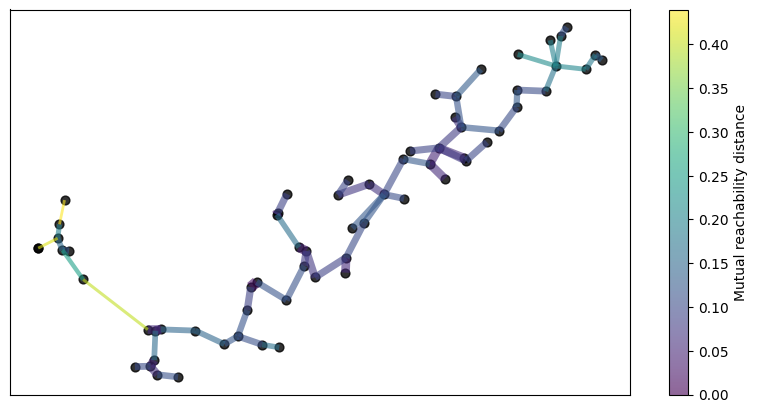

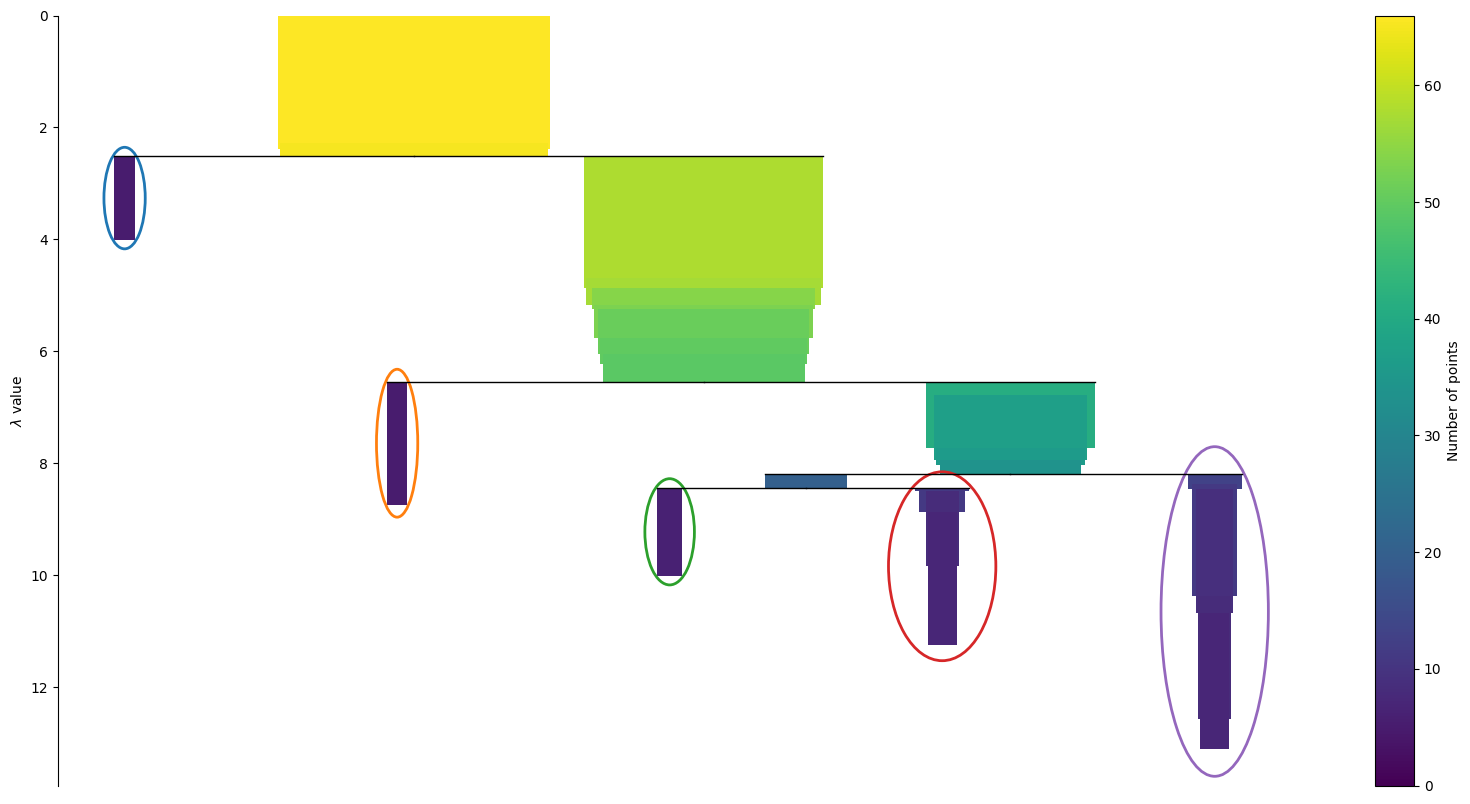

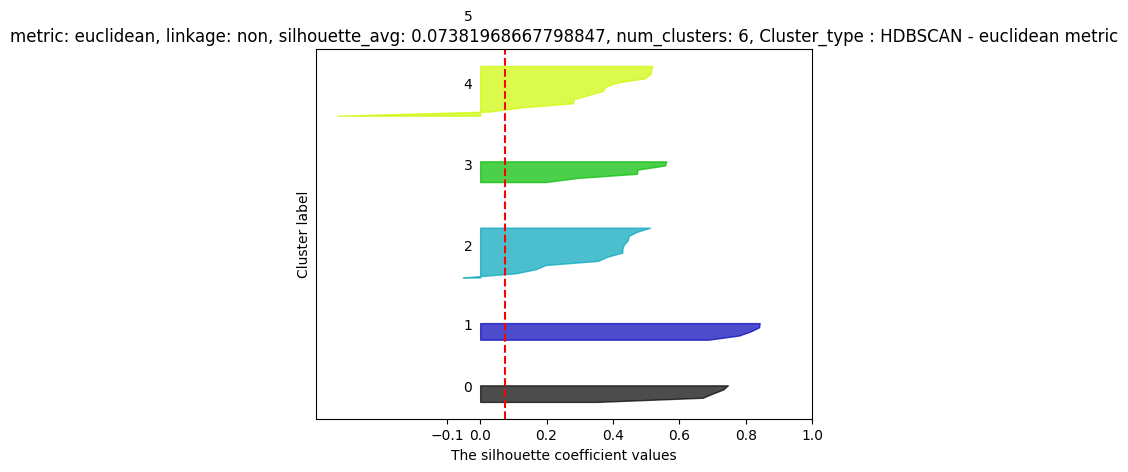

In [212]:
"""
Plot Minimum spanning tree and dbscan cluster hierarchy from every_days_avg_dem  TS statistical features

SHORTLISTED hdbscan clustering parameters combination for stats features

"""


plt.close('all')
clustering_type = 'HDBSCAN - euclidean metric'

if (hdbscan_best_score_comb[-1][1][4] == 'mahalanobis'):
    hdbscan_model = hdbscan.HDBSCAN(min_cluster_size= hdbscan_best_score_comb[-1][1][1], min_samples= hdbscan_best_score_comb[-1][1][2],cluster_selection_method=hdbscan_best_score_comb[-1][1][3], metric=hdbscan_best_score_comb[-1][1][4], gen_min_span_tree=True,V=cov_mat,)
else:
    hdbscan_model = hdbscan.HDBSCAN(min_cluster_size= hdbscan_best_score_comb[-1][1][1], min_samples= hdbscan_best_score_comb[-1][1][2],cluster_selection_method=hdbscan_best_score_comb[-1][1][3], metric=hdbscan_best_score_comb[-1][1][4], gen_min_span_tree=True)#,V=cov_mat,)


hdbscan_model.fit(X_train_normalized)

fig = plt.figure(figsize=(10,5))
# Plotting the minimum spanning tree in the first subplot
hdbscan_model.minimum_spanning_tree_.plot(
    edge_cmap='viridis',
    edge_alpha=0.6,
    edge_linewidth=2
)
fig.show()

fig = plt.figure(figsize=(20,10))
# Plotting the condensed tree in the second subplot
hdbscan_model.condensed_tree_.plot(
    select_clusters=True,
    selection_palette=sns.color_palette(),
)
fig.show()

print(hdbscan_model.labels_)

plot_silhouette_scores(X_train_normalized,hdbscan_model.labels_,'euclidean','non',clustering_type)

In [213]:
"""
Visualize every_days_avg_dem Time series statistical features of all clusters using parcoords plot

"""

plt.close('all')
plot_title = 'TS statistical features'
mother = 'rbio2.2'
limit_level = 2
trend_angular_labels = ["Average Demand",'no_mean_crossing', "n95 demand", "Zero demands", "skewness"]
# seasonality_angular_labels = [
# 'pos_ac_lag0',
#  'pos_ac_lag1',
#  'pos_ac_lag2',
#  'pos_ac_lag3',
#  'pos_ac_lag4',]
#seasonality_angular_labels = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9']


#X_train = avg_dem_ts_stats_feat_transform.inv_feature_normalization(X_train_normalized)

#station_met_outflow_60min_df = station_met_outflow_60min_df.drop(columns=['week','weekday','hour'])
clustering_result_dict,all_cluster_feat_mins,all_cluster_feat_maxs = plot_stations_of_clusters(hdbscan_model.labels_, zone_met_10m_outflow_df,'met_demand',X_train_normalized,X_train_inv_normalized,'par_coords',trend_angular_labels,plot_title,mother,limit_level)



Output hidden; open in https://colab.research.google.com to view.

In [214]:
"""
Visualize cluster representatives from every_days_avg_dem Time series statistical features using parcoords plot

"""

plot_cluster_representatives(X_train_normalized, all_cluster_feat_mins, all_cluster_feat_maxs,'par_coords',trend_angular_labels)

In [215]:
"""
Rank cluster from "highest demand" to "lowest demand" vaguely without the outlier.
"""
num_clusters = len(np.unique(hdbscan_model.labels_))
num_features = X_train_normalized.shape[1]

num_clusters = num_clusters - 1 #remove outlier cluster
all_cluster_feat_mins = all_cluster_feat_mins[num_features:].reshape(num_clusters,num_features)
all_cluster_feat_maxs = all_cluster_feat_maxs[num_features:].reshape(num_clusters,num_features)

ranked_clusters = rank_clusterings(all_cluster_feat_mins,all_cluster_feat_maxs,num_clusters,num_features) # exclude outliers
ranked_clusters

{0: 3, 1: 4, 2: 2, 3: 0, 4: 1}

In [216]:
"""
Display different ranked clusters on the same map
"""

colormap = plt.cm.RdYlGn  # Diverging red to green colormap
norm = mcolors.Normalize(vmin=min(ranked_clusters.keys()), vmax=max(ranked_clusters.keys()))

map_center = [40.7831, -73.9712]  # Manhattan coordinates (latitude, longitude)
map_zoom = 12  # Adjust the zoom level as needed
my_map = folium.Map(location=map_center, zoom_start=map_zoom,width='70%', height='70%')

marker_color = [ 'black','darkred','red','lightred','lightgreen','green','darkgreen',    'lightblue',    'blue',    'darkblue',]

for cluster in clustering_result_dict.keys(): # outliers included
  stations = clustering_result_dict[cluster]
  color = mcolors.to_hex(colormap(norm(cluster)))
  for station in stations:
    folium.Marker(location=zone_to_gps_dict[int(station)], popup=str(station)+': '+color+'-'+str(cluster), icon=folium.Icon(color=marker_color[cluster+1]),tooltip=str(cluster)).add_to(my_map)
display(my_map)

In [217]:
"""
Identify aggolmeratic clustering parameter combination with best silhouette score for trend and seasonality stat features

"""

plt.close('all')

num_clusters_list = range(4,8,1)
clustering_type = 'Agglomerative'

agglomerative_result_comb = []

methods = ['single','complete','average']#['single','complete','average','weighted',]
metrics = ['euclidean','cityblock']
for metric in metrics:
    for method in methods:
        for num_clusters in num_clusters_list:
            model = AgglomerativeClustering(n_clusters=num_clusters, metric=metric, linkage=method)
            model.fit(X_train_normalized)
            labels = model.labels_
            silhouette_avg, num_neg_silhouette_scores, min_silhouette_score,dev_from_mean_num_zone = plot_silhouette_scores(X_train_normalized,labels,metric,method,clustering_type)
            agglomerative_result_comb.append([silhouette_avg,num_neg_silhouette_scores, min_silhouette_score,metric,method,num_clusters,dev_from_mean_num_zone ])


methods = ['ward']#['median','centroid','ward']
metrics = ['euclidean']
for method in methods:
    for metric in metrics:
        for num_clusters in num_clusters_list:
            model = AgglomerativeClustering(n_clusters=num_clusters, metric=metric, linkage=method)
            model.fit(X_train_normalized)
            labels = model.labels_
            silhouette_avg, num_neg_silhouette_scores, min_silhouette_score,dev_from_mean_num_zone = plot_silhouette_scores(X_train_normalized,labels,metric,method,clustering_type)
            agglomerative_result_comb.append([silhouette_avg,num_neg_silhouette_scores, min_silhouette_score,metric,method,num_clusters,dev_from_mean_num_zone ])


methods = ['complete','average']#['single','complete','average','weighted',]
metrics = ['mahalanobis','manhattan']
for metric in metrics:
    for method in methods:
        for num_clusters in num_clusters_list:
            model = AgglomerativeClustering(n_clusters=num_clusters, metric=metric, linkage=method)
            model.fit(X_train_normalized)
            labels = model.labels_
            silhouette_avg, num_neg_silhouette_scores, min_silhouette_score,dev_from_mean_num_zone = plot_silhouette_scores(X_train_normalized,labels,metric,method,clustering_type)
            agglomerative_result_comb.append([silhouette_avg,num_neg_silhouette_scores, min_silhouette_score,metric,method,num_clusters,dev_from_mean_num_zone ])

Output hidden; open in https://colab.research.google.com to view.

In [218]:
"""
Shortlist Agglomerative clustering

"""

agglomerative_result_comb_df = pd.DataFrame(agglomerative_result_comb,columns=["silhouette_avg","num_neg_silhouette_scores", "min_silhouette_score","metric","method","num_clusters","dev_from_mean_num_zone"])

sorted_best_agglomerative_result_comb = agglomerative_result_comb_df.sort_values(by=['num_neg_silhouette_scores','dev_from_mean_num_zone','min_silhouette_score'],ascending=[True,True,False])

sorted_best_agglomerative_result_comb

silhouette_avg  num_neg_silhouette_scores  min_silhouette_score  \
4         0.458788                          1             -0.164222   
5         0.445930                          1             -0.164222   
33        0.381512                          1             -0.145128   
17        0.457986                          2             -0.163752   
37        0.457986                          2             -0.163752   
26        0.413365                          2             -0.038537   
27        0.405390                          2             -0.038537   
28        0.467461                          2             -0.171394   
32        0.467461                          2             -0.171394   
7         0.401082                          3             -0.220740   
16        0.440868                          3             -0.050501   
36        0.440868                          3             -0.050501   
18        0.431824                          3             -0.163752   
38        0.431824                          3             -0.163752   
24        0.445851                          3             -0.391744   
35        0.416891                          3             -0.234386   
34        0.388022                          3             -0.215332   
30        0.415428                          4             -0.120904   
19        0.362759                          5             -0.250768   
39        0.362759                          5             -0.250768   
25        0.425943                          5             -0.391744   
10        0.417968                          5             -0.391744   
11        0.432861                          5             -0.391744   
31        0.442737                          5             -0.260283   
29        0.415508                          5             -0.150529   
6         0.397848                          6             -0.222685   
20        0.438157                          6             -0.436847   
40        0.438157                          6             -0.436847   
8         0.374065                          6             -0.536595   
0         0.446743                          6             -0.127387   
22        0.418543                          7             -0.276870   
42        0.418543                          7             -0.276870   
23        0.438598                          7             -0.276870   
43        0.438598                          7             -0.276870   
21        0.410583                          7             -0.436847   
41        0.410583                          7             -0.436847   
12        0.420940                          8             -0.317235   
9         0.390677                          9             -0.570714   
1         0.349582                          9             -0.443055   
13        0.177059                         21             -0.714463   
14        0.081973                         22             -0.714463   
3         0.067819                         26             -0.714587   
15       -0.011652                         29             -0.753878   
2        -0.009922                         30             -0.705092   

         metric    method  num_clusters  dev_from_mean_num_zone  
4     euclidean  complete             4               30.000000  
5     euclidean  complete             5               43.200000  
33  mahalanobis   average             5               83.600000  
17    cityblock  complete             5               23.200000  
37    manhattan  complete             5               23.200000  
26    euclidean      ward             6               24.000000  
27    euclidean      ward             7               30.285714  
28  mahalanobis  complete             4               87.000000  
32  mahalanobis   average             4               87.000000  
7     euclidean  complete             7               25.428571  
16    cityblock  complete             4               28.000000  
36    manhattan 

In [219]:
"""
SHORTLISTED aggolmeratic clustering parameters combination for stats features

"""

plt.close('all')

num_clusters_list = [sorted_best_agglomerative_result_comb.iloc[0]['num_clusters']]
clustering_type = 'Agglomerative'


plot_title = 'TS statistical features'
mother = 'rbio2.2'
limit_level = 2
trend_angular_labels = ["Average Demand",'no_mean_crossing', "n95 demand", "Zero demands", "skewness"]

methods =  [sorted_best_agglomerative_result_comb.iloc[0]['method']] #['complete']#['single','complete','average','weighted',]
metrics = [sorted_best_agglomerative_result_comb.iloc[0]['metric']]
for metric,method,num_clusters in zip(metrics,methods,num_clusters_list):
    print('\n',metric,method,num_clusters)
    plot_title = 'TS stats features, '+ ', metric: '+metric+', method: '+', num_clusters: '+str(num_clusters)+'. '+', Clustering_type : '+clustering_type
    agglomerative_model = AgglomerativeClustering(n_clusters=num_clusters, metric=metric, linkage=method)
    agglomerative_model.fit(X_train_normalized)
    labels = agglomerative_model.labels_
    plot_silhouette_scores(X_train_normalized,agglomerative_model.labels_,metric,method,clustering_type)
    clustering_result_dict,all_cluster_feat_mins,all_cluster_feat_maxs = plot_stations_of_clusters(agglomerative_model.labels_, zone_met_10m_outflow_df,'met_demand',X_train_normalized,X_train_inv_normalized,'par_coords',trend_angular_labels,plot_title,mother,limit_level)





Output hidden; open in https://colab.research.google.com to view.

In [220]:
"""
Visualize cluster representatives from every_days_avg_dem Time series statistical features using parcoords plot

"""

# #Add dummy outliers
# all_cluster_feat_mins = np.append( np.random.randint(0,1,(5,)) , all_cluster_feat_mins)
# all_cluster_feat_maxs = np.append( np.random.randint(0,1,(5,)) , all_cluster_feat_maxs)

plot_cluster_representatives(X_train_normalized, all_cluster_feat_mins, all_cluster_feat_maxs,'par_coords',trend_angular_labels)

In [221]:
"""
Rank cluster from "highest demand" to "lowest demand" vaguely without the outlier.
"""
num_clusters = len(np.unique(agglomerative_model.labels_))
num_features = X_train_normalized.shape[1]

ranked_clusters = rank_clusterings(all_cluster_feat_mins,all_cluster_feat_maxs,num_clusters,num_features)
ranked_clusters

{0: 1, 1: 2, 2: 3, 3: 0}

In [222]:
len(all_cluster_feat_mins)

20

In [223]:
"""
Display different ranked clusters on the same map
"""

colormap = plt.cm.RdYlGn  # Diverging red to green colormap
norm = mcolors.Normalize(vmin=min(ranked_clusters.keys()), vmax=max(ranked_clusters.keys()))

map_center = [40.7831, -73.9712]  # Manhattan coordinates (latitude, longitude)
map_zoom = 12  # Adjust the zoom level as needed
my_map = folium.Map(location=map_center, zoom_start=map_zoom,width='70%', height='70%')

marker_color = [ 'black','darkred','red','lightred','lightgreen','green','darkgreen',    'lightblue',    'blue',    'darkblue',]

for cluster in clustering_result_dict.keys(): # ourliers included
  stations = clustering_result_dict[cluster]
  color = mcolors.to_hex(colormap(norm(cluster)))
  for station in stations:
    folium.Marker(location=zone_to_gps_dict[int(station)], popup=str(station)+': '+color+'-'+str(cluster), icon=folium.Icon(color=marker_color[cluster+1]),tooltip=str(cluster)).add_to(my_map)
display(my_map)

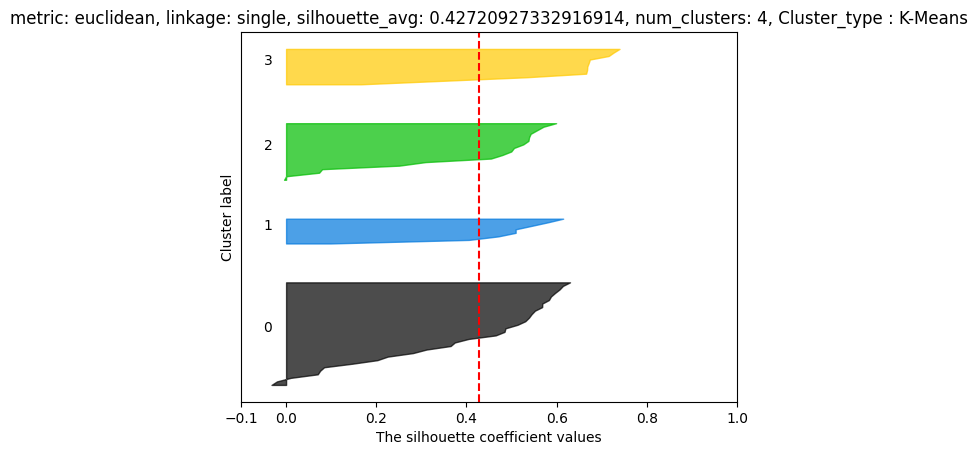

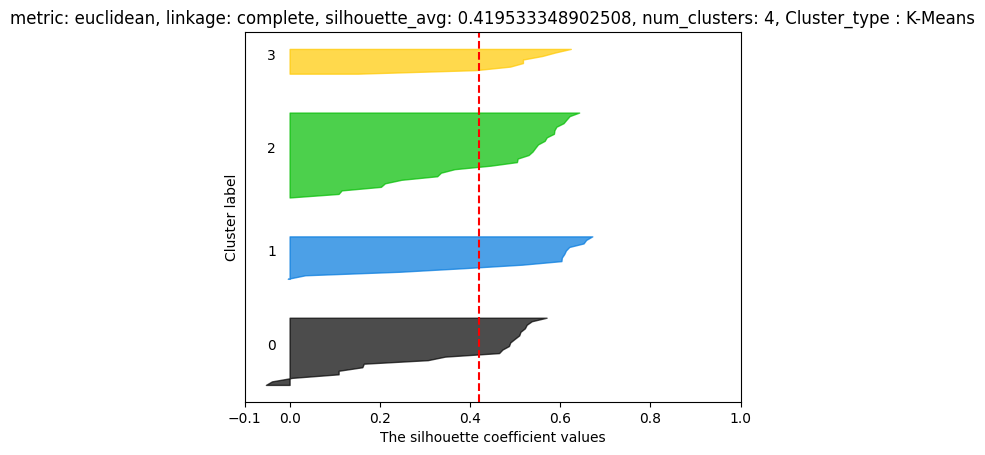

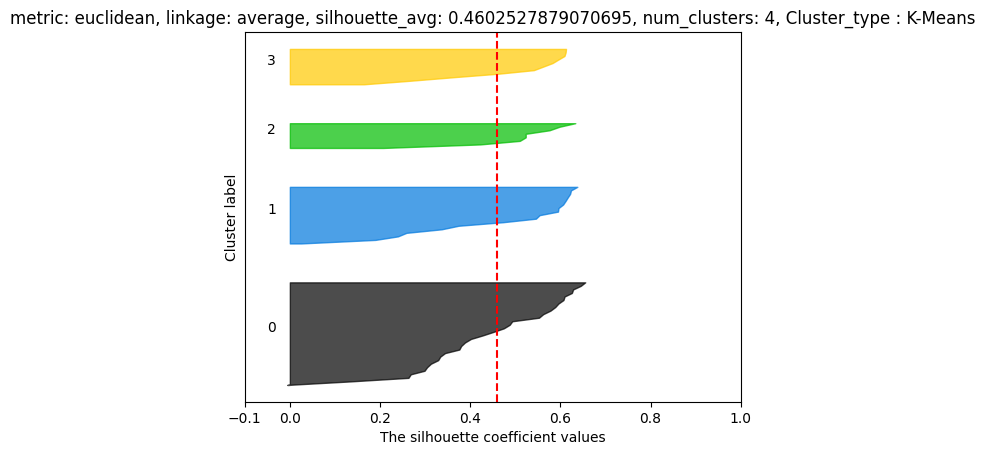

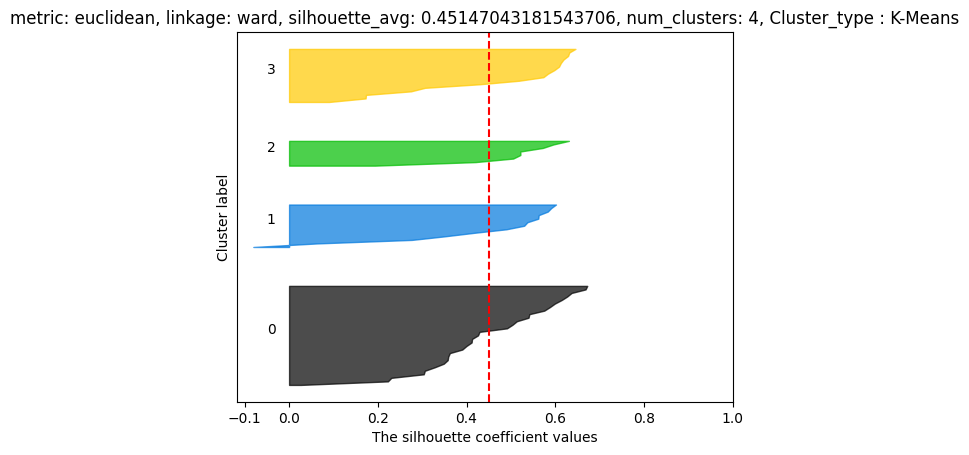

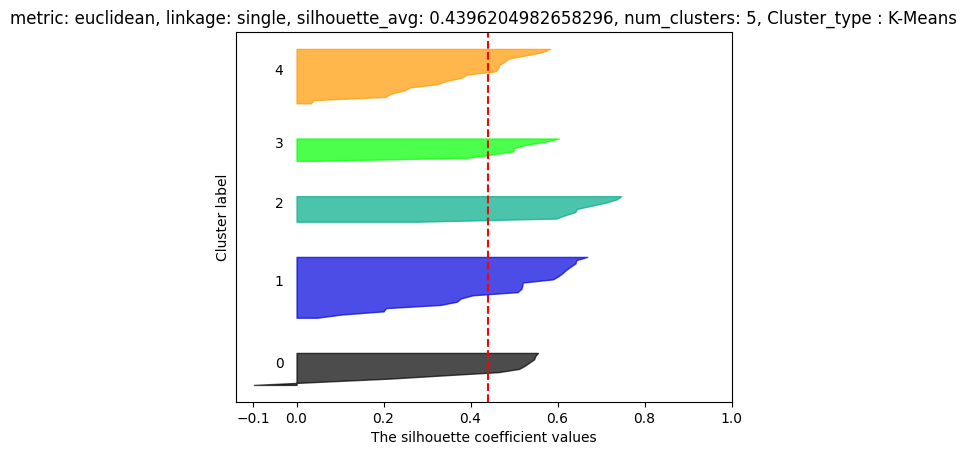

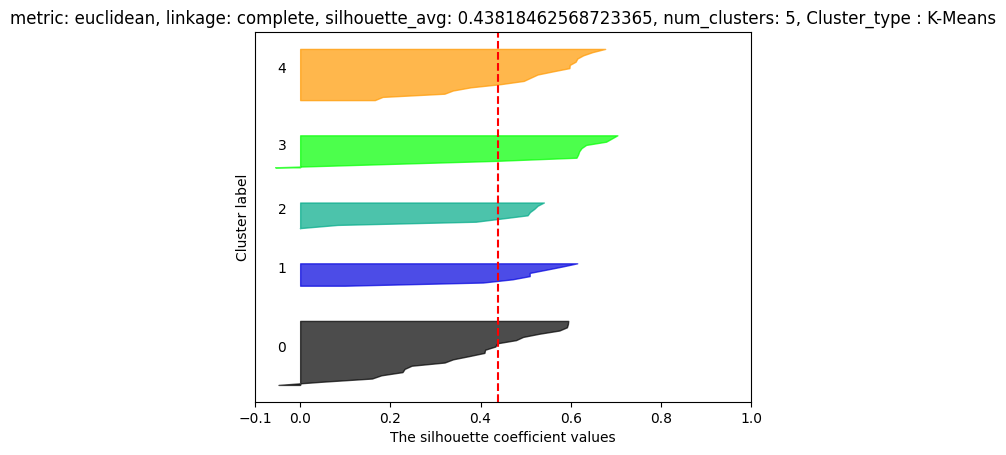

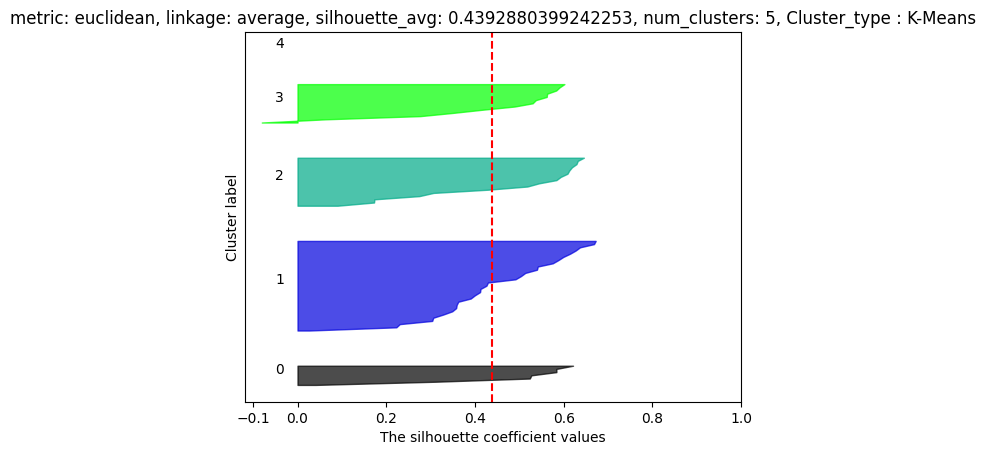

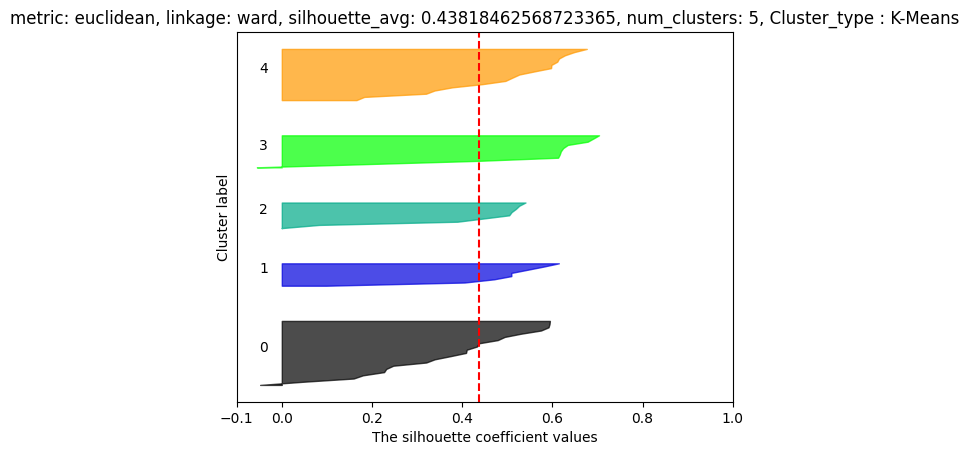

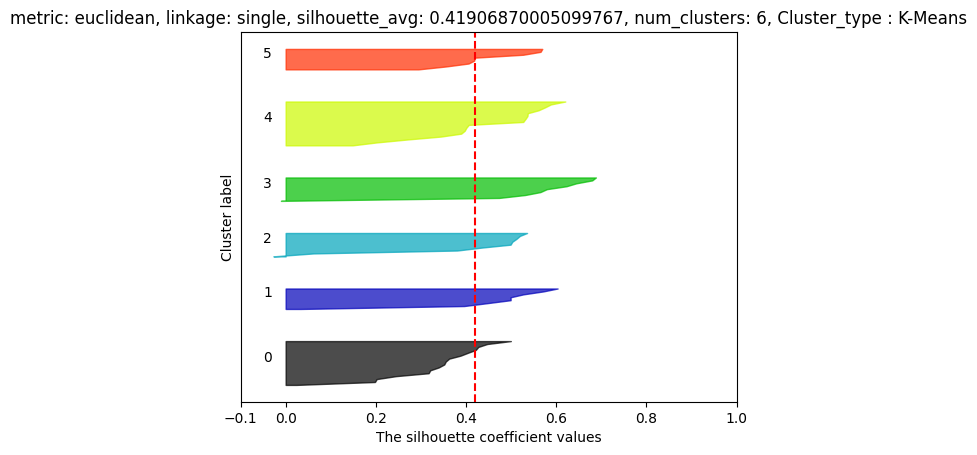

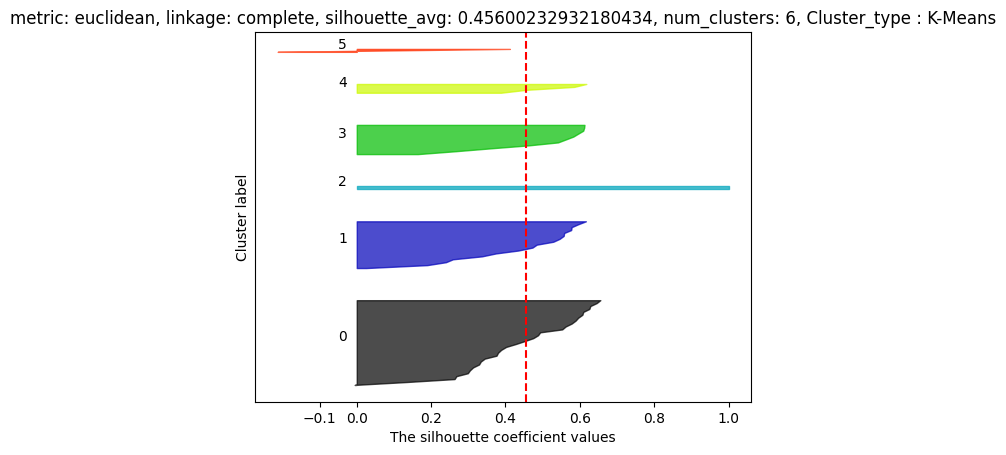

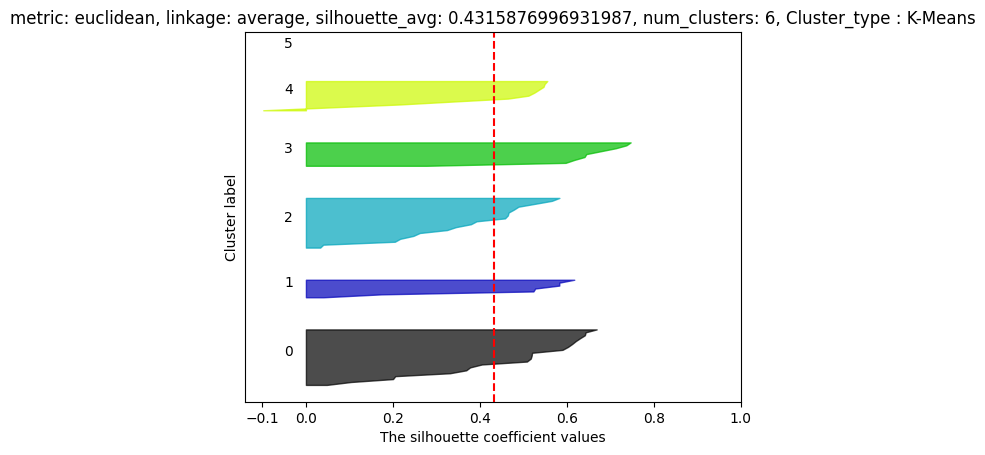

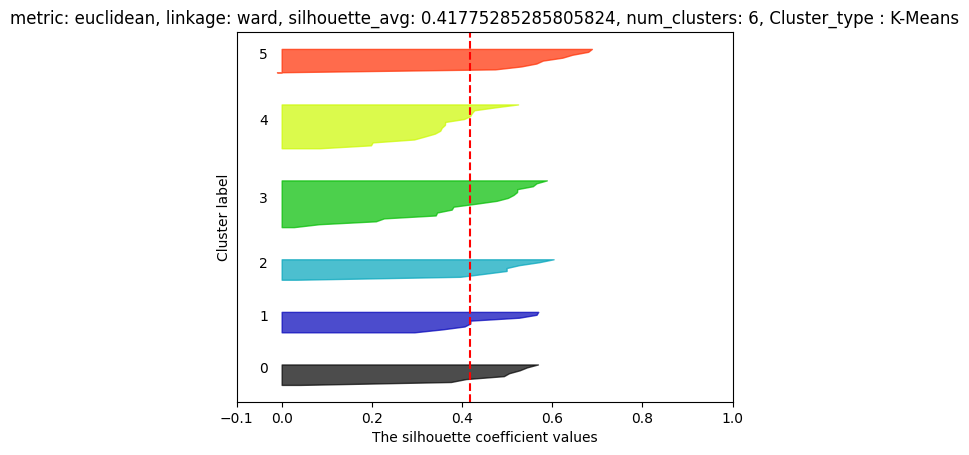

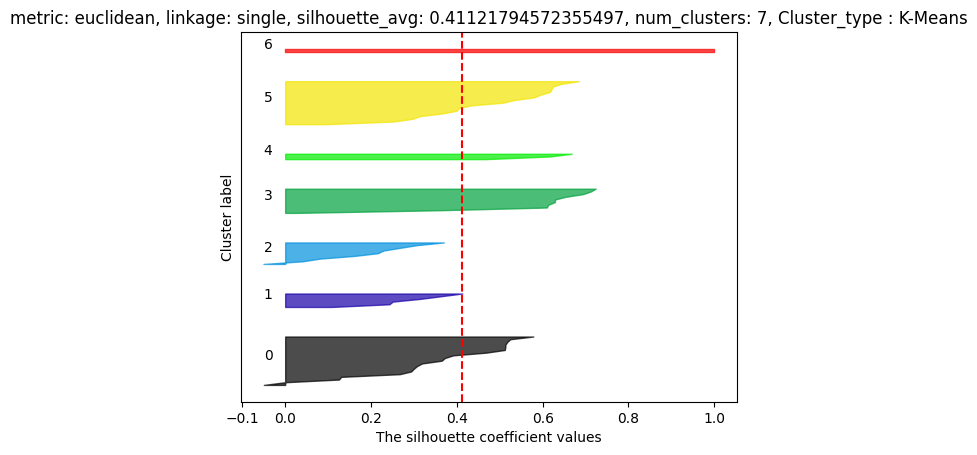

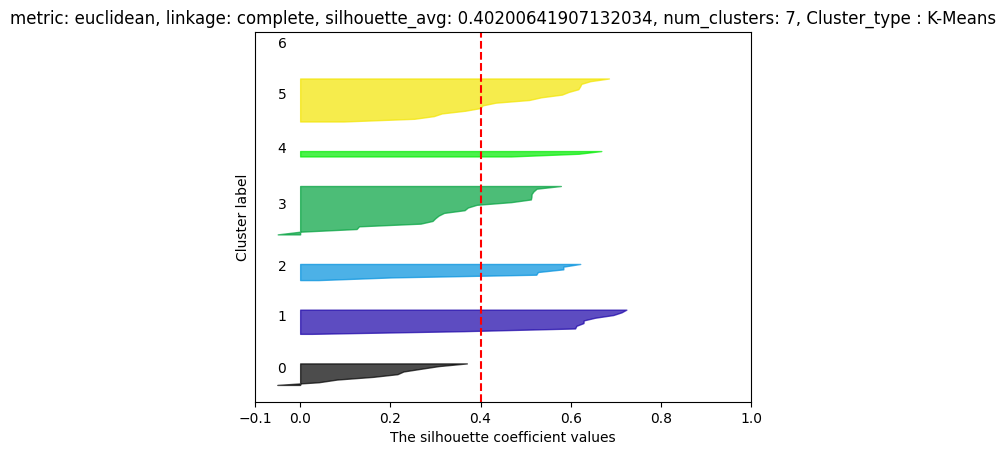

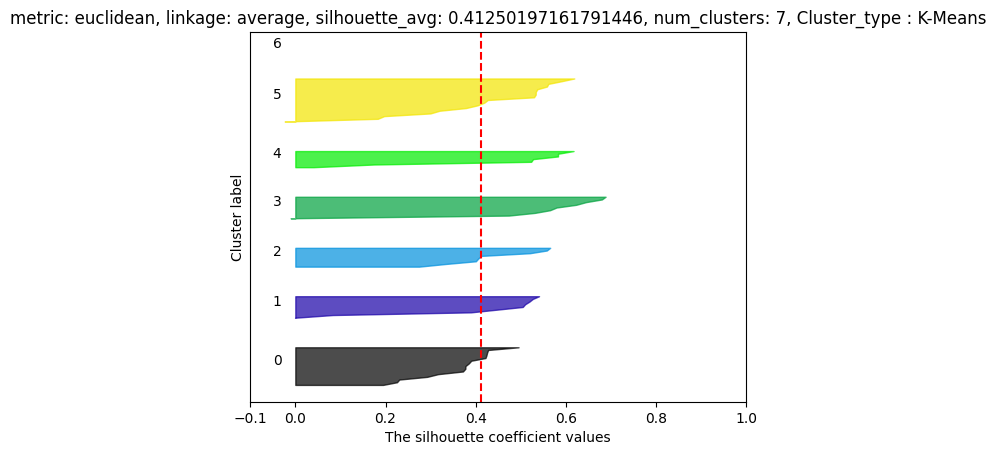

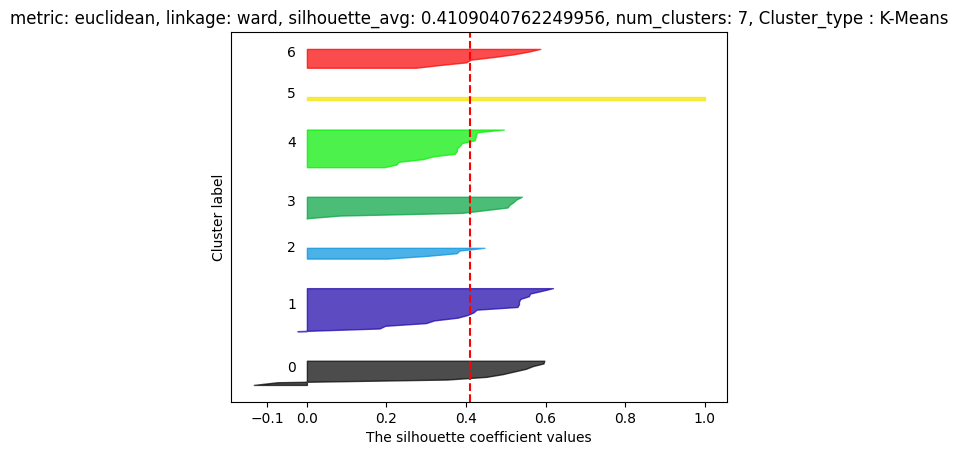

In [224]:
"""
Identify kmeans clustering parameter combination with best silhouette score for trend and seasonality stat features

"""

metrics = ['euclidean']
methods = ['single','complete','average','ward']
clustering_type = 'K-Means'

kmeans_result_comb = []

for num_cluster in range(4,8,1):
    for metric in metrics:
        for method in methods:
            km = TimeSeriesKMeans(n_clusters=num_cluster, metric=metric)
            km.fit(X_train_normalized)
            #plot_stations_of_clusters(km.labels_, Dim_Red_unmet_60min_outflow_week_df,'unmet_demand')
            silhouette_avg, num_neg_silhouette_scores, min_silhouette_score,dev_from_mean_num_zone = plot_silhouette_scores(X_train_normalized,km.labels_,metric,method,clustering_type)
            kmeans_result_comb.append([silhouette_avg,num_neg_silhouette_scores, min_silhouette_score,metric,method,num_cluster,dev_from_mean_num_zone ])


In [225]:
"""
Shortlist kmeans clustering for TS trend stats features

"""

kmeans_result_comb_df = pd.DataFrame(kmeans_result_comb,columns=["silhouette_avg","num_neg_silhouette_scores", "min_silhouette_score","metric","method","num_clusters","dev_from_mean_num_zone"])

sorted_best_kmeans_result_comb = kmeans_result_comb_df.sort_values(by=['num_neg_silhouette_scores','dev_from_mean_num_zone','min_silhouette_score'],ascending=[True,True,False])

sorted_best_kmeans_result_comb

silhouette_avg  num_neg_silhouette_scores  min_silhouette_score  \
11        0.417753                          1             -0.010507   
4         0.439620                          1             -0.098088   
3         0.451470                          1             -0.080629   
2         0.460253                          1             -0.005643   
10        0.431588                          1             -0.098088   
6         0.439288                          1             -0.080629   
8         0.419069                          2             -0.027161   
9         0.456002                          2             -0.212683   
5         0.438185                          3             -0.055311   
7         0.438185                          3             -0.055311   
1         0.419533                          3             -0.052567   
14        0.412502                          3             -0.023714   
0         0.427209                          3             -0.032329   
12        0.411218                          3             -0.050681   
13        0.402006                          3             -0.050681   
15        0.410904                          4             -0.133443   

       metric    method  num_clusters  dev_from_mean_num_zone  
11  euclidean      ward             6               22.000000  
4   euclidean    single             5               23.200000  
3   euclidean      ward             4               25.000000  
2   euclidean   average             4               28.000000  
10  euclidean   average             6               32.000000  
6   euclidean   average             5               37.200000  
8   euclidean    single             6               20.000000  
9   euclidean  complete             6               50.000000  
5   euclidean  complete             5               23.200000  
7   euclidean      ward             5               23.200000  
1   euclidean  complete             4               24.000000  
14  euclidean   average             7               26.285714  
0   euclidean    single             4               28.000000  
12  euclidean    single             7               35.428571  
13  euclidean  complete             7               35.428571  
15  euclidean      ward             7               27.428571

In [226]:
"""
SHORTLISTED K-means clustering parameters combination for stats features

"""

plt.close('all')

plot_title = 'TS statistical features'
mother = 'rbio2.2'
limit_level = 2
trend_angular_labels = ["Average Demand",'no_mean_crossing', "n95 demand", "Zero demands", "skewness"]

metrics = [sorted_best_kmeans_result_comb.iloc[0]['metric']]
methods = [sorted_best_kmeans_result_comb.iloc[0]['method']]
clustering_type = 'K-Means'
num_clusters_list = [sorted_best_kmeans_result_comb.iloc[0]['num_clusters']]

for num_cluster in num_clusters_list:
    for metric in metrics:
        for method in methods:
            kmeans_model = TimeSeriesKMeans(n_clusters=num_cluster, metric=metric)
            kmeans_model.fit(X_train_normalized)
            silhouette_avg, num_neg_silhouette_scores, min_silhouette_score,dev_from_mean_num_zone = plot_silhouette_scores(X_train_normalized,kmeans_model.labels_,metric,method,clustering_type)
            clustering_result_dict,all_cluster_feat_mins,all_cluster_feat_maxs = plot_stations_of_clusters(kmeans_model.labels_, zone_met_10m_outflow_df,'met_demand',X_train_normalized,X_train_inv_normalized,'par_coords',trend_angular_labels,plot_title,mother,limit_level)




Output hidden; open in https://colab.research.google.com to view.

In [227]:
"""
Visualize cluster representatives from every_days_avg_dem Time series statistical features using parcoords plot

"""

#Add dummy outliers
# all_cluster_feat_mins = np.append( np.random.randint(0,1,(5,)) , all_cluster_feat_mins)
# all_cluster_feat_maxs = np.append( np.random.randint(0,1,(5,)) , all_cluster_feat_maxs)

plot_cluster_representatives(X_train_normalized, all_cluster_feat_mins, all_cluster_feat_maxs,'par_coords',trend_angular_labels)

In [228]:
"""
Rank cluster from "highest demand" to "lowest demand" vaguely without the outlier.
"""
num_clusters = len(np.unique(kmeans_model.labels_))
num_features = X_train_normalized.shape[1]

ranked_clusters = rank_clusterings(all_cluster_feat_mins,all_cluster_feat_maxs,num_clusters,num_features) # exclude outliers
ranked_clusters

{0: 5, 1: 1, 2: 3, 3: 0, 4: 4, 5: 2}

In [229]:
"""
Display different ranked clusters on the same map
"""

colormap = plt.cm.RdYlGn  # Diverging red to green colormap
norm = mcolors.Normalize(vmin=min(ranked_clusters.keys()), vmax=max(ranked_clusters.keys()))

map_center = [40.7831, -73.9712]  # Manhattan coordinates (latitude, longitude)
map_zoom = 12  # Adjust the zoom level as needed
my_map = folium.Map(location=map_center, zoom_start=map_zoom,width='70%', height='70%')

marker_color = [ 'black','darkred','red','lightred','lightgreen','green','darkgreen',    'lightblue',    'blue',    'darkblue',]

for cluster in clustering_result_dict.keys(): # ourliers included
  stations = clustering_result_dict[cluster]
  color = mcolors.to_hex(colormap(norm(cluster)))
  for station in stations:
    folium.Marker(location=zone_to_gps_dict[int(station)], popup=str(station)+': '+color+'-'+str(cluster), icon=folium.Icon(color=marker_color[cluster+1]),tooltip=str(cluster)).add_to(my_map)
display(my_map)

In [230]:
"""
Decide which is the best clustering option/method out of the 3 clustering methods

"""

## Best results from each clustering

# hdbscan_best_score_comb_df = pd.DataFrame( {'dbcv':hdbscan_best_score_comb[-1][0] ,'num_outliers':hdbscan_best_score_comb[-1][1][5],'num_clusters': hdbscan_best_score_comb[-1][1][0], \
#                                             'min_cluster_size': hdbscan_best_score_comb[-1][1][1], 'min_samples': hdbscan_best_score_comb[-1][1][2], \
#                                             'cluster_selection_method': hdbscan_best_score_comb[-1][1][3], 'metric': hdbscan_best_score_comb[-1][1][4],},index=range(1)).transpose()

# sorted_best_agglomerative_result_comb_df = pd.DataFrame(sorted_best_agglomerative_result_comb.iloc[0])
# sorted_best_kmeans_result_comb_df = pd.DataFrame(sorted_best_kmeans_result_comb.iloc[0])

best_clustering_comb = pd.DataFrame( {'dbcv/silh_avg':[hdbscan_best_score_comb[-1][0],sorted_best_agglomerative_result_comb.iloc[0]['silhouette_avg'],sorted_best_kmeans_result_comb.iloc[0]['silhouette_avg'] ], \
                                      'num_outliers/neg_silh_score':[hdbscan_best_score_comb[-1][1][5],sorted_best_agglomerative_result_comb.iloc[0]['num_neg_silhouette_scores'],sorted_best_kmeans_result_comb.iloc[0]['num_neg_silhouette_scores'] ], \
                                      'min_silhouette_score':[np.NaN,sorted_best_agglomerative_result_comb.iloc[0]['min_silhouette_score'],sorted_best_kmeans_result_comb.iloc[0]['min_silhouette_score']],
                                      'num_clusters': [hdbscan_best_score_comb[-1][1][0],sorted_best_agglomerative_result_comb.iloc[0]['num_clusters'],sorted_best_kmeans_result_comb.iloc[0]['num_clusters'] ], \
                                      'metric': [hdbscan_best_score_comb[-1][1][4],sorted_best_agglomerative_result_comb.iloc[0]['metric'], sorted_best_kmeans_result_comb.iloc[0]['metric']], \
                                      },index=['hdbscan','agglomerative','kmeans'])

#TODO: shortlist clustering results based on hyperparamter conditions

model_labels = {'hdbscan':hdbscan_model.labels_,'agglomerative':agglomerative_model.labels_,'kmeans':kmeans_model.labels_}

sorted_best_clustering_comb = best_clustering_comb.sort_values(['num_outliers/neg_silh_score'],ascending=[True])
chosen_model = sorted_best_clustering_comb.index[0] # select the clustering method with minimum number of outliers.

sorted_best_clustering_comb


dbcv/silh_avg  num_outliers/neg_silh_score  \
hdbscan             0.132865                           24   
agglomerative       0.458788                            1   
kmeans              0.417753                            1   

               min_silhouette_score  num_clusters     metric  
hdbscan                         NaN             6  euclidean  
agglomerative             -0.164222             4  euclidean  
kmeans                    -0.010507             6  euclidean

In [231]:
"""
save final cluster labels results
"""
final_cluster_labels_df = pd.DataFrame(data={manhat_demand.index[-1]:model_labels[chosen_model]},index=range(0,len(model_labels[chosen_model]),1))
final_cluster_labels_df.to_csv('Manhattan_final_cluster_result_'+ str(manhat_demand.index[-1])+'.csv')


In [ ]:
"""
APPENDIX

"""

Average (mean) for r=1: 2.33
Skewness for r=1: 2.03
Kurtosis for r=1: 6.13
Average (mean) for r=5: 11.67
Skewness for r=5: 0.91
Kurtosis for r=5: 1.23
Average (mean) for r=10: 23.33
Skewness for r=10: 0.64
Kurtosis for r=10: 0.61
Average (mean) for r=20: 46.67
Skewness for r=20: 0.45
Kurtosis for r=20: 0.31


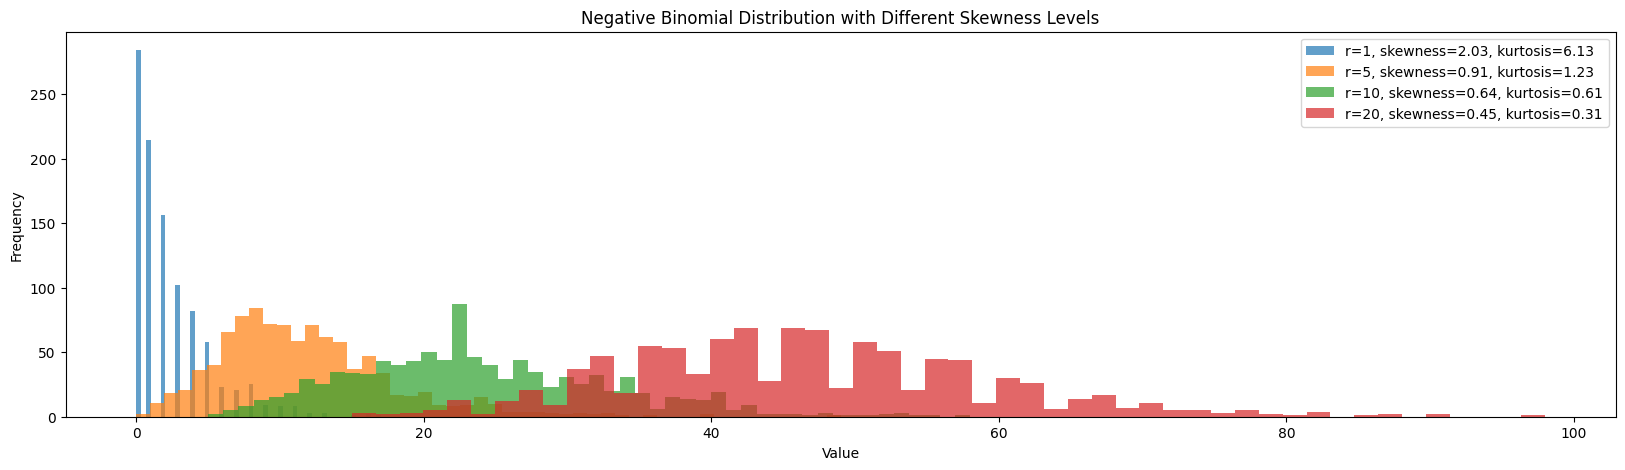

In [234]:
"""
Reference: Visualize negative binomial distribution of different kurtosis and skewness

"""


import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import nbinom

def plot_negative_binomial_skewness(r_values, p):
    fig = plt.figure(figsize=(20,5))
    for r in r_values:
        # Generate the negative binomial distribution
        data = nbinom.rvs(r, p, size=1000)

        # Calculate statistics
        average = nbinom.mean(r, p)
        skewness = nbinom.stats(r, p, moments='s')
        kurtosis = nbinom.stats(r, p, moments='k')

        # Plot histogram
        plt.hist(data, bins=50, alpha=0.7, label=f'r={r}, skewness={skewness:.2f}, kurtosis={kurtosis:.2f}')

        print(f"Average (mean) for r={r}: {average:.2f}")
        print(f"Skewness for r={r}: {skewness:.2f}")
        print(f"Kurtosis for r={r}: {kurtosis:.2f}")

    plt.legend()
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Negative Binomial Distribution with Different Skewness Levels')
    plt.show()

# Parameters
r_values = [1, 5, 10, 20]  # Different values of r
p = 0.3                # Probability of success in each trial

# Plot and calculate statistics
plot_negative_binomial_skewness(r_values, p)


In [236]:
"""
Refernce: Visualize different values of skewness and kurtosis using normal distribution
"""


import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, skew, kurtosis, gaussian_kde
import ipywidgets as widgets
from ipywidgets import interactive

def plot_skew_kurt(skewness, kurtosis):
    # Generate a normal distribution with given skewness and kurtosis
    mean = 0  # Mean of the normal distribution
    std = 1   # Standard deviation of the normal distribution

    # Calculate the parameters of the normal distribution based on the specified skewness and kurtosis
    if kurtosis < 3:
        sigma = 1  # Set the default standard deviation for a normal distribution
    else:
        sigma = np.sqrt((kurtosis - 3) / 4)

    alpha = skewness * np.sqrt((kurtosis - 1) / 2)

    # Generate the random data points from the skewed normal distribution
    size = 10000
    data = mean + std * np.random.randn(size) + alpha * (np.random.randn(size) ** 2 - 1)

    # Generate data points for KDE plot
    x = np.linspace(data.min(), data.max(), 1000)
    kde = gaussian_kde(data)
    y = kde(x)

    # Plot the KDE curve
    plt.figure(figsize=(10, 4))
    plt.plot(x, y, 'r', linewidth=2)
    y = norm.pdf(x, loc=0, scale=1)
    plt.plot(x, y, 'g', linewidth=2)

    plt.title(f"Normal Distribution (Skewness={skewness:.2f}, Kurtosis={kurtosis:.2f})")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.xlim((-5,10))
    plt.grid(True)
    plt.show()

# Create sliders for skewness and kurtosis using ipywidgets and combine them with the interactive function
skewness_slider = widgets.FloatSlider(min=-5.0, max=5.0, step=0.1, value=0.0, description="Skewness:")
kurtosis_slider = widgets.FloatSlider(min=0.0, max=10.0, step=0.1, value=3.0, description="Kurtosis:")

interactive_plot = interactive(plot_skew_kurt, skewness=skewness_slider, kurtosis=kurtosis_slider)
output = interactive_plot.children[-1]
output.layout.height = '400px'
interactive_plot


interactive(children=(FloatSlider(value=0.0, description='Skewness:', max=5.0, min=-5.0), FloatSlider(value=3.…

In [ ]:
"""
Plot all the wavelets to identify suitable mother wavelet for our demand time series
"""

"""
def plot_wav_families(discrete_wavelets):
    fig,ax = plt.subplots(nrows=1,ncols=len(discrete_wavelets),figsize=(25,3))
    for col_no, waveletname in enumerate(discrete_wavelets):
        wavelet = pywt.Wavelet(waveletname)
        family_name = wavelet.family_name
        biorthogonal = wavelet.biorthogonal
        orthogonal = wavelet.orthogonal
        symmetry = wavelet.symmetry

        _ = wavelet.wavefun()
        wavelet_function = _[0]
        x_values = _[-1]

        ax[col_no].set_title("{}".format(waveletname), fontsize=16)
        ax[col_no].plot(x_values, wavelet_function)

    plt.show()
    return

for i in range(11):
  discrete_wavelets = pywt.wavelist(kind='discrete')[i*10:i*10 + 10]
  plot_wav_families(discrete_wavelets)
"""

/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning:

Level value of 8 is too high: all coefficients will experience boundary effects.



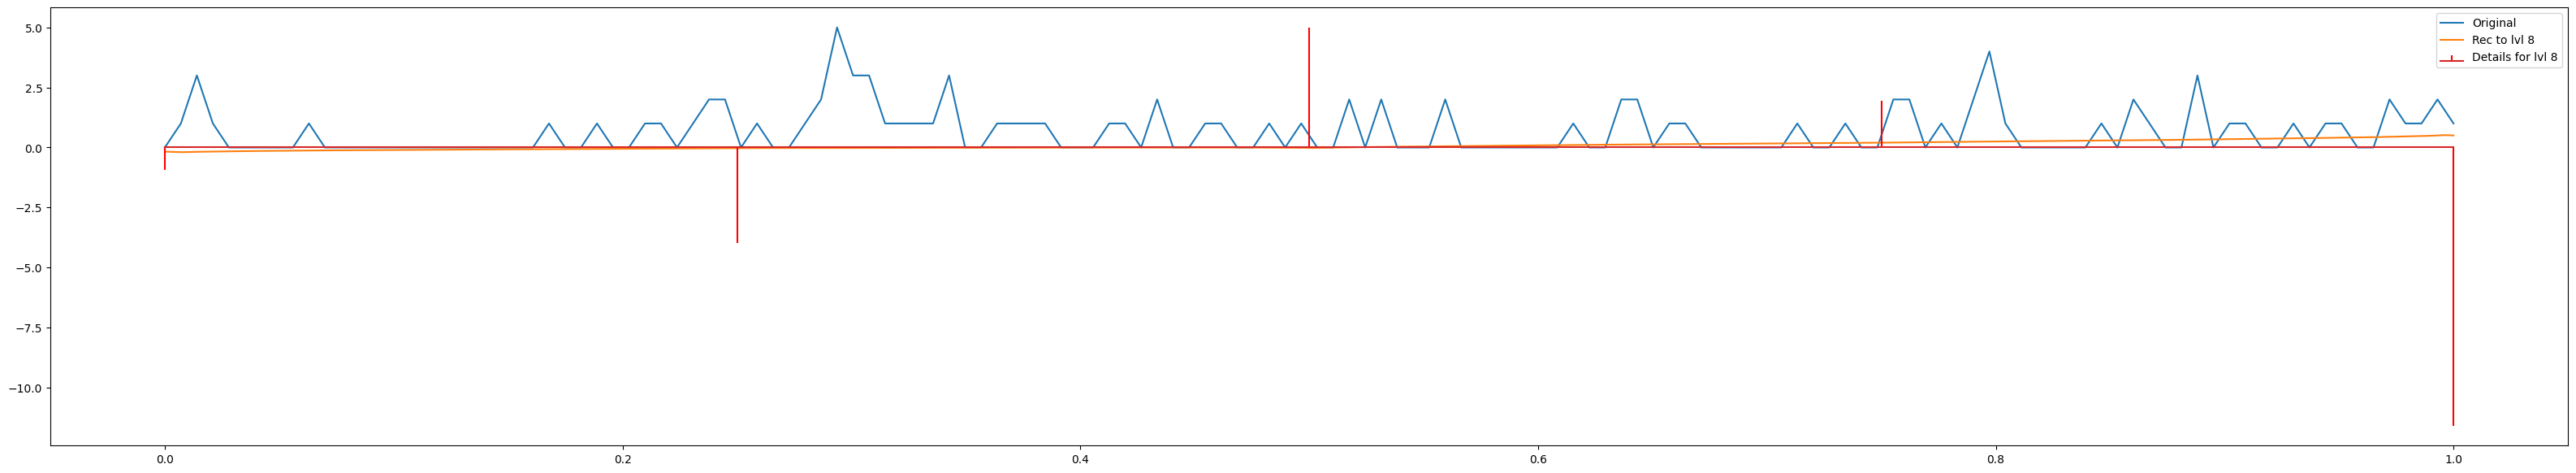

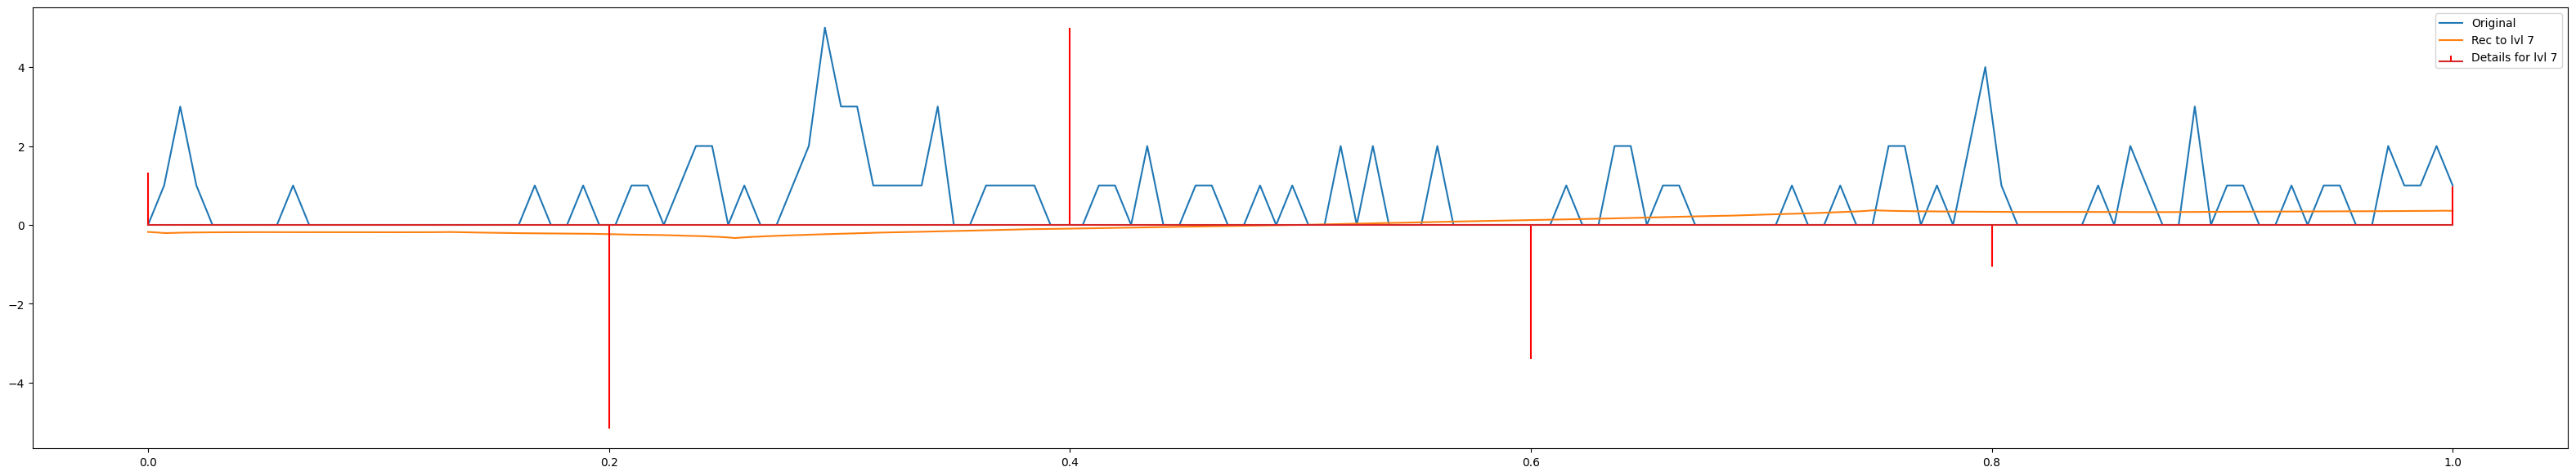

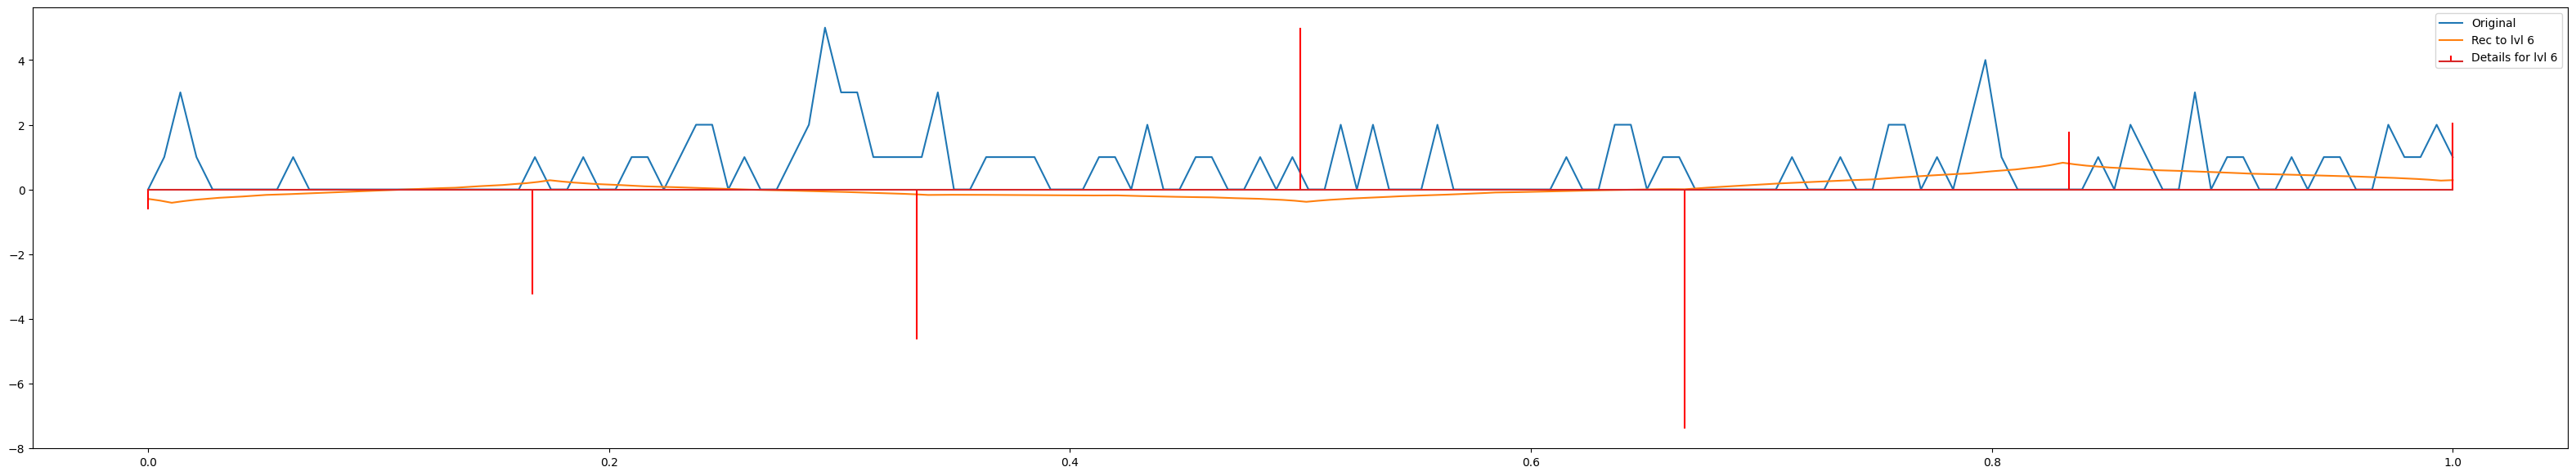

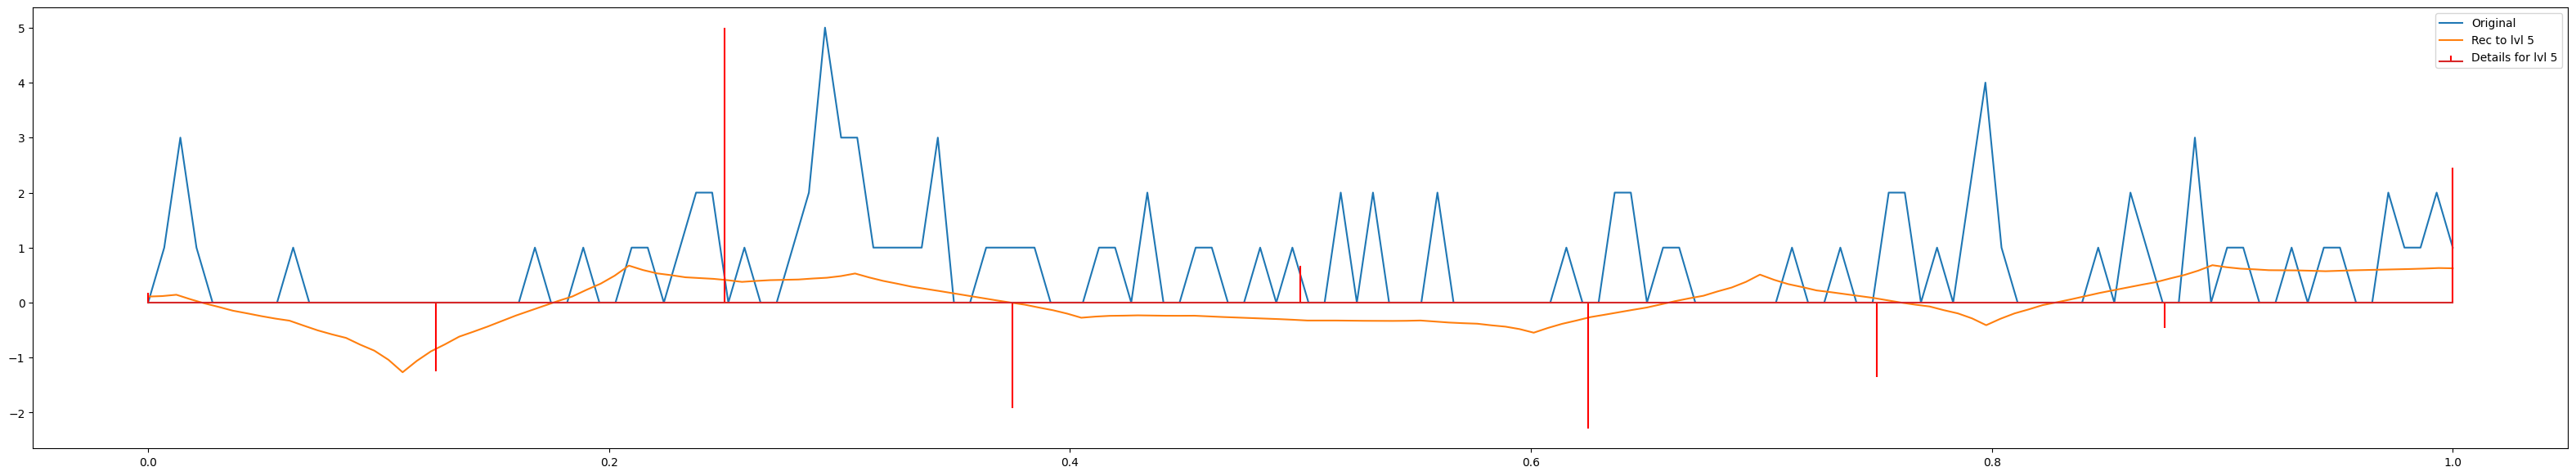

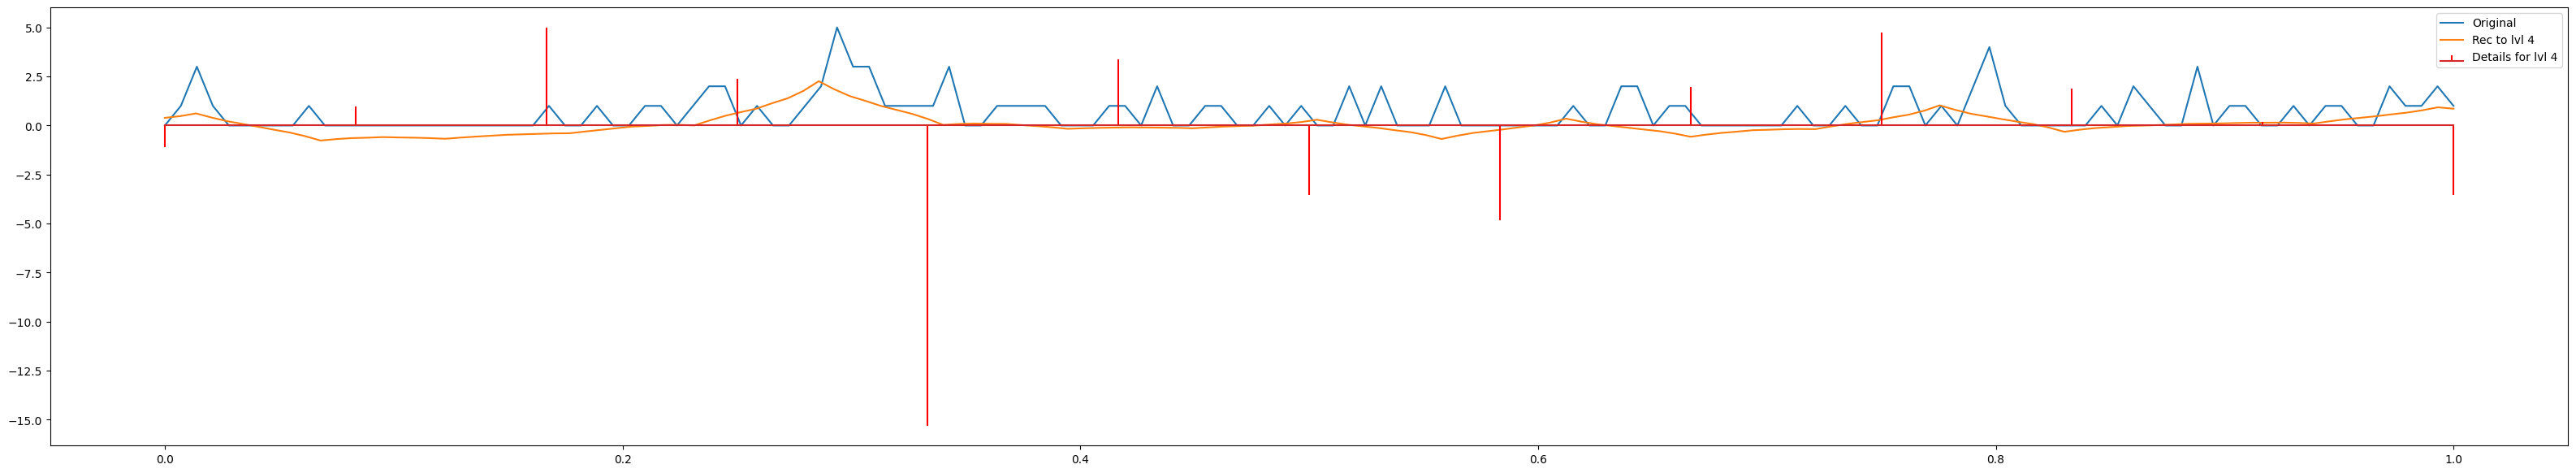

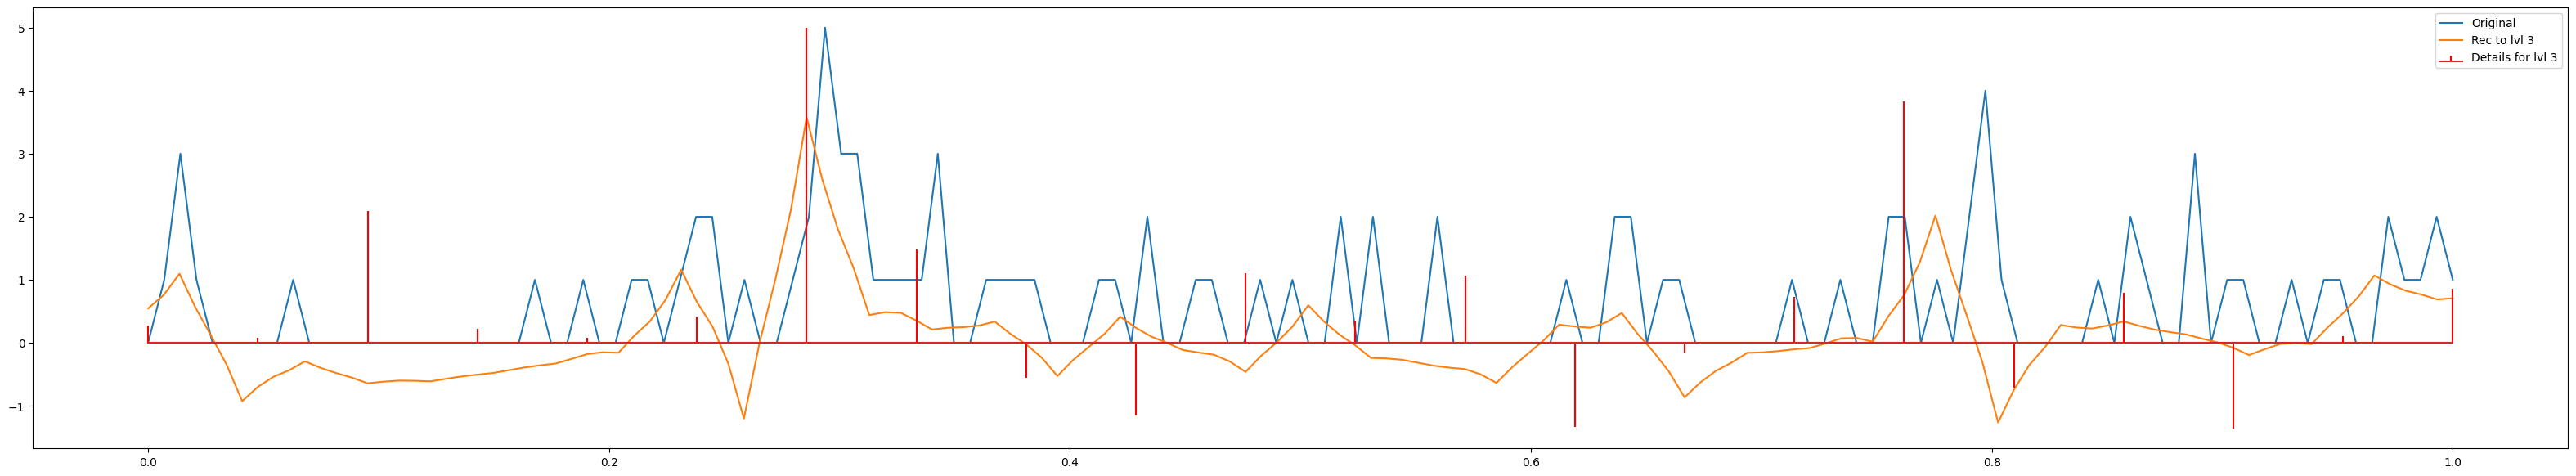

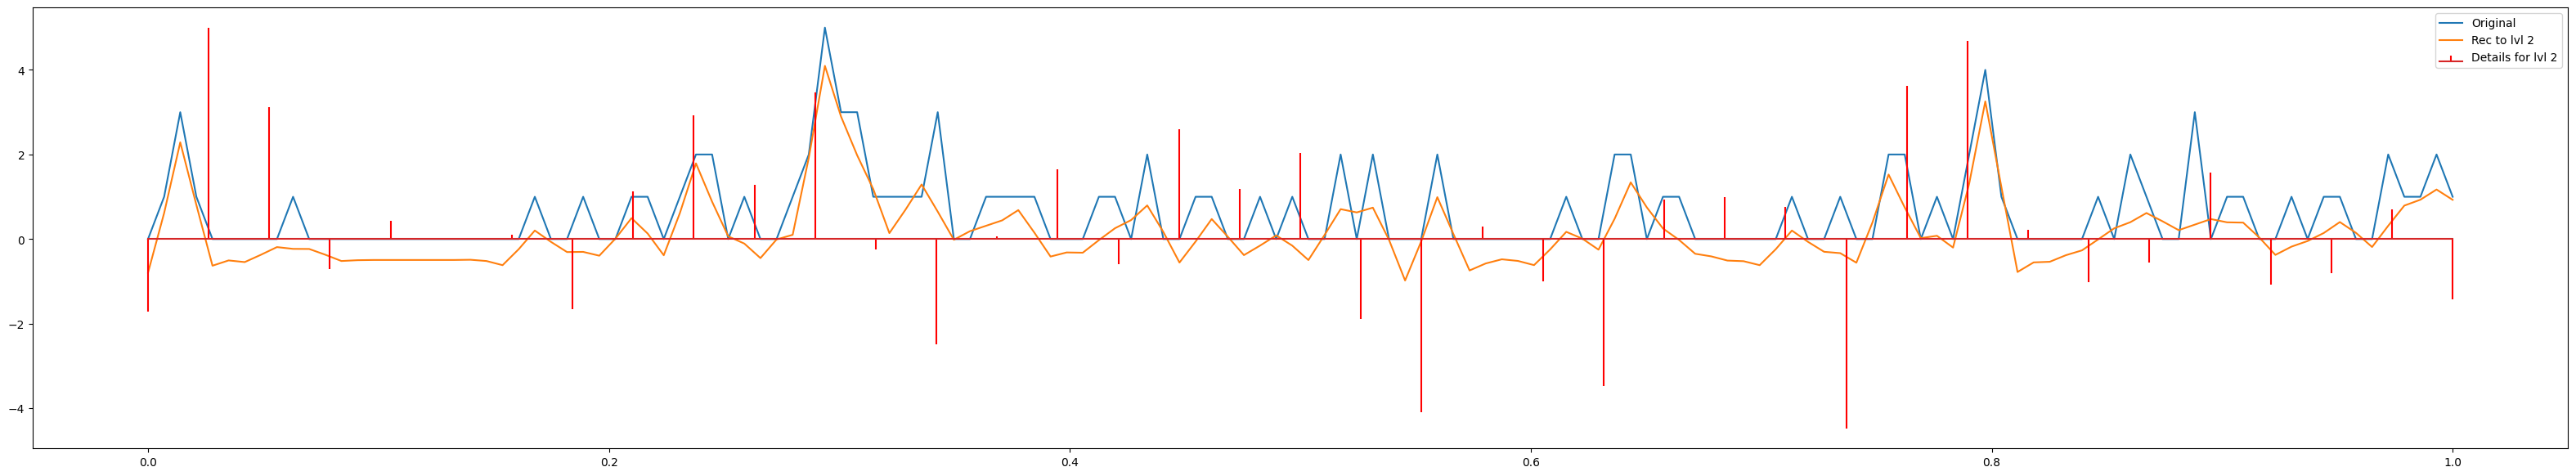

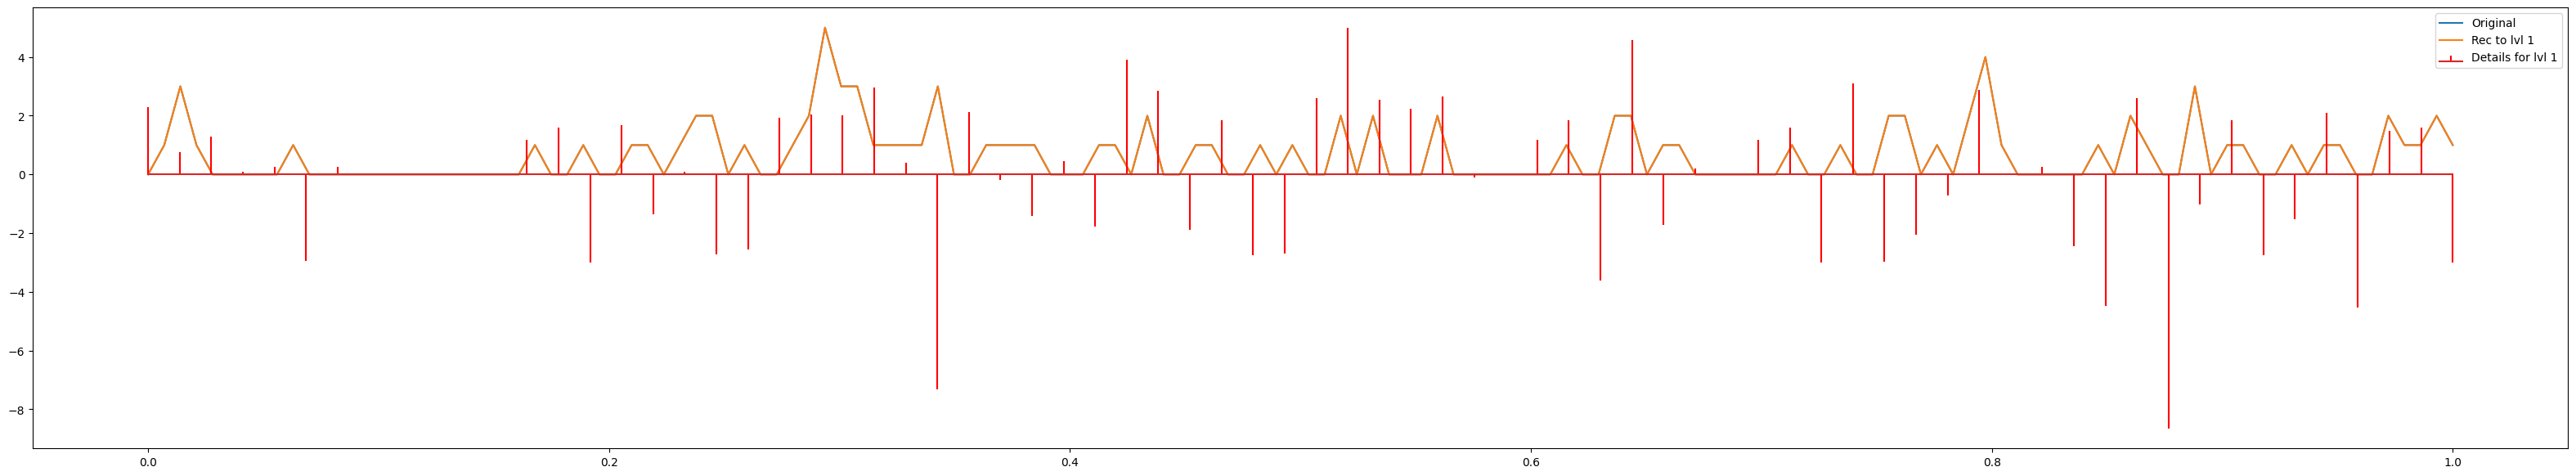

In [237]:
"""                                                                     FEATURE Extraction

Visualize detail coefficients in inverse Discrete Wavelet Transform

"""

plt.close('all')

def reconstruction_plot(yyy, **kwargs):
    ###"""Plot signal vector on x [0,1] independently of amount of values it contains."""
    #plt.figure()
    #plt.plot(np.linspace(0, 1, len(yyy)), yyy, **kwargs)
    ym = np.median(yyy)
    plt.plot(np.linspace(0, 1., num=len(yyy)), yyy-ym, **kwargs)


def reconstruction_stem(yyy, xmax, **kwargs):
    ###"""Plot coefficient vector on x [0,1] independently of amount of values it contains."""
    ymax = yyy.max()
    plt.stem(np.linspace(0, 1., num=len(yyy)), yyy*(xmax/ymax), **kwargs)


### original ecg data
### x = pywt.data.ecg()
### w = pywt.Wavelet('sym5')
x = manhat_demand['5'].values
w = pywt.Wavelet('coif1')
nl = 8
coeffs = pywt.wavedec(x, w, level=nl)


'''
plt.figure()
plt.stem(coeffs[1]); plt.legend(['Lvl 6 detail coefficients'])
plt.figure()
plt.stem(coeffs[2]); plt.legend(['Lvl 5 detail coefficients'])
plt.figure()
plt.stem(coeffs[3]); plt.legend(['Lvl 4 detail coefficients'])
plt.figure()
plt.stem(coeffs[4]); plt.legend(['Lvl 3 detail coefficients'])
plt.figure()
plt.stem(coeffs[5]); plt.legend(['Lvl 2 detail coefficients'])
plt.figure()
plt.stem(coeffs[6]); plt.legend(['Lvl 1 detail coefficients'])
'''


xmax = x.max()
for i in range(nl):
    plt.figure(figsize=(40,7))
    reconstruction_plot(x) # original signal
    #reconstruction_plot(pywt.waverec(coeffs, w)) # full reconstruction
    reconstruction_plot(pywt.waverec(coeffs[:i+2] + [None] * (nl-i-1), w)) # partial reconstruction
    reconstruction_stem(coeffs[i+1], xmax, markerfmt ='none', linefmt='r-')
    #plt.legend(['Original', 'Full reconstruction', ('Rec to lvl %d')%(nl-i), ('Details for lvl %d')%(nl-i)])
    plt.legend(['Original', ('Rec to lvl %d')%(nl-i), ('Details for lvl %d')%(nl-i)])



In [238]:
"""                                                                     FEATURE Extraction

Feature extracted: Discrete Wavelet Transform after selecting some mother wavelets


"""
plt.close('all')

def features_info(unmet_60min_outflow_df,wave_name,limit_level):
    list_coeff = pywt.wavedec(unmet_60min_outflow_df['5'].values, wave_name)
    print('wave_name: ',wave_name)
    num_feats = 0
    for l,coeff in enumerate(list_coeff):
        lvl = max(0,l-1)
        print('level: ',lvl,' num_of_coeffs: ',len(coeff))
        if lvl <= limit_level:
            num_feats+=len(coeff)
    return num_feats

def get_stations_dwt_features(signal, waveletname,num_feats,limit_level):
    stations = signal.columns
    all_features = np.empty(shape=(0,num_feats))
    for station in stations:
        list_coeff = pywt.wavedec(signal[station].values, waveletname)
        features = np.hstack(list_coeff[:limit_level+2])
        features = features.reshape((1,num_feats))
        all_features = np.vstack((all_features,features))
    print('X_train shape: ',all_features.shape)
    return all_features


## shortlist mothers that have wavelets similar to portions of demand TS
## mothers = ['bior2.2','bior4.4','bior5.5','coif1','coif2','db3','db22','rbio2.2','rbio2.6','sym3','sym8']
## ONLY select mothers with higher multi-frequency resolution. i.e. higher depth/levels have better time localizations of frequnecy
mothers = ['bior2.2','coif1','db3','rbio2.2','sym3']
limit_level = 1 # includes this level

for mother in mothers:
    num_feats = features_info(manhat_demand,mother,limit_level)  # display number of feats
    X_train = get_stations_dwt_features(signal=manhat_demand, waveletname=mother,num_feats=num_feats,limit_level=limit_level) #choose wavelets and levels < 9, #output = 382 x 180 features

    ts_dwt_feat_transform = feat_transformation()
    X_train_dwt_normalized = ts_dwt_feat_transform.feature_normalization(X_train)

    print_msg = 'wavelet :'+mother

    break


wave_name:  bior2.2
level:  0  num_of_coeffs:  13
level:  0  num_of_coeffs:  13
level:  1  num_of_coeffs:  22
level:  2  num_of_coeffs:  39
level:  3  num_of_coeffs:  74
X_train shape:  (66, 48)


In [247]:
"""
Identify aggolmeratic clustering parameter combination with best silhouette score for DWT features

"""

plt.close('all')

mother = 'rbio2.2'
limit_level = 2 # [0,1,2,3,4]


num_feats = features_info(manhat_demand,mother,limit_level)  # display number of feats
X_train = get_stations_dwt_features(signal=manhat_demand, waveletname=mother,num_feats=num_feats,limit_level=limit_level) #choose wavelets and levels < 9, #output = 382 x 180 features

ts_dwt_feat_transform = feat_transformation()
X_train_dwt_normalized = ts_dwt_feat_transform.feature_normalization(X_train)
X_train_dwt_inv_normalized = ts_dwt_feat_transform.inv_feature_normalization(X_train_dwt_normalized)

num_clusters_list = range(3,10,1)
agglomerative_result_comb_dwt = []
clustering_type = 'agglomerative_dwt'

methods = ['single','complete','average']#['single','complete','average','weighted',]
metrics = ['euclidean','cityblock']
for metric in metrics:
    for method in methods:
        for num_clusters in num_clusters_list:
            model = AgglomerativeClustering(n_clusters=num_clusters, metric=metric, linkage=method)
            model.fit(X_train_dwt_normalized)
            labels = model.labels_
            silhouette_avg, num_neg_silhouette_scores, min_silhouette_score,dev_from_mean_num_zone = plot_silhouette_scores(X_train_dwt_normalized,labels,metric,method,clustering_type)
            agglomerative_result_comb_dwt.append([silhouette_avg,num_neg_silhouette_scores, min_silhouette_score,metric,method,num_clusters,dev_from_mean_num_zone ])


methods = ['ward']#['median','centroid','ward']
metrics = ['euclidean']
for method in methods:
    for metric in metrics:
        for num_clusters in num_clusters_list:
            model = AgglomerativeClustering(n_clusters=num_clusters, metric=metric, linkage=method)
            model.fit(X_train_dwt_normalized)
            labels = model.labels_
            silhouette_avg, num_neg_silhouette_scores, min_silhouette_score,dev_from_mean_num_zone = plot_silhouette_scores(X_train_dwt_normalized,labels,metric,method,clustering_type)
            agglomerative_result_comb_dwt.append([silhouette_avg,num_neg_silhouette_scores, min_silhouette_score,metric,method,num_clusters,dev_from_mean_num_zone ])



methods = ['complete','average']#['single','complete','average','weighted',]
metrics = ['mahalanobis','manhattan']
for metric in metrics:
    for method in methods:
        for num_clusters in num_clusters_list:
            model = AgglomerativeClustering(n_clusters=num_clusters, metric=metric, linkage=method)
            model.fit(X_train_dwt_normalized)
            labels = model.labels_
            silhouette_avg, num_neg_silhouette_scores, min_silhouette_score,dev_from_mean_num_zone = plot_silhouette_scores(X_train_dwt_normalized,labels,metric,method,clustering_type)
            agglomerative_result_comb_dwt.append([silhouette_avg,num_neg_silhouette_scores, min_silhouette_score,metric,method,num_clusters,dev_from_mean_num_zone ])


Output hidden; open in https://colab.research.google.com to view.

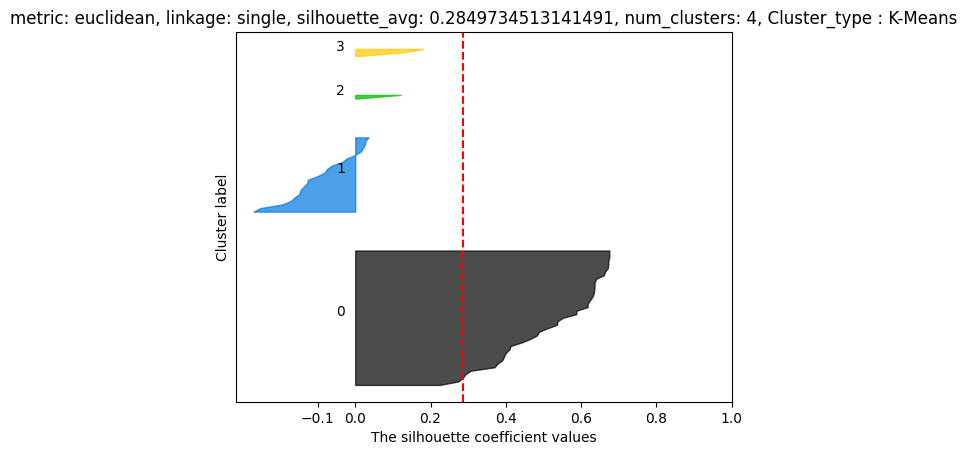

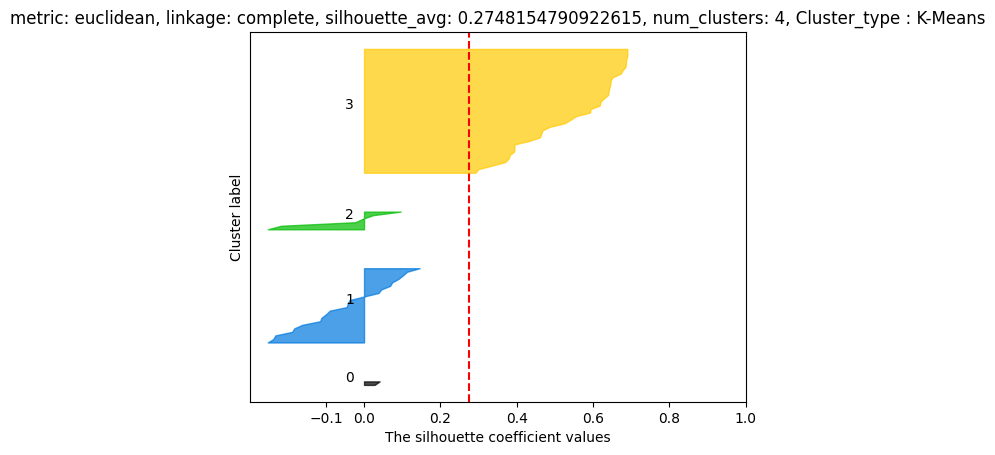

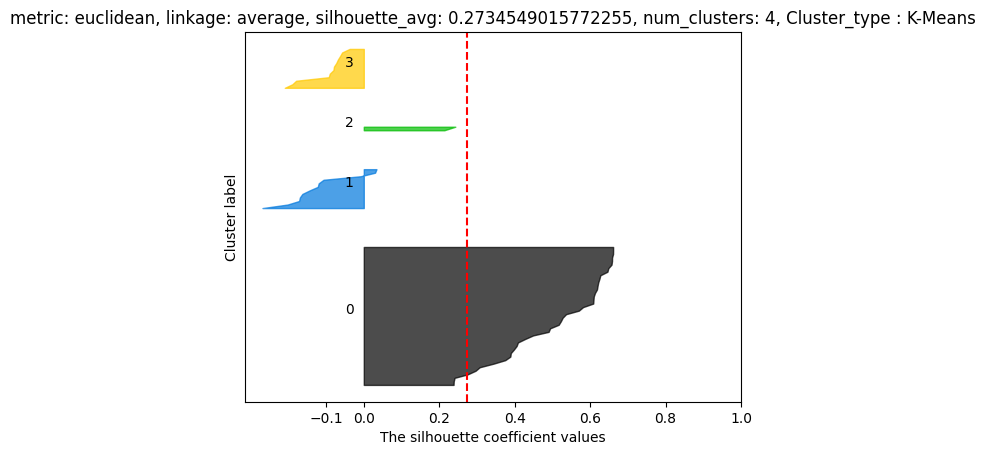

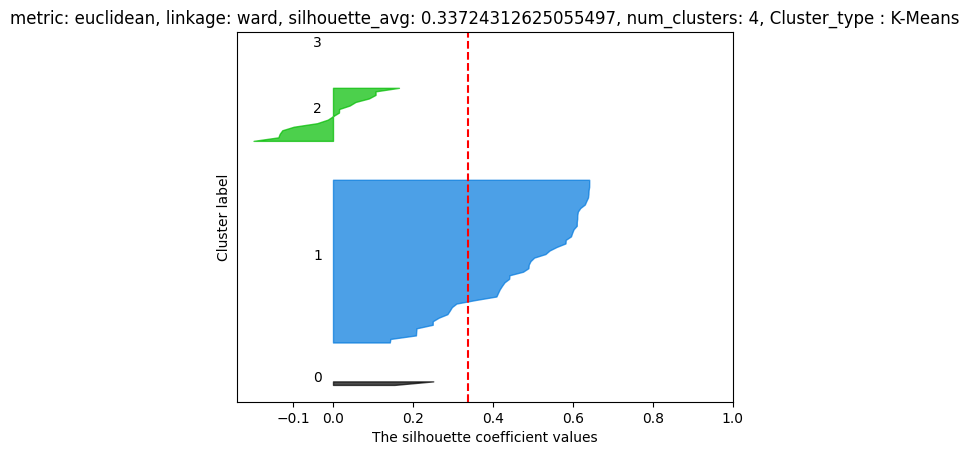

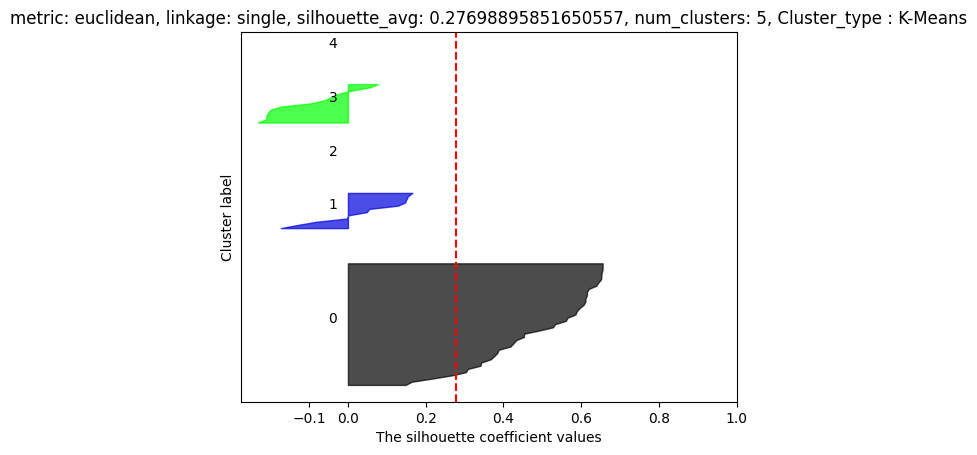

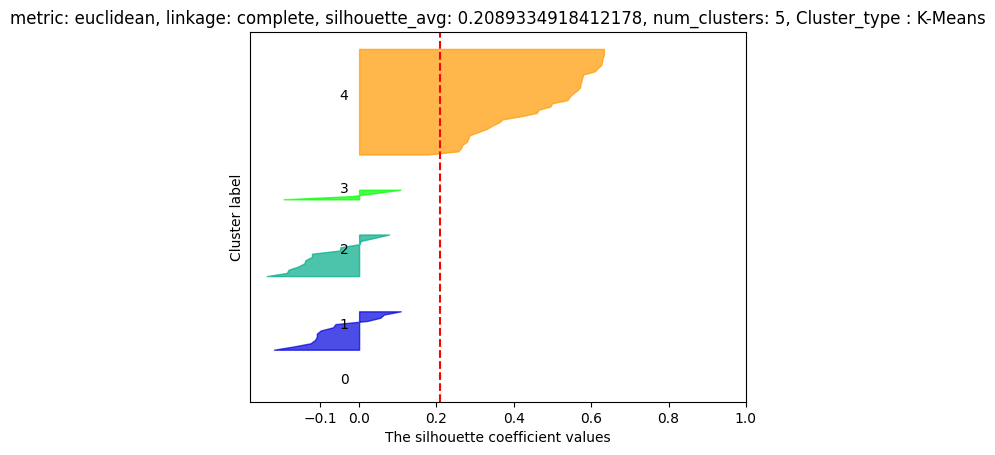

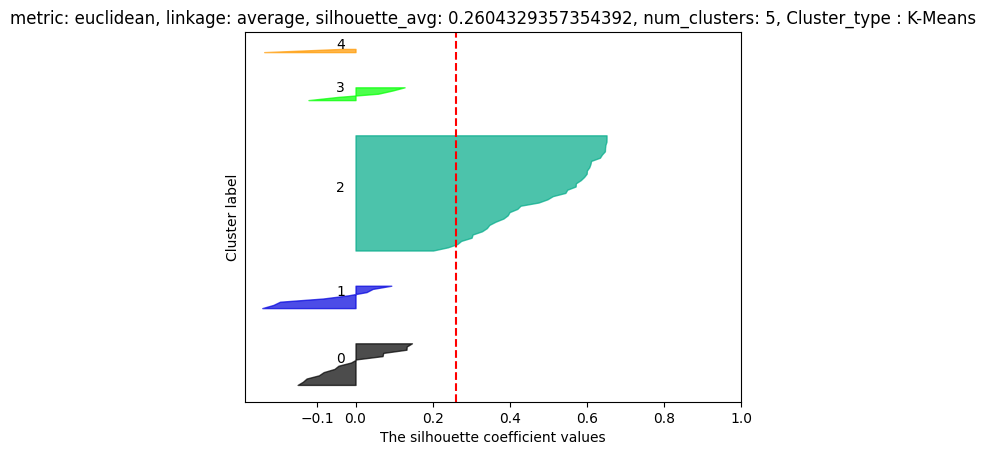

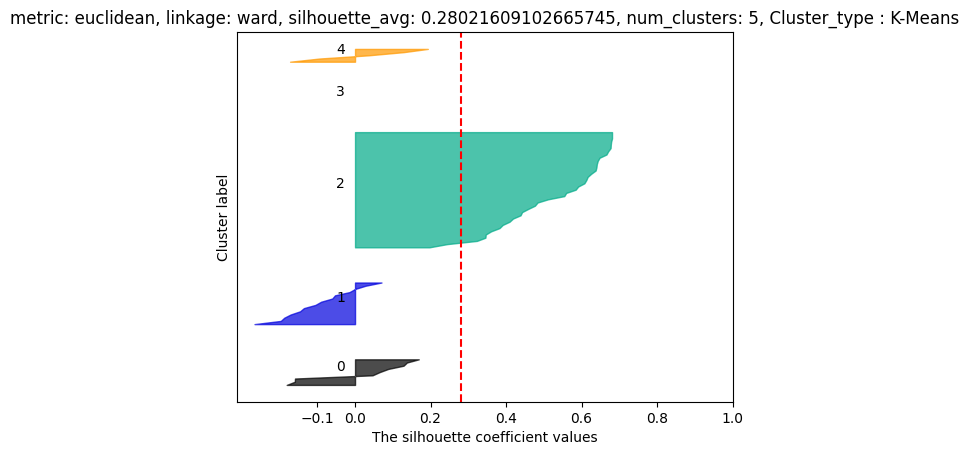

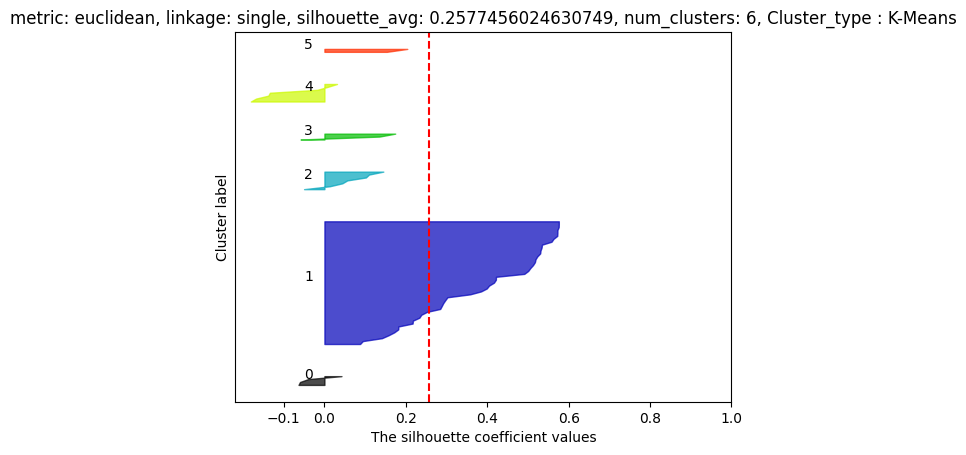

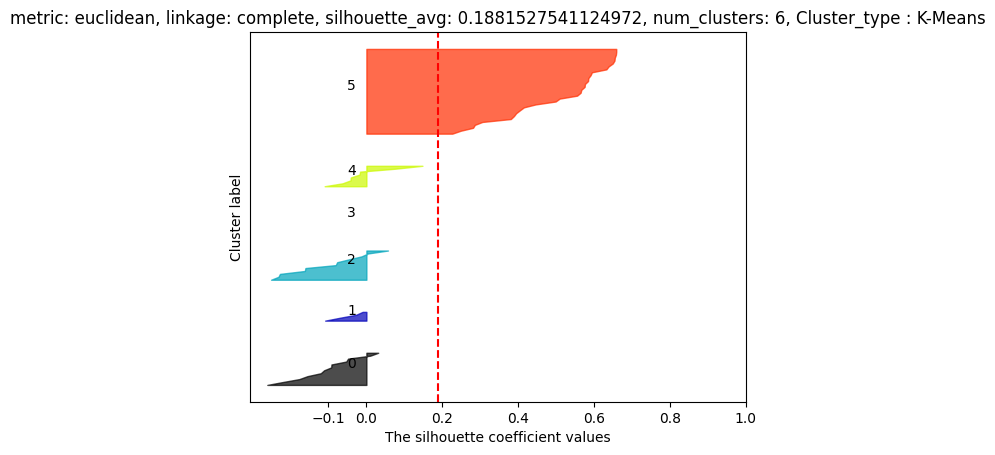

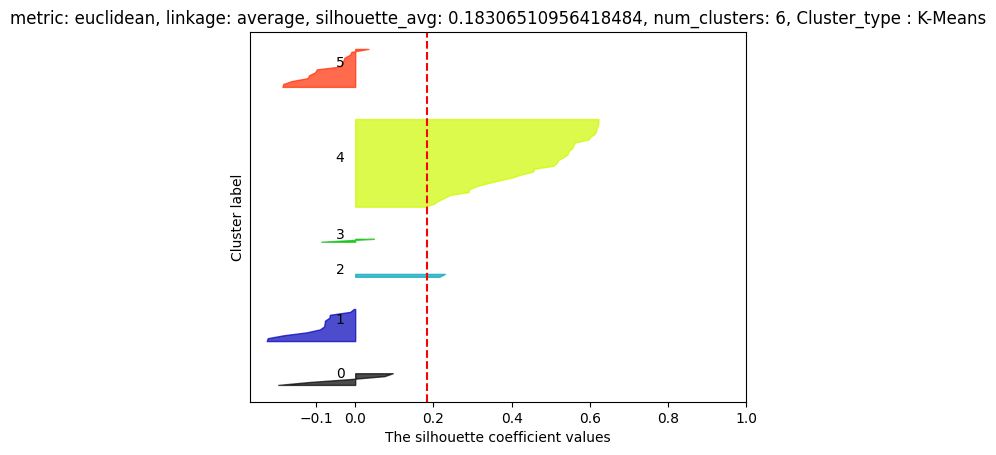

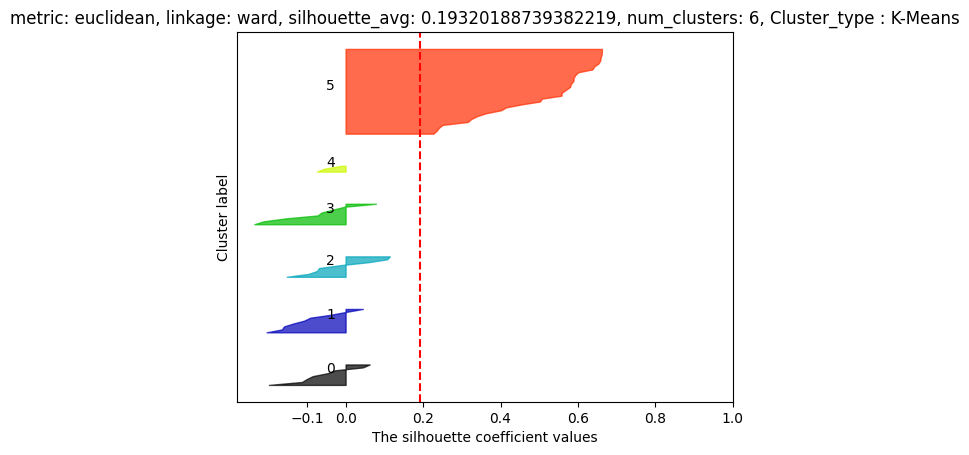

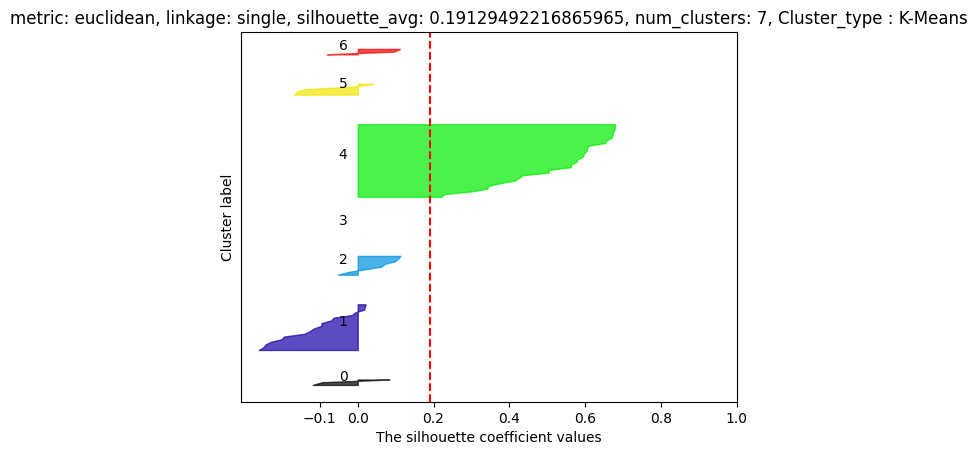

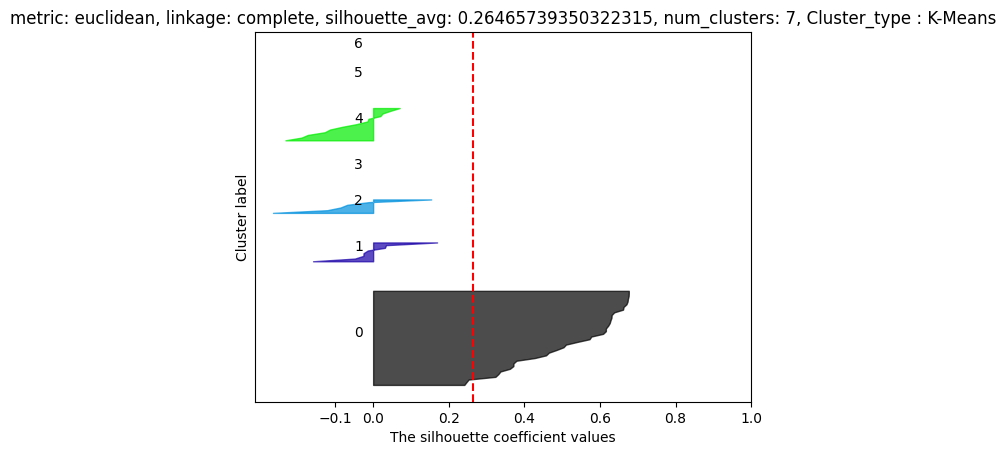

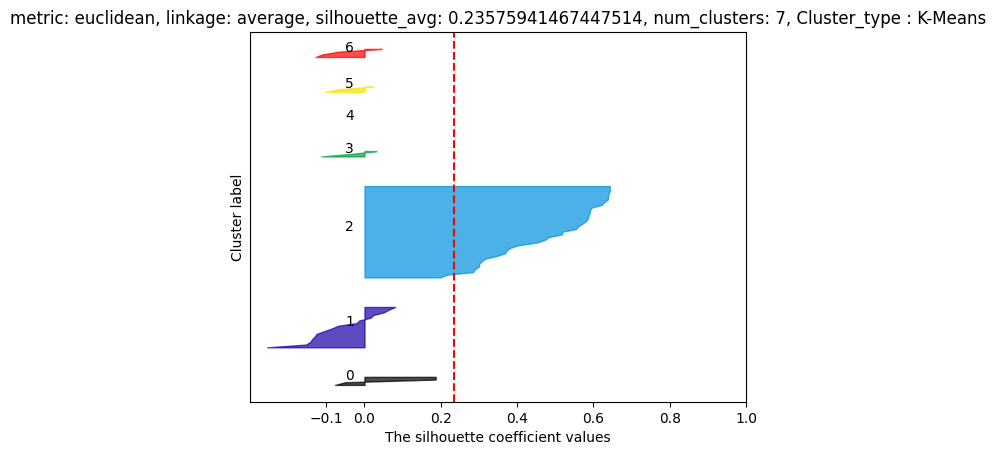

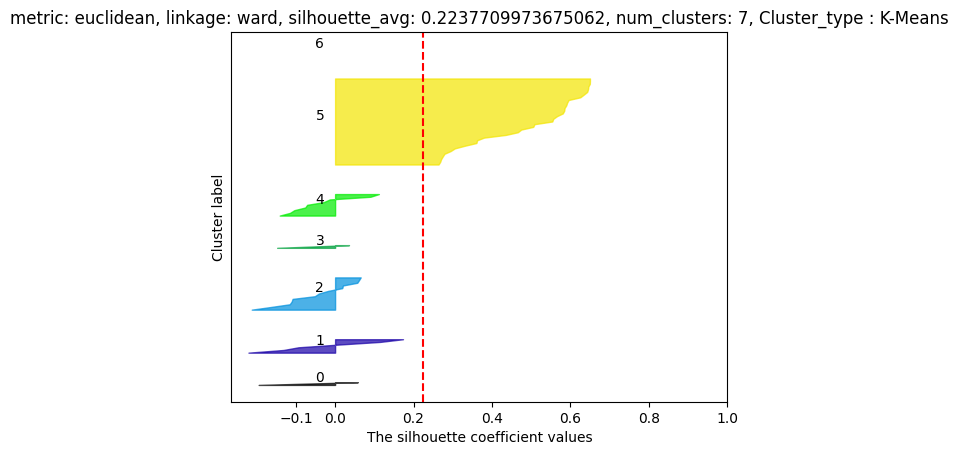

In [249]:
"""
Identify kmeans clustering parameter combination with best silhouette score for DWT features

"""

metrics = ['euclidean']
methods = ['single','complete','average','ward']
clustering_type = 'K-Means'

kmeans_result_comb_dwt = []

for num_cluster in range(4,8,1):
    for metric in metrics:
        for method in methods:
            km = TimeSeriesKMeans(n_clusters=num_cluster, metric=metric)
            km.fit(X_train_dwt_normalized)
            #plot_stations_of_clusters(km.labels_, Dim_Red_unmet_60min_outflow_week_df,'unmet_demand')
            silhouette_avg, num_neg_silhouette_scores, min_silhouette_score,dev_from_mean_num_zone = plot_silhouette_scores(X_train_dwt_normalized,km.labels_,metric,method,clustering_type)
            kmeans_result_comb_dwt.append([silhouette_avg,num_neg_silhouette_scores, min_silhouette_score,metric,method,num_cluster,dev_from_mean_num_zone ])


In [250]:
"""
Shortlist kmeans clustering for DWT features

"""

kmeans_result_comb_df_dwt = pd.DataFrame(kmeans_result_comb_dwt,columns=["silhouette_avg","num_neg_silhouette_scores", "min_silhouette_score","metric","method","num_clusters","dev_from_mean_num_zone"])

sorted_best_kmeans_result_comb_dwt = kmeans_result_comb_df_dwt.sort_values(by=['num_neg_silhouette_scores','dev_from_mean_num_zone','min_silhouette_score'],ascending=[True,True,False])

sorted_best_kmeans_result_comb_dwt

silhouette_avg  num_neg_silhouette_scores  min_silhouette_score  \
3         0.337243                          7             -0.198792   
8         0.257746                         10             -0.180797   
4         0.276989                         14             -0.231761   
7         0.280216                         16             -0.266263   
6         0.260433                         17             -0.241849   
1         0.274815                         17             -0.252310   
0         0.284973                         17             -0.270313   
13        0.264657                         19             -0.264947   
15        0.223771                         20             -0.220910   
14        0.235759                         20             -0.254779   
5         0.208933                         21             -0.238853   
2         0.273455                         22             -0.268649   
12        0.191295                         24             -0.261245   
11        0.193202                         28             -0.235831   
9         0.188153                         29             -0.261078   
10        0.183065                         29             -0.226365   

       metric    method  num_clusters  dev_from_mean_num_zone  
3   euclidean      ward             4               61.000000  
8   euclidean    single             6               64.000000  
4   euclidean    single             5               51.600000  
7   euclidean      ward             5               49.200000  
6   euclidean   average             5               49.200000  
1   euclidean  complete             4               50.000000  
0   euclidean    single             4               56.000000  
13  euclidean  complete             7               60.285714  
15  euclidean      ward             7               54.285714  
14  euclidean   average             7               64.285714  
5   euclidean  complete             5               43.200000  
2   euclidean   average             4               47.000000  
12  euclidean    single             7               54.285714  
11  euclidean      ward             6               38.000000  
9   euclidean  complete             6               40.000000  
10  euclidean   average             6               48.000000

<ipython-input-201-1ec0c444a7af>:96: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

<ipython-input-201-1ec0c444a7af>:96: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.



ValueError: ignored

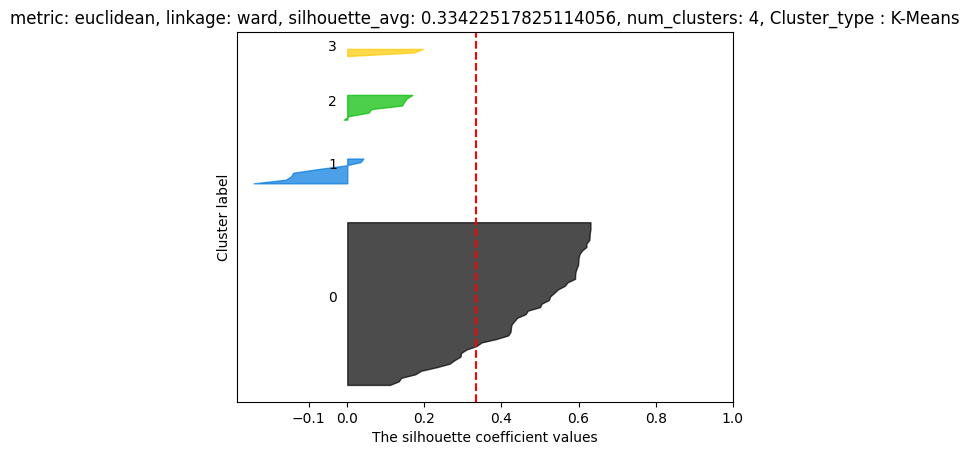

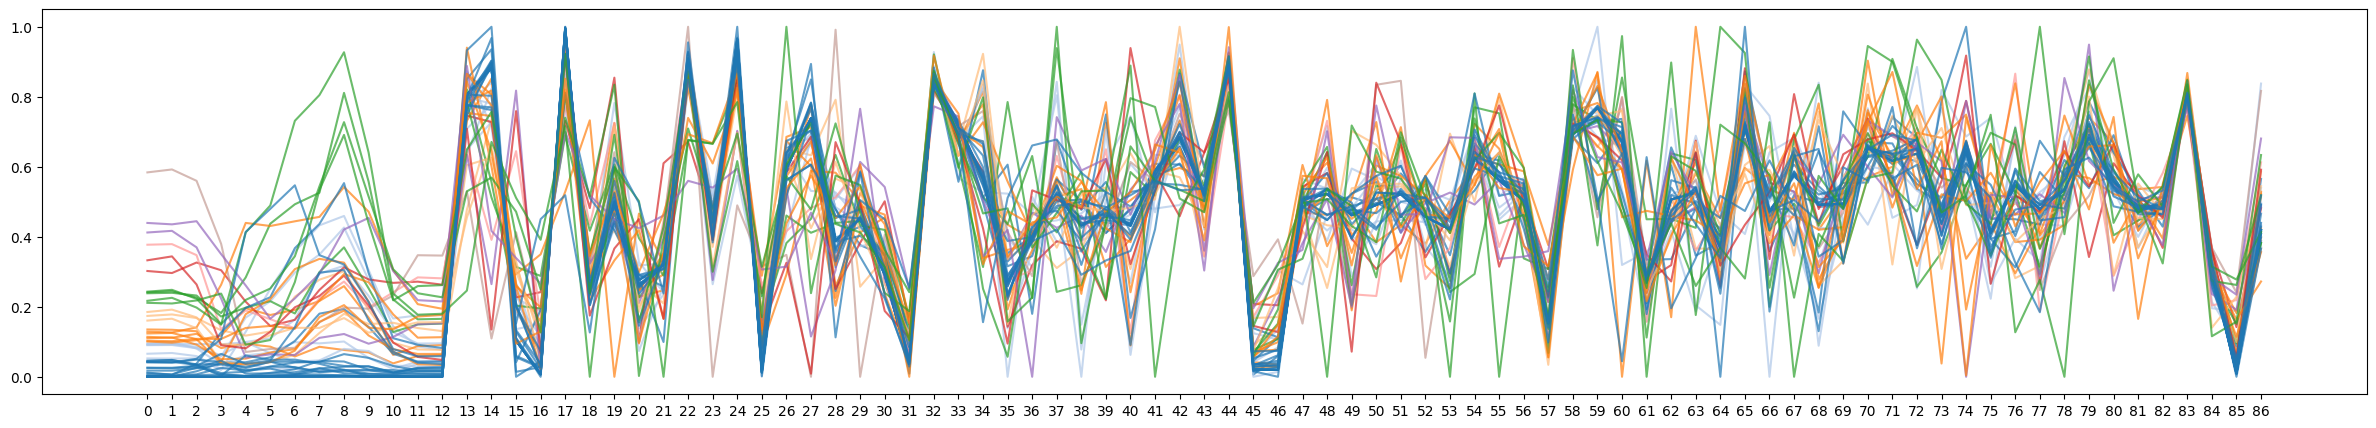

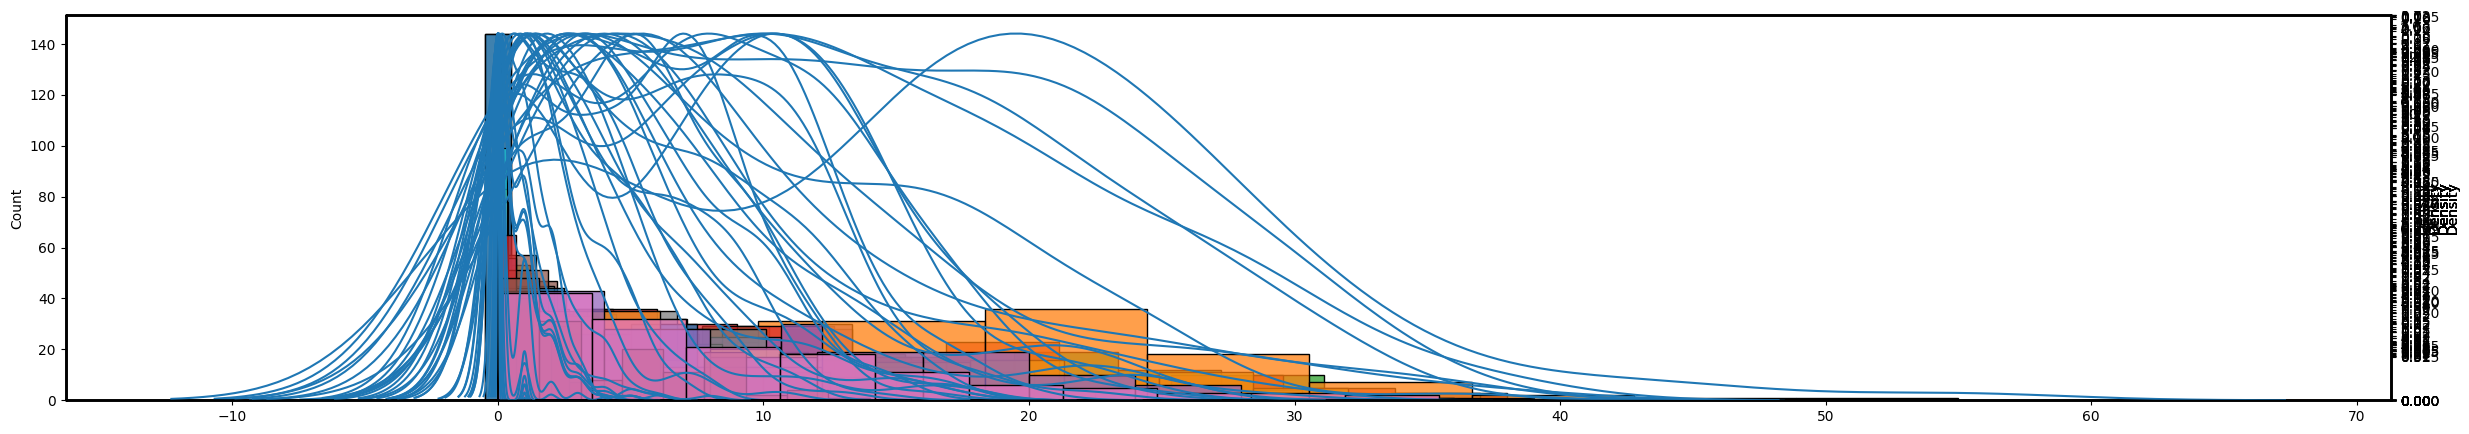

In [254]:
"""
SHORTLISTED K-means clustering parameters combination for DWT features

"""

plt.close('all')

plot_title = 'TS statistical features'
mother = 'rbio2.2'
limit_level = 2
trend_angular_labels = ["Average Demand",'no_mean_crossing', "n95 demand", "Zero demands", "skewness"]

metrics = [sorted_best_kmeans_result_comb_dwt.iloc[0]['metric']]
methods = [sorted_best_kmeans_result_comb_dwt.iloc[0]['method']]
clustering_type = 'K-Means'
num_clusters_list = [sorted_best_kmeans_result_comb_dwt.iloc[0]['num_clusters']]

for num_cluster in num_clusters_list:
    for metric in metrics:
        for method in methods:
            kmeans_model = TimeSeriesKMeans(n_clusters=num_cluster, metric=metric)
            kmeans_model.fit(X_train_dwt_normalized)
            silhouette_avg, num_neg_silhouette_scores, min_silhouette_score,dev_from_mean_num_zone = plot_silhouette_scores(X_train_dwt_normalized,kmeans_model.labels_,metric,method,clustering_type)
            clustering_result_dict,all_cluster_feat_mins,all_cluster_feat_maxs = plot_stations_of_clusters(kmeans_model.labels_, zone_met_10m_outflow_df,'met_demand',X_train_dwt_normalized,X_train_dwt_inv_normalized,'par_coords',trend_angular_labels,plot_title,mother,limit_level)




In [ ]:
"""
Visualize cluster representatives from DWT features using parcoords plot

"""

#Add dummy outliers
# all_cluster_feat_mins = np.append( np.random.randint(0,1,(5,)) , all_cluster_feat_mins)
# all_cluster_feat_maxs = np.append( np.random.randint(0,1,(5,)) , all_cluster_feat_maxs)

plot_cluster_representatives(X_train_dwt_normalized, all_cluster_feat_mins, all_cluster_feat_maxs,'par_coords',trend_angular_labels)

In [ ]:
"""
Rank DWT cluster from "highest demand" to "lowest demand" vaguely without the outlier.
"""
num_clusters = len(np.unique(kmeans_model.labels_))
num_features = X_train_dwt_normalized.shape[1]

ranked_clusters = rank_clusterings(all_cluster_feat_mins,all_cluster_feat_maxs,num_clusters,num_features) # exclude outliers
ranked_clusters

In [ ]:
"""
Display different ranked DWT clusters on the same map
"""

colormap = plt.cm.RdYlGn  # Diverging red to green colormap
norm = mcolors.Normalize(vmin=min(ranked_clusters.keys()), vmax=max(ranked_clusters.keys()))

map_center = [40.7831, -73.9712]  # Manhattan coordinates (latitude, longitude)
map_zoom = 12  # Adjust the zoom level as needed
my_map = folium.Map(location=map_center, zoom_start=map_zoom,width='70%', height='70%')

marker_color = [ 'black','darkred','red','lightred','lightgreen','green','darkgreen',    'lightblue',    'blue',    'darkblue',]

for cluster in clustering_result_dict.keys(): # ourliers included
  stations = clustering_result_dict[cluster]
  color = mcolors.to_hex(colormap(norm(cluster)))
  for station in stations:
    folium.Marker(location=zone_to_gps_dict[int(station)], popup=str(station)+': '+color+'-'+str(cluster), icon=folium.Icon(color=marker_color[cluster+1]),tooltip=str(cluster)).add_to(my_map)
display(my_map)

In [ ]:
"""
Identify k-medoids clustering parameter combination with best silhouette score for DWT features

"""

### xxxx POOR performance xxxx ###

mahalanobis_dist = compute_mahalanobis_dist_mat(X_train_dwt_normalized)

for k in range(2,35,2):
    for method in methods:
        kmedoids = KMedoids(n_clusters=k, metric='precomputed', init='random', method="alternate").fit(mahalanobis_dist)
        plot_silhouette_scores(X_train_dwt_normalized,kmedoids.labels_,metric,method)



In [ ]:
"""
SHORTLISTED aggolmeratic clustering parameters combination for DWT features

"""

plt.close('all')
limit_level = 2

mother = 'rbio2.2'
num_feats = features_info(unmet_60min_outflow_df,mother,limit_level)  # display number of feats
X_train = get_stations_dwt_features(signal=unmet_60min_outflow_df, waveletname=mother,num_feats=num_feats,limit_level=limit_level) #choose wavelets and levels < 9, #output = 382 x 180 features

ts_dwt_feat_transform = feat_transformation()
X_train_dwt_normalized = ts_dwt_feat_transform.feature_normalization(X_train)

num_clusters_list = [21]

methods = ['complete']#['single','complete','average','weighted',]
metrics = ['cityblock']
for metric,method,num_clusters in zip(metrics,methods,num_clusters_list):
    print('\n',metric,method,num_clusters)
    plot_title = 'DWT features, '+ 'limit level: ' + str(limit_level) +', metric: '+metric+', method: '+', num_clusters: '+str(num_clusters)+'. '
    model = AgglomerativeClustering(n_clusters=num_clusters, metric=metric, linkage=method)
    model.fit(X_train_dwt_normalized)
    labels = model.labels_
    #plot_silhouette_scores(X_train_dwt_normalized,labels,metric,method)
    #all_cluster_feat_mins, all_cluster_feat_maxs = plot_stations_of_clusters(model.labels_, Dim_Red_unmet_60min_outflow_week_df,'unmet_demand',X_train_dwt_normalized,'polar')
    #plot_cluster_representatives(X_train, all_cluster_feat_mins, all_cluster_feat_maxs,'polar')
    all_cluster_feat_mins, all_cluster_feat_maxs = plot_stations_of_clusters(model.labels_, Dim_Red_unmet_60min_outflow_week_df,'unmet_demand',X_train_dwt_normalized,'par_coords',range(X_train_dwt_normalized.shape[1]),plot_title,mother,limit_level)
    #plot_cluster_representatives(X_train_dwt_normalized, all_cluster_feat_mins, all_cluster_feat_maxs,'par_coords',range(X_train_dwt_normalized.shape[1]))
    #plot_cluster_representatives(X_train_dwt_normalized, all_cluster_feat_mins, all_cluster_feat_maxs,'polar',range(X_train_dwt_normalized.shape[1]))



"""
mother = 'rbio2.2'
num_feats = features_info(unmet_60min_outflow_df,mother,limit_level)  # display number of feats
X_train = get_stations_dwt_features(signal=unmet_60min_outflow_df, waveletname=mother,num_feats=num_feats,limit_level=limit_level) #choose wavelets and levels < 9, #output = 382 x 180 features

ts_dwt_feat_transform = feat_transformation()
X_train_dwt_normalized = ts_dwt_feat_transform.feature_normalization(X_train)


num_clusters_list = [23,10,8]
methods = ['complete','complete','complete']#['single','complete','average','weighted',]
metrics = ['cityblock',,'cityblock','cityblock']
for metric,method,num_clusters in zip(metrics,methods,num_clusters_list):
    print('\n',metric,method,num_clusters)
    plot_title = 'DWT features, '+ 'limit level: ' + str(limit_level) +', metric: '+metric+', method: '+', num_clusters: '+str(num_clusters)+'. '
    model = AgglomerativeClustering(n_clusters=num_clusters, metric=metric, linkage=method)
    model.fit(X_train_dwt_normalized)
    labels = model.labels_
    #plot_silhouette_scores(X_train_dwt_normalized,labels,metric,method)
    #all_cluster_feat_mins, all_cluster_feat_maxs = plot_stations_of_clusters(model.labels_, Dim_Red_unmet_60min_outflow_week_df,'unmet_demand',X_train_dwt_normalized,'polar')
    #plot_cluster_representatives(X_train, all_cluster_feat_mins, all_cluster_feat_maxs,'polar')
    all_cluster_feat_mins, all_cluster_feat_maxs = plot_stations_of_clusters(model.labels_, Dim_Red_unmet_60min_outflow_week_df,'unmet_demand',X_train_dwt_normalized,'par_coords',range(X_train_dwt_normalized.shape[1]),plot_title)
    #plot_cluster_representatives(X_train_dwt_normalized, all_cluster_feat_mins, all_cluster_feat_maxs,'par_coords',range(X_train_dwt_normalized.shape[1]))
    #plot_cluster_representatives(X_train_dwt_normalized, all_cluster_feat_mins, all_cluster_feat_maxs,'polar',range(X_train_dwt_normalized.shape[1]))



num_clusters_list = [13,24]
methods = ['complete','average']#['single','complete','average','weighted',]
metrics = ['euclidean','cityblock']
for metric,method,num_clusters in zip(metrics,methods,num_clusters_list):
    print('\n',metric,method,num_clusters)
    plot_title = 'DWT features, '+ 'limit level: ' + str(limit_level) +', metric: '+metric+', method: '+', num_clusters: '+str(num_clusters)+'. '
    model = AgglomerativeClustering(n_clusters=num_clusters, metric=metric, linkage=method)
    model.fit(X_train_dwt_normalized)
    labels = model.labels_
    #plot_silhouette_scores(X_train_dwt_normalized,labels,metric,method)
    #all_cluster_feat_mins, all_cluster_feat_maxs = plot_stations_of_clusters(model.labels_, Dim_Red_unmet_60min_outflow_week_df,'unmet_demand',X_train_dwt_normalized,'polar')
    #plot_cluster_representatives(X_train, all_cluster_feat_mins, all_cluster_feat_maxs,'polar')
    all_cluster_feat_mins, all_cluster_feat_maxs = plot_stations_of_clusters(model.labels_, Dim_Red_unmet_60min_outflow_week_df,'unmet_demand',X_train_dwt_normalized,'par_coords',range(X_train_dwt_normalized.shape[1]),plot_title)
    #plot_cluster_representatives(X_train_dwt_normalized, all_cluster_feat_mins, all_cluster_feat_maxs,'par_coords',range(X_train_dwt_normalized.shape[1]))
    #plot_cluster_representatives(X_train_dwt_normalized, all_cluster_feat_mins, all_cluster_feat_maxs,'polar',range(X_train_dwt_normalized.shape[1]))
"""

In [ ]:
"""                                                                    ### DETAILED 3d UMAP for Discrete wavelet features

use above to get correct n_neighbors ,min_dist and metric to visuzalize in detain
"""
plt.close('all')

fig_umap_3d = sp.make_subplots(specs=[[{'type': 'surface'} for i in range(1)]])

fig_umap_3d.add_trace(plotter_dwt.plot_UMAP_3d(X_train_dwt_normalized,30,0.1,'manhattan'))

fig_umap_3d.update_layout(height=900 , width=900,title='UMAP 3d,'+print_msg)
fig_umap_3d.show()

In [ ]:
plot_cluster_representatives(X_train, all_cluster_feat_mins, all_cluster_feat_maxs,'polar')

In [ ]:






# mahalanobis_dist_mat = compute_mahalanobis_dist_mat(X_train_dwt_normalized)
# agg = AgglomerativeClustering(n_clusters=25, metric='precomputed', linkage = 'complete')
# agg.fit_predict(mahalanobis_dist_mat)  # Returns class labels.





In [ ]:
"""                                                               Distance Matrix calculation
Distance Measure: Dynamic Time Warping

"""

"""
stations = unmet_60min_outflow_df.columns
unique_station_pairs = list(combinations(stations, 2))

## station to index map
station_to_index_map = {}
i=0
for s in stations:
    station_to_index_map[s] = i
    i+=1

## index to station map
index_to_station_map = {}
i=0
for s in stations:
    index_to_station_map[i] = s
    i+=1

## create indices of 2d distance matrix
arr_dim = len(stations)
index = []
rows = 1
for c in np.arange(arr_dim-1):
  for r in np.arange(rows,arr_dim):
    index.append((r,c))
  rows = rows+1

dtw_distance_matrix = pd.DataFrame(columns=unique_station_pairs,index=range(1))
dtw_arr = np.array([])
dtw_arr_2d = z = np.zeros(shape=(len(stations),len(stations)))
i=0
for pair in unique_station_pairs:
    dtw_dist = dtw(unmet_60min_outflow_df[pair[0]].values, unmet_60min_outflow_df[pair[1]].values)
    dtw_arr = np.append(dtw_arr,dtw_dist)
    dtw_arr_2d[index[i]] = dtw_dist
    i+=1
dtw_distance_matrix.loc[0] = dtw_arr
dtw_arr_2d = dtw_arr_2d + dtw_arr_2d.T # to make it symmetric
dtw_arr_2d = dtw_arr_2d + 1 # to make corr non-negative


pd.DataFrame(dtw_arr_2d).to_csv('dtw_distance_matrix_2d.csv',index=False)

dtw_distance_matrix.to_csv('dtw_distance_matrix.csv',index=False)

dtw_arr_2d = pd.read_csv('dtw_distance_matrix_2d.csv')
dtw_arr_2d = dtw_arr_2d.to_numpy()

dtw_distance_vector = pd.read_csv('dtw_distance_matrix.csv')
"""



In [ ]:

"""                                                                Naive Analysis of DTW distance

Can we just rank the distance matrix and group the largest positive/negative and smallest dtw ???
"""
dtw_distance_vector = pd.read_csv('dtw_distance_matrix.csv')
# plt.figure(figsize=(50,10))
# plt.hist(dtw_distance_vector.loc[0].values,bins=100000)
# plt.title('histogram')
# plt.xlabel('dynamic_time_warping_dist_matrix')
# plt.savefig('dtw_hist_number_of_cluster.PNG')
# plt.show()

dtw_df = pd.DataFrame({'dtw':dtw_distance_vector.loc[0].values})
fig = px.histogram(dtw_df, x="dtw",nbins=100000)
fig.show()

"""
image = mpimg.imread('dtw_hist_number_of_cluster.PNG')
plt.imshow(image)
plt.show()
"""

In [ ]:
"""                                 Distance Matrix calculation
Distance Measure: Longest common subsequence, LCSS

"""

"""
stations = unmet_60min_outflow_df.columns
unique_station_pairs = list(combinations(stations, 2))

## station to index map
station_to_index_map = {}
i=0
for s in stations:
    station_to_index_map[s] = i
    i+=1

## index to station map
index_to_station_map = {}
i=0
for s in stations:
    index_to_station_map[i] = s
    i+=1

## create indices of 2d distance matrix
arr_dim = len(stations)
index = []
rows = 1
for c in np.arange(arr_dim-1):
  for r in np.arange(rows,arr_dim):
    index.append((r,c))
  rows = rows+1

lcss_distance_matrix = pd.DataFrame(columns=unique_station_pairs,index=range(1))
lcss_arr = np.array([])
lcss_arr_2d = z = np.zeros(shape=(len(stations),len(stations)))
i=0
for pair in unique_station_pairs:
    x = unmet_60min_outflow_df[pair[0]].values
    y = unmet_60min_outflow_df[pair[1]].values
    xNormed = (x - x.mean())/(x.std()) # standardize the TS
    yNormed = (y - y.mean())/(y.std()) # standardize the TS
    lcss_dist = lcss(s1 = xNormed, s2 = yNormed ,eps=0.3, global_constraint= "sakoe_chiba",sakoe_chiba_radius=0.3)
    lcss_arr = np.append(lcss_arr,lcss_dist)
    lcss_arr_2d[index[i]] = lcss_dist
    i+=1
lcss_distance_matrix.loc[0] = lcss_arr
lcss_arr_2d = lcss_arr_2d + lcss_arr_2d.T # to make it symmetric
lcss_arr_2d = 1 - lcss_arr_2d # to make similarity to distance matrix


pd.DataFrame(lcss_arr_2d).to_csv('lcss_distance_matrix_2d.csv',index=False)
lcss_distance_matrix.to_csv('lcss_distance_matrix.csv',index=False)
"""


lcss_arr_2d = pd.read_csv('lcss_distance_matrix_2d.csv')
lcss_arr_2d = lcss_arr_2d.to_numpy()


#lcss_distance_vector = pd.read_csv('lcss_distance_matrix.csv')



In [ ]:

"""                                                                Naive Analysis of lcss distance

Can we just rank the distance matrix and group the largest positive/negative and smallest lcss ???
"""
lcss_distance_vector = pd.read_csv('lcss_distance_matrix.csv')
# plt.figure(figsize=(50,10))
# plt.hist(dtw_distance_vector.loc[0].values,bins=100000)
# plt.title('histogram')
# plt.xlabel('dynamic_time_warping_dist_matrix')
# plt.savefig('dtw_hist_number_of_cluster.PNG')
# plt.show()

lcss_df = pd.DataFrame({'lcss':lcss_distance_vector.loc[0].values})
fig = px.histogram(lcss_df, x="lcss",nbins=100000)
fig.show()

"""
image = mpimg.imread('dtw_hist_number_of_cluster.PNG')
plt.imshow(image)
plt.show()
"""

In [ ]:
"""                                                                     FEATURE Extraction

Feature extracted: Fast Fourier Transform

1) Identify the top 10 frequency components in each time series
2) Identify all the unique frequency components from all time series
3) Identify these frequency components in each time series
4) Use the magnitudes of these FIXED frequency components as features for each series.

"""

stations = unmet_60min_outflow_df.columns
#unique_station_pairs = list(combinations(stations, 2))

top_x_frequencies = 5
num_common_freq=180
common_freq_set = set()
X_train = np.empty(shape=(0,num_common_freq))

for station in stations:
    # Perform the FFT on the data
    fft_result = np.fft.fft(unmet_60min_outflow_df[station].values)
    # Compute the magnitudes of the FFT result
    fft_magnitudes = np.abs(fft_result)
    # Generate the corresponding frequency axis
    sampling_rate = 1.0  # Assuming a sampling rate of 1.0 (change as needed)
    frequency_axis = np.fft.fftfreq(len(fft_result), 1 / sampling_rate)
    positive_freq_indices = np.where(frequency_axis >= 0)

    """ TOP periods/frequencies in the time series"""
    # Sort the magnitudes and frequencies in descending order
    sorted_indices = np.argsort(fft_magnitudes[positive_freq_indices])[::-1]
    sorted_magnitudes = fft_magnitudes[positive_freq_indices][sorted_indices]
    sorted_frequencies = frequency_axis[positive_freq_indices][sorted_indices]
    # Select the top periods
    top_mag = sorted_magnitudes[1:top_x_frequencies+1]
    top_freq = sorted_frequencies[1:top_x_frequencies+1] # REMOVE dc/mean component
    common_freq_set.update(top_freq)
    #print("Top mag: ",top_mag )

common_freq_arr = np.sort(np.array(list(common_freq_set)))#[:num_common_freq]
#common_freq_arr = np.sort(np.array(list(common_freq_set)))[:num_common_freq]


for station in stations:
    # Perform the FFT on the data
    fft_result = np.fft.fft(unmet_60min_outflow_df[station].values)
    # Compute the magnitudes of the FFT result
    fft_magnitudes = np.abs(fft_result)
    # Generate the corresponding frequency axis
    sampling_rate = 1.0  # Assuming a sampling rate of 1.0 (change as needed)
    frequency_axis = np.fft.fftfreq(len(fft_result), 1 / sampling_rate)
    positive_freq_indices = np.where(frequency_axis >= 0)

    unique_freqs_indices = np.where(np.isin(frequency_axis[positive_freq_indices], common_freq_arr))[0]
    #print(len(unique_freqs_indices))
    fft_mag_arr = fft_magnitudes[positive_freq_indices][unique_freqs_indices]
    normalized_magnitudes = fft_mag_arr / np.max(fft_mag_arr) # normalize it so that they are comparable

    X_train = np.vstack((X_train,normalized_magnitudes[:num_common_freq]))
    #X_train = np.vstack((X_train,normalized_magnitudes))

#print(X_train.shape)

X_train = feature_standardization(X_train)

fig, ax_tsne_2d = plt.subplots(ncols=2,figsize=(25,7))
fig_umap_2d = sp.make_subplots(rows=1, cols=1)
fig_umap_3d = sp.make_subplots(specs=[[{'type': 'surface'} for i in range(1)]])
fig_isomap_2d = sp.make_subplots(rows=1, cols=1)
fig_isomap_3d = sp.make_subplots(specs=[[{'type': 'surface'} for i in range(1)]])

print_msg = 'FFT'
plotter = plot_all(print_msg)
plotter.plot_tSNE_2d(X_train,print_msg,ax_tsne_2d,0)
fig.show()

fig_umap_2d.add_trace(plotter.plot_UMAP_2d(X_train,print_msg),row=1,col=1)
fig_umap_3d.add_trace(plotter.plot_UMAP_3d(X_train,))

fig_isomap_2d.add_trace(plotter.plot_ISOMAP_2d(X_train,print_msg),row=1,col=1)
fig_isomap_3d.add_trace(plotter.plot_ISOMAP_3d(X_train,print_msg))

fig_umap_2d.update_layout(height=600 , width=600,title='UMAP 2d, '+print_msg)
fig_umap_2d.show()

fig_umap_3d.update_layout(height=600 , width=600,title='UMAP 3d, '+print_msg)
fig_umap_3d.show()

fig_isomap_2d.update_layout(height=600 , width=600,title='ISOMAP 2d, '+print_msg)
fig_isomap_2d.show()

fig_isomap_3d.update_layout(height=600 , width=600,title='ISOMAP 3d, '+print_msg)
fig_isomap_3d.show()



In [ ]:
"""                                                                   CLUSTERING Analysis

K-Medoids using DTW distance matrix
"""

dtw_arr_2d = pd.read_csv('dtw_distance_matrix_2d.csv')
dtw_arr_2d = dtw_arr_2d.to_numpy()
#dtw_arr_2d = dtw_arr_2d - 1

## pearson correlation
silhouette_index = []
min_clusters = 2
max_clusters = 40
dist_metric = 'dtw'

X_train = Dim_Red_unmet_60min_outflow_week_df.to_numpy().T

for k in range(min_clusters, max_clusters):
    kmedoids = KMedoids(n_clusters=k, metric='precomputed', init='random', method="alternate").fit(dtw_arr_2d)
    #kmedoids = KMedoids(n_clusters=k, metric=dist_metric, init='random', method="alternate").fit(X_train)
    #X_train = Dim_Red_unmet_60min_outflow_week_df
    score = silhouette_score(X_train, kmedoids.labels_, metric=dist_metric)
    silhouette_index.append(score)


plt.figure(figsize=(15,5))
plt.xticks(range(min_clusters,max_clusters))
plt.plot(range(min_clusters,max_clusters),silhouette_index) # mean score for all samples. It is between [-1,1] where -1 needs reassignment, 1 is best. # Scores around zero indicate overlapping clusters.
plt.title('Number of clusters selection for K-Medoids with dynamic time warping')
plt.xlabel('number of clusters')
plt.ylabel('silhouette_score')
plt.savefig('silhouette_score_K-Medoids_dtw.PNG')
plt.show()

In [ ]:
lcss_arr_2d

In [ ]:
"""                                                                   CLUSTERING Analysis

K-Medoids using LCSS distance matrix
"""

lcss_arr_2d = pd.read_csv('lcss_distance_matrix_2d.csv')
lcss_arr_2d = lcss_arr_2d.to_numpy()
np.fill_diagonal(lcss_arr_2d, 0)

silhouette_index = []
min_clusters = 2
max_clusters = 40
dist_metric = 'lcss'

X_train = Dim_Red_unmet_60min_outflow_week_df.to_numpy().T

for k in range(min_clusters, max_clusters):
    kmedoids = KMedoids(n_clusters=k, metric='precomputed', method="pam",max_iter=1000).fit(lcss_arr_2d)
    #kmedoids = KMedoids(n_clusters=k, metric=dist_metric, init='random', method="alternate").fit(X_train)
    #X_train = Dim_Red_unmet_60min_outflow_week_df
    score = silhouette_score(lcss_arr_2d, kmedoids.labels_, metric="precomputed")
    silhouette_index.append(score)


plt.figure(figsize=(15,5))
plt.xticks(range(min_clusters,max_clusters))
plt.plot(range(min_clusters,max_clusters),silhouette_index) # mean score for all samples. It is between [-1,1] where -1 needs reassignment, 1 is best. # Scores around zero indicate overlapping clusters.
plt.title('Number of clusters selection for K-Medoids with longest common subsequence')
plt.xlabel('number of clusters')
plt.ylabel('silhouette_score')
plt.savefig('silhouette_score_K-Medoids_LCSS.PNG')
plt.show()

In [ ]:
"""
Where is demand from a region going to become supply in other regions?

Cross-Correlation between each region's met demand and all regions' inflow.
Cross-Correlation handles current and future inflows
### NO NEED Cross-correlation. only check present, 1 hour and 2 hour leading pearson correlaiton coefficient

Sometimes demand can become supply within the region, not necessarily leave the region.

check linearity of scatter plot before applying pearson correlation.

"""
import scipy.stats as stats

os.chdir('C:\Work\WORK_PACKAGE\Demand_forecasting\github\DeepAR-pytorch\My_model\Rental_Fleet_Demand_Forecast\data\\region_level\inflow_data')
region_inflow_df = pd.read_csv('region_inflow.csv')
region_inflow_df = region_inflow_df.rename(columns={"Unnamed: 0": 'datetime'})

for col_outf in region_met_outflow_df.columns[1:]:
    print('\n')
    print('Region: ',col_outf)
    rank_dict = {}
    for col_inf in region_inflow_df.columns[1:]:
        #if col_outf != col_inf: # check correlation between other regions
        ## positive correlation means that the cars entered
        ## negative correlation means cars did not enter
        ## cross correlation with largest sum of all positive cross correlations indicates region into which cars entered
        ## cross correlation with smallest sum of all negative cross correlations indicates region into which cars did NOT entered, this helps to eliminate non-entered regions
        time_series1 = region_met_outflow_df[col_outf]
        time_series2 = region_inflow_df[col_inf]

        time_series2_lead1 = time_series2.shift(periods=-1).dropna()
        time_series2_lead2 = time_series2.shift(periods=-2).dropna()

        rank_dict[col_inf] = []

        # original inflow time series
        r, p = stats.pearsonr(time_series1, time_series2)
        rank_dict[col_inf] = r
        # plt.scatter(x=time_series1,y=time_series2)
        # plt.xlabel('demand: '+str(col_outf))
        # plt.ylabel('supply: '+str(col_inf))
        # plt.title('rho: '+str(r))
        # plt.show()

        # lead 1 hour inflow time series
        r1, p1 = stats.pearsonr(time_series1[:-1], time_series2_lead1)
        rank_dict[col_inf+'_lead1'] = r1
        # plt.scatter(x=time_series1[:-1],y=time_series2_lead1)
        # plt.xlabel('demand: '+str(col_outf))
        # plt.ylabel('supply lead 1 hour: '+str(col_inf))
        # plt.title('rho: '+str(r1))
        # plt.show()

        # lead 2 hours inflow time series
        r2, p2 = stats.pearsonr(time_series1[:-2], time_series2_lead2)
        rank_dict[col_inf+'_lead2'] = r2
        # plt.scatter(x=time_series1[:-2],y=time_series2_lead2)
        # plt.xlabel('demand: '+str(col_outf))
        # plt.ylabel('supply lead 2 hours: '+str(col_inf))
        # plt.title('rho: '+str(r2))
        # plt.show()

    # Sort the dictionary based on values in descending order
    sorted_dict = sorted(rank_dict.items(), key=lambda x: x[1], reverse=True)
    # Get the three largest key-value pairs
    top_sorted = sorted_dict[:3]
    # Print the result
    print(col_outf,'outflow has LARGEST correlations with following inflows:')
    for key, value in top_sorted:
        print(key, value)
    bottom_sorted = sorted_dict[-3:]
    # Print the result
    print(col_outf,'outflow has SMALLEST correlations with following inflows:')
    for key, value in bottom_sorted:
        print(key, value)





In [ ]:
"""
UNMET demand
1)
2) check FFT of top 3 periods, check lags of top 3 PACF plots
3) boxplot to see distribution of demand during each region's hour of the weekday.
4) optional Treemap to verify boxplot above.

This info. can be used for performance monitoring. sum of cluster
outputs from the same region is within this box plot.

"""
os.chdir('C:\Work\WORK_PACKAGE\Demand_forecasting\github\DeepAR-pytorch\My_model\Rental_Fleet_Demand_Forecast\data\\region_level\outflow_data')
region_unmet_outflow_df = pd.read_csv('region_unmet_outflow.csv')
region_unmet_outflow_df = region_unmet_outflow_df.rename(columns={"Unnamed: 0": 'datetime'})

## FFT and IFFT to identify the significant periods in UNMET demand
print('\t\t\tFFT analysis of regions\n')
for reg in region_unmet_outflow_df.columns[1:]:
    print(reg)

    # Perform the FFT on the data
    fft_result = np.fft.fft(region_unmet_outflow_df[reg].values)
    # Compute the magnitudes of the FFT result
    fft_magnitudes = np.abs(fft_result)
    # Generate the corresponding frequency axis
    sampling_rate = 1.0  # Assuming a sampling rate of 1.0 (change as needed)
    frequency_axis = np.fft.fftfreq(len(fft_result), 1 / sampling_rate)
    positive_freq_indices = np.where(frequency_axis >= 0)
    # Plot the FFT result versus frequency
    # fig = go.Figure(data=go.Scatter(x=frequency_axis[positive_freq_indices], y=fft_magnitudes[positive_freq_indices],mode='lines+markers'))
    # fig.update_layout(
    #     title='FFT Result versus Frequency (unmet demand)',
    #     xaxis_title="Frequency",
    #     yaxis_title="Magnitude",
    #     autosize=False,
    #     width=1000,
    #     height=800,
    # )
    # fig.show()

    """ TOP periods/frequencies in the time series"""
    # Sort the magnitudes and frequencies in descending order
    sorted_indices = np.argsort(fft_magnitudes[positive_freq_indices])[::-1]
    sorted_magnitudes = fft_magnitudes[positive_freq_indices][sorted_indices]
    sorted_frequencies = frequency_axis[positive_freq_indices][sorted_indices]
    # Select the top 8 periods
    top_freq = sorted_frequencies[1:6] # REMOVE dc/mean component
    top_periods = 1/top_freq
    top_periods = [round(p) for p in top_periods]
    print(f'Top FFT periods in unmet demand are : {top_periods}')
    if ((12 and 168) not in top_periods):
        print('\t\tNO daily AND Weekly Seasonality TOGETHER!!')
    if ((12 and 168) not in top_periods[:2]):
        print('\t\tDaily AND Weekly Seasonality are NOT top 2 Frequencies!! Presence of BUSINESS/ECONOMIC cycle!')





In [ ]:

""" PACF plot of region unmet demand"""

## FFT and IFFT to identify the significant periods in UNMET demand
print('\t\t\PACF analysis of regions\n')
for reg in region_unmet_outflow_df.columns[1:]:
    time_series = region_unmet_outflow_df[reg].values

    # Compute the ACF and PACF using the statsmodels library
    pacf_values = sm.tsa.stattools.pacf(time_series, nlags=len(time_series)//7, method='ywm')

    # Plot the PACF
    fig = go.Figure(data=go.Scatter(x=np.arange(len(pacf_values)), y=pacf_values,mode='lines+markers'))
    fig.add_hline(y=-1.96/np.sqrt(len(time_series)),line_width=3, line_dash="dash", line_color="green")
    fig.add_hline(y=1.96/np.sqrt(len(time_series)),line_width=3, line_dash="dash", line_color="green")
    fig.update_layout(
        title='Partial Autocorrelation Function (PACF) (unmet demand), Region: '+ reg,
        xaxis_title="Time Lag",
        yaxis_title="PACF",
        autosize=False,
        width=1000,
        height=800,
    )
    fig.show()

In [ ]:
"""
Pandas Profiling
"""

# os.chdir('C:\Work\WORK_PACKAGE\Demand_forecasting\github\DeepAR-pytorch\My_model\Rental_Fleet_Demand_Forecast\data\station_level\outflow_data')
# UnmetDemand_df_station_lvl = pd.read_parquet('UnmetDemand_df.parquet')


# # identify if any time series is all 0
# for c in UnmetDemand_df_station_lvl.columns:
#     if UnmetDemand_df_station_lvl[c].nunique() == 1:
#         print('station with all zeros: ',c)

# UnmetDemand_df_station_lvl.index.name = 'datetime'

# UnmetDemand_df_vstack = pd.DataFrame(columns=['datetime','station_id','unmet_demand'])
# # UnmetDemand_df_vstack.index.name = 'datetime'

# for c in UnmetDemand_df_station_lvl.columns:
#     temp_df = pd.DataFrame(columns=['station_id','unmet_demand'])
#     temp_df['station_id'] = np.repeat(int(c),UnmetDemand_df_station_lvl.shape[0])
#     temp_df['unmet_demand'] = UnmetDemand_df_station_lvl[c].values
#     temp_df['datetime'] = UnmetDemand_df_station_lvl.index
#     #temp_df.index = UnmetDemand_df_station_lvl.index
#     UnmetDemand_df_vstack = pd.concat([UnmetDemand_df_vstack, temp_df],axis=0)

# UnmetDemand_df_vstack['unmet_demand'].hist()
# UnmetDemand_df_vstack

# # PANDAS profiling
# profile = ProfileReport(UnmetDemand_df_vstack, tsmode=True, sortby="datetime")
# os.chdir('C:\Work\WORK_PACKAGE\Demand_forecasting\github\DeepAR-pytorch\My_model\Rental_Fleet_Demand_Forecast\docs\\read_me\pandas_data_profile')
# #profile.to_file('profile_report.html')


# # Return the profile per station
# for group in UnmetDemand_df_vstack.groupby("station_id"):
#     #Running 1 profile per station
#     #print(group[1])
#     profile = ProfileReport(
#         group[1],
#         tsmode=True,
#         sortby="datetime",
#         # title=f"Air Quality profiling - Site Num: {group[0]}",
#     )

#     profile.to_file(f"Ts_Profile_{group[0]}.html")

In [ ]:
"""
High-level statistical comparison of unmet demand across regions
"""

print('\t\t High-level statistical comparison of unmet demand across regions\n')

region_total_unmet_outflow = {}
region_max_peak_n_datetime = {}
region_average_unmet_outflow = {}
region_median_unmet_outflow = {}
region_std_unmet_outflow = {}

for reg in region_unmet_outflow_df.columns[1:]:
    region_max_value = region_unmet_outflow_df[reg].max()
    max_time = region_unmet_outflow_df[region_unmet_outflow_df[reg] == region_unmet_outflow_df[reg].max()]['datetime']
    region_max_peak_n_datetime[reg] = []
    region_max_peak_n_datetime[reg].append(region_max_value)
    region_max_peak_n_datetime[reg].append(max_time.values)

    region_total_unmet_outflow[reg] = region_unmet_outflow_df[reg].sum()
    region_average_unmet_outflow[reg] = region_unmet_outflow_df[reg].mean()
    region_median_unmet_outflow[reg] = region_unmet_outflow_df[reg].median()
    region_std_unmet_outflow[reg] = region_unmet_outflow_df[reg].std()

#HIGHEST
top_x = 5

## 3 regions with Highest total unmet demand
total_sorted_up =  sorted(region_total_unmet_outflow.items(), key=lambda x: x[1],reverse=True )
print('Top 3 regions with HIGHEST total unmet demand: ',total_sorted_up[:top_x])

## 3 regions with Highest average unmet demand
avg_sorted_up =  sorted(region_average_unmet_outflow.items(), key=lambda x: x[1],reverse=True )
print('Top 3 regions with Highest average unmet demand: ',avg_sorted_up[:top_x])

## 3 regions with Highest median unmet demand
median_sorted_up =  sorted(region_median_unmet_outflow.items(), key=lambda x: x[1],reverse=True )
print('Top 3 regions with Highest median unmet demand: ',median_sorted_up[:top_x])

## 3 regions with Highest std unmet demand
std_sorted_up =  sorted(region_std_unmet_outflow.items(), key=lambda x: x[1],reverse=True )
print('Top 3 regions with Highest std unmet demand: ',std_sorted_up[:top_x])

## 3 regions with Maximum peak unmet demand and datetime
max_peak_n_datetime_sorted_up = sorted(region_max_peak_n_datetime.items(), key=lambda x: x[1][0],reverse=True )
print('Top 3 regions with HIGHEST Maximum peak unmet demand and datetime: ',max_peak_n_datetime_sorted_up[:3])


#LOWEST

## 3 regions with Lowest total unmet demand
total_sorted_down =  sorted(region_total_unmet_outflow.items(), key=lambda x: x[1],reverse=True )
print('Top 3 regions with LOWEST total unmet demand: ',total_sorted_down[-top_x:])

## 3 regions with Lowest average unmet demand
avg_sorted_down =  sorted(region_average_unmet_outflow.items(), key=lambda x: x[1],reverse=True )
print('Top 3 regions with LOWEST average unmet demand: ',avg_sorted_down[-top_x:])

## 3 regions with Lowest median unmet demand
median_sorted_down =  sorted(region_median_unmet_outflow.items(), key=lambda x: x[1],reverse=True )
print('Top 3 regions with LOWEST median unmet demand: ',median_sorted_down[-top_x:])

## 3 regions with Lowest std unmet demand
std_sorted_down =  sorted(region_std_unmet_outflow.items(), key=lambda x: x[1],reverse=True )
print('Top 3 regions with LOWEST std unmet demand: ',std_sorted_down[-top_x:])

## 3 regions with Minimum peak unmet demand and datetime
max_peak_n_datetime_sorted_down = sorted(region_max_peak_n_datetime.items(), key=lambda x: x[1][0],reverse=True )
print('Top 3 regions with LOWEST Maximum peak unmet demand and datetime: ',max_peak_n_datetime_sorted_down[-3:])


In [ ]:
"""
High-level statistical comparison of TOTAL demand across regions
"""
os.chdir('C:\Work\WORK_PACKAGE\Demand_forecasting\github\DeepAR-pytorch\My_model\Rental_Fleet_Demand_Forecast\data\\region_level\outflow_data')
region_total_outflow_df = pd.read_csv('region_total_outflow.csv')
region_total_outflow_df = region_total_outflow_df.rename(columns={"Unnamed: 0": 'datetime'})

print('\t\t High-level statistical comparison of TOTAL demand across regions\n')

region_total_TOTAL_outflow = {}
region_max_peak_n_datetime = {}
region_average_TOTAL_outflow = {}
region_median_TOTAL_outflow = {}
region_std_TOTAL_outflow = {}

for reg in region_total_outflow_df.columns[1:]:
    region_max_value = region_total_outflow_df[reg].max()
    max_time = region_total_outflow_df[region_total_outflow_df[reg] == region_total_outflow_df[reg].max()]['datetime']
    region_max_peak_n_datetime[reg] = []
    region_max_peak_n_datetime[reg].append(region_max_value)
    region_max_peak_n_datetime[reg].append(max_time.values)

    region_total_TOTAL_outflow[reg] = region_total_outflow_df[reg].sum()
    region_average_TOTAL_outflow[reg] = region_total_outflow_df[reg].mean()
    region_median_TOTAL_outflow[reg] = region_total_outflow_df[reg].median()
    region_std_TOTAL_outflow[reg] = region_total_outflow_df[reg].std()

#HIGHEST
top_x = 5 # top x number of regions

## 3 regions with Highest total TOTAL demand
total_sorted_up =  sorted(region_total_TOTAL_outflow.items(), key=lambda x: x[1],reverse=True )
print('Top 3 regions with HIGHEST total TOTAL demand: ',total_sorted_up[:top_x])

## 3 regions with Highest average TOTAL demand
avg_sorted_up =  sorted(region_average_TOTAL_outflow.items(), key=lambda x: x[1],reverse=True )
print('Top 3 regions with Highest average TOTAL demand: ',avg_sorted_up[:top_x])

## 3 regions with Highest median TOTAL demand
median_sorted_up =  sorted(region_median_TOTAL_outflow.items(), key=lambda x: x[1],reverse=True )
print('Top 3 regions with Highest median TOTAL demand: ',median_sorted_up[:top_x])

## 3 regions with Highest std TOTAL demand
std_sorted_up =  sorted(region_std_TOTAL_outflow.items(), key=lambda x: x[1],reverse=True )
print('Top 3 regions with Highest std TOTAL demand: ',std_sorted_up[:top_x])

## 3 regions with Maximum peak TOTAL demand and datetime
max_peak_n_datetime_sorted_up = sorted(region_max_peak_n_datetime.items(), key=lambda x: x[1][0],reverse=True )
print('Top 3 regions with HIGHEST Maximum peak TOTAL demand and datetime: ',max_peak_n_datetime_sorted_up[:3])


#LOWEST

## 3 regions with Lowest total TOTAL demand
total_sorted_down =  sorted(region_total_TOTAL_outflow.items(), key=lambda x: x[1],reverse=True )
print('Top 3 regions with LOWEST total TOTAL demand: ',total_sorted_down[-top_x:])

## 3 regions with Lowest average TOTAL demand
avg_sorted_down =  sorted(region_average_TOTAL_outflow.items(), key=lambda x: x[1],reverse=True )
print('Top 3 regions with LOWEST average TOTAL demand: ',avg_sorted_down[-top_x:])

## 3 regions with Lowest median TOTAL demand
median_sorted_down =  sorted(region_median_TOTAL_outflow.items(), key=lambda x: x[1],reverse=True )
print('Top 3 regions with LOWEST median TOTAL demand: ',median_sorted_down[-top_x:])

## 3 regions with Lowest std TOTAL demand
std_sorted_down =  sorted(region_std_TOTAL_outflow.items(), key=lambda x: x[1],reverse=True )
print('Top 3 regions with LOWEST std TOTAL demand: ',std_sorted_down[-top_x:])

## 3 regions with Minimum peak TOTAL demand and datetime
max_peak_n_datetime_sorted_down = sorted(region_max_peak_n_datetime.items(), key=lambda x: x[1][0],reverse=True )
print('Top 3 regions with LOWEST Maximum peak TOTAL demand and datetime: ',max_peak_n_datetime_sorted_down[-3:])


In [ ]:
"""
extraction of seasonal patterns, peak patterns and other persistent
patterns for performance monitoring of predictions

pass these patterns to performance_monitor.ipynb

	5) We can cluster regions with high unmet demand during certain times of the day.
		a. First establish that each of the 32 time series have weekly seasonality and are very similar week over week.
		b. Try to aggregate all times into hours in a single week. As all weeks are similar. Create box plots to find out these bounds that can be used by the new loss function.
Cluster regions with high demand at different times/hours of the week.

"""

region_total_outflow_df['datetime'] = region_total_outflow_df['datetime'].apply( lambda x: datetime.strptime(x,"%Y-%m-%d %H:%M:%S") )

region_total_outflow_df.insert(1, 'weekday',region_total_outflow_df['datetime'].dt.strftime('%A') )
region_total_outflow_df.insert(1, 'hour',region_total_outflow_df['datetime'].dt.strftime('%H') )

#You first create your list in the order you want it
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
#Using Categorical() function to set the order according to how it is arranged above
region_total_outflow_df["weekday"] = pd.Categorical(region_total_outflow_df.weekday, categories=days, ordered=True)
#region_total_outflow_df.drop(columns=['datetime'],inplace=True)
week_df = region_total_outflow_df.groupby ( by=["weekday","hour"] ).agg([np.mean])

week_df.drop(columns=['datetime'],inplace=True)
fig, ax = plt.subplots(figsize=(35,50))         # Sample figsize in inches
ax.set_title('Weekday-hour mean Groupby TOTAL outflow/demand')
sns.heatmap(week_df, annot=True,linewidths=.5, ax=ax)


# #Pivot table implementation
# pivot = pd.pivot_table(region_total_outflow_df, values=region_total_outflow_df.columns[1:], index=['hour'], columns=['weekday'], aggfunc=np.mean)
# pivot.loc['00',('Ang Mo Kio','Friday')]

In [ ]:
"""
Boxplot

"""

for reg in region_total_outflow_df.columns[3:]:

    # pick only sundays
    weekday = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday","Sunday"]
    for day in weekday:
        day_df = region_total_outflow_df[ region_total_outflow_df['weekday'] == day]
        ts = day_df[reg].values

        # Top and Bottom Whisker to define upper bound and Lower bound on prediciotn data.
        hour_df_75_perc = day_df.groupby(by=['hour'])[reg].quantile(.75)# agg(np.percentile(75))
        hour_df_25_perc = day_df.groupby(by=['hour'])[reg].quantile(.25) #.agg(np.percentile(25))
        hour_df_iqr = day_df.groupby(by=['hour'])[reg].agg(iqr)
        hour_top_whisker = hour_df_75_perc + 1.5*hour_df_iqr
        hour_bottom_whisker = hour_df_25_perc - 1.5*hour_df_iqr

        # print(hour_top_whisker)
        # print(hour_bottom_whisker)

        fig, ax = plt.subplots(figsize=(35,10))
        ax.set_title(str(day) +' TOTAL outflow/demand, Region: '+str(reg))
        sns.violinplot(x = day_df['datetime'].dt.hour, y = ts, ax = ax)

